In [49]:
%reload_ext autoreload
%autoreload 2

import mlflow.tracking
import pandas as pd
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
import tqdm
from os import getcwd, listdir, makedirs
from os.path import join, isdir, dirname
import ast
from typing import Any
from argparse import ArgumentParser
from glob import glob
from IPython.display import display
import shap
from tqdm import tqdm
import os 

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 

sys.path.insert(0, join(getcwd(), "../module_code"))

import cli_utils 
import main
import exp.static_learning

sys.argv = [sys.argv[0]]
cli_utils.load_cli_args("../options.yml")
args = cli_utils.init_cli_args()

# path to mlflow directory (not mlruns)
mlflow_path = "/radraid/jeffreyfeng/CRRT_Project/mlflow/"

output_dir = './posthoc_v17'
makedirs(output_dir, exist_ok=True)

In [50]:
#copy tff to ~/mambaforge/envs/crrtenv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf
# rm -rf ~/.cache/matplotlib

# from matplotlib import font_manager
# for item in font_manager.fontManager.ttflist:
#     print(str(item.name))

from matplotlib import rcParams
rcParams['font.family'] = 'Roboto'

# Helper functions

In [51]:
def get_client_from_id(mlflow_path, run):
    client_path = None
    for directory in listdir(mlflow_path):
        if 'mlruns' == directory:
            runs = glob(join(mlflow_path, directory,"*" ,run))
            if len(runs) > 0:
                client_path = join(mlflow_path, directory)
                break 
                    
        elif isdir(join(mlflow_path,directory)):
            runs = glob(join(mlflow_path, directory,'mlruns',"*" ,run))
            
            if len(runs) > 0:
                client_path = join(mlflow_path, directory, 'mlruns')
                break 
    
    return client_path

In [52]:
def better_search_runs(client, exp_path, filter):
    run_ = None
    filter = filter.split('and')
    
    for run in listdir(exp_path):
        run_path = join(exp_path,run)
    
        if 'trash' not in run and isdir(run_path):
        
            meets_criteria = 0
            for filt in filter:
                var = filt.split('tags.')[-1].split('=')[0]
                val = filt.split('=')[-1].strip('\'')
                with open(join(run_path,'tags',var), 'r') as f:
                    if f.read() == val:
                        meets_criteria+=1
            
            if meets_criteria == len(filter):
                run_ = client.get_run(run)
                break
    return run_

In [53]:
def get_run_from_name(mlflow_path, run_name, filter, from_id=None):
       
    if isdir(join(mlflow_path,run_name)):
        client_path = join(mlflow_path, run_name, 'mlruns')
    else:
        client_path = join(mlflow_path, 'mlruns')
        
    client =  mlflow.tracking.MlflowClient(f"file://{client_path}")
    
    exp_path = join(client_path,client.get_experiment_by_name('static_learning').experiment_id)
    
    if from_id is not None:
        run = client.get_run(from_id)
        return run, exp_path
    
    # run = client.search_runs(client.get_experiment_by_name('static_learning').experiment_id, 
    #                          filter_string=filter,
    #                         order_by=["attributes.start_time DESC"],
    # )[0]
    run = better_search_runs(client, exp_path, filter=filter)
        
    return run, exp_path 

In [54]:
def get_original_probabilities(exp_path, run_id, run_name, prefix):
    # get all probabilities                 
    predict_probas_path = join(exp_path, run_id, "artifacts", run_name, "predict_probas", f"{prefix}__{run_name}","predict_probas.pkl")
    predict_probas = pickle.load(open(predict_probas_path, 'rb'))
    
    # get all labels
    labels_path = join(exp_path, run_id, "artifacts", run_name, "labels", f"{prefix}__{run_name}","labels.pkl")
    labels = pickle.load(open(labels_path, 'rb'))

    # align probabilities and labels
    try:
        aligned_df = pd.merge(predict_probas.to_frame(),labels.to_frame(),how='inner', on=['IP_PATIENT_ID','Start Date'])
    except:
        aligned_df = pd.merge(predict_probas,labels,how='inner', on=['IP_PATIENT_ID','Start Date'])
        
    labels = aligned_df['recommend_crrt']
    pred_probas = aligned_df[0].values
    
    return aligned_df, labels, pred_probas                    

In [55]:
def get_control_probabilities(exp_path, run, run_name, prefix, slide=0, full_horizon=False):

    # assumes run is from control
    control_prob_df, _, _ = get_original_probabilities(exp_path, run.info.run_id, run_name, prefix)
                        
    # GET THIS FOR UCLA 
    if 'ucla' in run_name:
        if slide == 0:
            if full_horizon:
                if 'plus' in run_name:
                    ucla_run, exp_path  = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_ucla_crrt+cedars_crrt_200 best'")
                else:
                    ucla_run, exp_path  = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_ucla_crrt_200 best'")
            else:
                ucla_run, exp_path  = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // eval best'")
        else:
            # run, _ = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name}' and tags.slide_window_by='{slide}'")
            ucla_run, exp_path  = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // rolling window: {slide}'")
    else:
        if slide == 0:
            if full_horizon:
                ucla_run, exp_path  = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_ucla_crrt_200 best'")
            else:
                ucla_run, exp_path  = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_ucla_crrt best'")
        else:
            # run, _ = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name}' and tags.slide_window_by='{slide}'")
            ucla_run, exp_path  = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_ucla_crrt rolling window: {slide}'")
    ucla_prob_df, _, _ = get_original_probabilities(exp_path, ucla_run.info.run_id, run_name, prefix)
    
    #CONCATENATE
    total = pd.concat([control_prob_df, ucla_prob_df])

    labels = total['recommend_crrt']
    pred_probas = total[0].values
                
    return total, labels, pred_probas

In [56]:
from evaluate.utils import eval_metric

def get_point_estimate(boostrap_mean, labels, pred_probas, metric_name, metric_fn, bootstrap_point=True):
    
    if bootstrap_point:
        point_estimate = boostrap_mean
    else:
        point_estimate = eval_metric(labels, pred_probas, metric_name, metric_fn, decision_threshold=0.5)
        
    return point_estimate

# Experiment grid

In [57]:
# Experiment grid
TRIALS=100
version=21
ucla_train=f'ucla_to_ucla_tune{TRIALS}_v{version}'
cedars_train=f'cedars_to_cedars_tune{TRIALS}_v{version}'
uclapluscedars_train=f'uclapluscedars_to_uclapluscedars_tune{TRIALS}_v{version}'
all_train=f'all_to_all_tune{TRIALS}_v{version}'
ucla_preselectall=f'ucla_to_ucla_preselectall_tune{TRIALS}_v{version}'
ucla_preselectcrrt=f'ucla_to_ucla_preselectcrrt_tune{TRIALS}_v{version}'
cedars_preselectall=f'cedars_to_cedars_preselectall_tune{TRIALS}_v{version}'
cedars_preselectcrrt=f'cedars_to_cedars_preselectcrrt_tune{TRIALS}_v{version}'
uclapluscedars_preselectall=f'uclapluscedars_to_uclapluscedars_preselectall_tune{TRIALS}_v{version}'
uclapluscedars_preselectcrrt=f'uclapluscedars_to_uclapluscedars_preselectcrrt_tune{TRIALS}_v{version}'
all_preselectall=f'all_to_all_preselectall_tune{TRIALS}_v{version}'

In [58]:
from data.load import load_outcomes

OUTCOMES_CEDARS = load_outcomes(args.cedars_crrt_data_dir, ["IP_PATIENT_ID", "Start Date"])
OUTCOMES_UCLA = load_outcomes(args.ucla_crrt_data_dir, ["IP_PATIENT_ID", "Start Date"])

UCLA_IDS = OUTCOMES_UCLA.index.get_level_values('IP_PATIENT_ID')
CEDARS_IDS = OUTCOMES_CEDARS.index.get_level_values('IP_PATIENT_ID')

mealy | INFO - *****Loading Outcomes...*****


mealy | INFO - *****Loading Outcomes...*****


# Run post-hoc evaluation

Given any evaluation run, rerun evaluation. Can set new options such as:
1. Running rolling window if it wasn't done before
2. Running with explanations if it wasn't done before 

In [15]:
import yaml

def get_best_run(run_name):
    
    run, _ = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // eval best'")
    
    try:
        best_run_id = run.data.tags['best_run_id']
    except:
        best_run_id = run.data.tags['best_model_path'].split('/artifacts')[0].split('/')[-1]
    
    best_run, _ = get_run_from_name(mlflow_path, run_name, None, from_id=best_run_id)
    
    return best_run

def reinit_param_from_string(args: ArgumentParser, param_name:str, param_val: Any) -> Any:
    if param_val == "None":
        return None
    elif param_name in args.__dict__.keys():
        if type(args.__dict__[param_name]) in [int, str, float]:
            return type(args.__dict__[param_name])(param_val)
        else:
            return ast.literal_eval(param_val)
    else:
        return param_val
    
def update_metayaml(mlflow_path, run_name):     
    if isdir(join(mlflow_path,run_name)):
        client_path = join(mlflow_path, run_name, 'mlruns')
    else:
        client_path = join(mlflow_path, 'mlruns')
        
    client =  mlflow.tracking.MlflowClient(f"file://{client_path}")
    
    exp_path = join(client_path,client.get_experiment_by_name('static_learning').experiment_id, 'meta.yaml')
    
    with open(exp_path) as f:
        list_doc = yaml.safe_load(f)
        list_doc['artifact_location'] = list_doc['artifact_location'].replace('/workspace/jeffreyfeng/mlflow/',mlflow_path)
    
    with open(exp_path, "w") as f:
        yaml.dump(list_doc, f)

In [16]:
def load_and_run_evaluation(run, eval_cohort):
    # Update with best params and with the run id.
    best_model_path = join(mlflow_path,main.get_mlflow_model_uri(run).split('mlflow/')[-1])
    modeln = run.data.tags["modeln"]

    # split the best params into the ones that should be in model_kwargs and not
    top_level_params = {}
    model_kwargs = {}
    for param_name, param_val in run.data.tags.items():
        if param_name.startswith(modeln):
            # exclude the rf_ if modeln is rf
            raw_name = param_name[len(f"{args.modeln}") :]
            model_kwargs[raw_name] = param_val
        elif param_name.startswith('mlflow'):
            pass
        else:
            top_level_params[param_name] = reinit_param_from_string(args, param_name, param_val)
    model_kwargs.update(run.data.params)
    
    top_level_params['ucla_control_data_dir'] = '/radraid/jeffreyfeng/CRRT_Project/Data/Controls_v6'
    top_level_params['ucla_crrt_data_dir'] = '/radraid/jeffreyfeng/CRRT_Project/Data/UCLA_v6'
    top_level_params['cedars_crrt_data_dir'] = '/radraid/jeffreyfeng/CRRT_Project/Data/Cedars_v6'
    top_level_params['local_log_path']= join(mlflow_path,top_level_params['local_log_path'].split('mlflow/')[-1])
    
    dargs = vars(args)
    dargs.update(
        {
            **top_level_params,
            # modeln is selected outside of optuna so it wont be in params
            "modeln": modeln,
            # model_kwargs in best_trial.params but flattened out
            # "model_kwargs": model_kwargs,
            # "best_run_id": run.info.run_id,
            "best_model_path": best_model_path,
            "stage": "eval",
            "rolling_evaluation": True,
            "reference_window": True,
            "slide_window_by": 0,
            "tune_n_trials": 0,
            
            # remove for explanation run
            "plot_names": [],  
            "new_eval_cohort": True,
            "max_days_on_crrt": 200,
            "min_days_on_crrt": 0,
            "eval_cohort": eval_cohort if eval_cohort is not None else args.eval_cohort,
            "train_val_cohort": 'cedars_crrt' if 'ucla_control' in args.train_val_cohort else args.train_val_cohort, # doesn't matter, so just use cedars which is fastest

            # use for explanation run
            # "plot_names": ["shap_explain", "randomness", "error_viz"],
            # "plot_names": ["randomness"],
        }
    )
    
    # run
    main.run_experiment(args)

def rerun_evaluation(run_name, eval_cohort=None):
    best_run = get_best_run(run_name)
    update_metayaml(mlflow_path, run_name)
    load_and_run_evaluation(best_run, eval_cohort=eval_cohort)

In [14]:
# Over 7 days
runs = [
        # all_preselectall,
        # ucla_train,
        # ucla_train,
        # cedars_train,
        # cedars_train,
        # uclapluscedars_preselectcrrt,
        
        uclapluscedars_train,
        all_train,
        ucla_preselectall,
        ucla_preselectall,
        ucla_preselectcrrt,
        ucla_preselectcrrt,
        cedars_preselectall,
        cedars_preselectall,
        cedars_preselectcrrt,
        cedars_preselectcrrt,
        uclapluscedars_preselectall,
        ]
eval_cohorts = [
            # 'ucla_crrt+cedars_crrt+ucla_control',
            # 'ucla_crrt',
            # 'cedars_crrt',
            # 'cedars_crrt',
            # 'ucla_crrt',
            # 'ucla_crrt+cedars_crrt',
            
            'ucla_crrt+cedars_crrt',
            'ucla_crrt+cedars_crrt+ucla_control',
            "ucla_crrt",
            "cedars_crrt",
            "ucla_crrt",
            "cedars_crrt",
            'cedars_crrt',
            'ucla_crrt',
            'cedars_crrt',
            'ucla_crrt',
            'ucla_crrt+cedars_crrt',
            ]

for run, eval_cohort in zip(runs, eval_cohorts):
    rerun_evaluation(run, eval_cohort)

2024/01/26 01:07:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/01/26 01:07:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2024/01/26 01:07:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/01/26 01:07:31 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
2024/01/26 01:07:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for pytorch_lightning.
2024/01/26 01:07:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
`use_label_encoder` is deprecated in 1.7.0.


Keeping 1969 columns from 10643
Keeping 1969 columns from 10643
Keeping 1141 columns from 4152
Keeping 1545 columns from 7755


Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


ucla_crrt ucla_crrt+cedars_crrt+ucla_control
(3682, 848)
(8183, 848)
(1433, 848)
(4024, 848)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
mealy | INFO - Preparing the Error Analyzer Tree...
mealy | INFO - The primary model has an error rate of 0.316
mealy | INFO - Fitting the Error Analyzer Tree...
mealy | INFO - Grid search the Error Tree with the following grid: {'max_depth': [5, 10], 'min_samples_leaf': array([0.002, 0.004, 0.006, 0.008, 0.01 ])}
mealy | INFO - copying /tmp/tmp1h9ytms7/training_precision_recall_curve.png -> /radraid/jeffreyfeng/CRRT_Project/mlflow/all_to_all_preselectall_tune100_v18/mlruns/402427009120248560/85965ccbbedd4c48b4569859fd844de2/artifacts
mealy | INFO - copying /tmp/tmp1h9ytms7/training_confusion_matrix.png -> /radraid/jeffreyfeng/CRRT_Project/mlflow/all_to_all_preselectall_tune100_v18/mlruns/402427009120248560/85965ccbbedd4c48b4569859fd844de2/artifacts
mealy | INFO - copying /tmp/tmp1h9ytms7/training_roc_curve.png -> /radraid/jeffreyfeng/CRRT_Project/mlflow/all_to_all_preselectall_tune100_v18/mlruns/40242

<Figure size 640x480 with 0 Axes>

In [ ]:
# Explanations for main 
rerun_evaluation(all_preselectall)

In [ ]:
# dargs.update(
#         {
#             "rolling_evaluation": True,
#             "reference_window": False,
#         }
#     )

#################### only limit 7 days
# windows = [(0,7)]
# for window in windows:
#     dargs.update({"min_days_on_crrt": window[0],
#                 "max_days_on_crrt": window[1]})
#     main.run_experiment(args)

#################### slide forward
# num_days_to_slide = 7
# for i in range(1,num_days_to_slide):
#     dargs.update({"slide_window_by": i})
#     main.run_experiment(args)

#################### slide backward
# num_days_to_slide = 3
# for i in range(1,num_days_to_slide+1):
#     dargs.update({"slide_window_by": -i})
#     main.run_experiment(args)

#################### multiple windows and slides
# num_days_to_slide = 7
# windows = [(0,7),(8,14), (15,200)]
# for window in windows:
#     dargs.update({"min_days_on_crrt": window[0],
#                 "max_days_on_crrt": window[1]})

#     for i in range(0,num_days_to_slide):
#         dargs.update({"slide_window_by": i})
#         main.run_experiment(args)

# Main metric curves

## Helper functions

In [37]:
from models.static_models import METRIC_MAP
from evaluate.utils import bootstrap_metric, confidence_interval, eval_metric
from tqdm import tqdm

metric_dir = os.path.join(output_dir, "main_metrics")
os.makedirs(metric_dir, exist_ok=True)

def plot_metrics(curve_names, curve_fns, curve_params, 
                 runs, filters, plt_labels, 
                 subgroups, subgroup_labels, colors,
                 bootstrap_point=True):
    
    # For each type of curve (roc, pr, calibration)
    for curve_name, curve, curve_param in zip(
            curve_names,
            curve_fns,
            curve_params
        ):
            
            # metric associated with the curve
            metric_name = curve_param['metric']
            metric_fn = METRIC_MAP[metric_name]

            # track for multiple curves
            x_axis_values = []
            y_axis_values = []
            legend = []
            major_legend = []

            # iterate through different experiments
            for i in range(len(runs)):
                
                # get run
                if len(filters[i]) > 0:
                    run, exp_path = get_run_from_name(mlflow_path, runs[i], filter=f"tags.mlflow.runName='{runs[i]} // post_eval_{filters[i]} best'")
                else:
                    run, exp_path = get_run_from_name(mlflow_path, runs[i], filter=f"tags.mlflow.runName='{runs[i]} // eval best'")
                
                # iterate through subgroups within an experiment
                for j in range(len(subgroups)):
                    
                    # tag for filename
                    prefix = f"{run.data.tags['modeln']}_test{subgroups[j]}"

                    if 'control' not in filters[i]:
                        _, labels, pred_probas = get_original_probabilities(exp_path, run.info.run_id, runs[i], prefix)

                        # get curve
                        figure = curve.from_predictions(labels.values, pred_probas)
                        
                        # obtain the data from curve
                        x_axis, y_axis = getattr(figure, curve_param["labels"][0]), getattr(figure, curve_param["labels"][1])
                        
                        # save the data in a larger list
                        x_axis_values.append(x_axis)
                        y_axis_values.append(y_axis)
                        
                        # save legend in a list
                        metrics = run.data.metrics
                        point_estimate = get_point_estimate(metrics[prefix+'__'+metric_name], labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)                       
                        # legend_txt = f"{subgroup_labels[j]} {plt_labels[i]} ({metric_name.upper()}={point_estimate:.3f})\n95% CI = {metrics[prefix+'__'+metric_name+'_CI_low']:.3f}-{metrics[prefix+'__'+metric_name+'_CI_high']:.3f}"
                        legend_txt = f"{point_estimate:.3f} ({metrics[prefix+'__'+metric_name+'_CI_low']:.3f}-{metrics[prefix+'__'+metric_name+'_CI_high']:.3f})"
                        legend.append(legend_txt.strip())
                        major_legend.append(f"{subgroup_labels[j]} {plt_labels[i]}")
                        plt.close()
                        
                        if ('plus' in runs[i] or 'all_to_all' in runs[i]) and len(subgroups)<2:
                            prob_df, _, _ = get_original_probabilities(exp_path, run.info.run_id, runs[i], prefix)
                            
                            # ISOLATE UCLA
                            ucla_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(UCLA_IDS)]
                            labels = ucla_prob_df['recommend_crrt']
                            pred_probas = ucla_prob_df[0].values
                            
                            figure = curve.from_predictions(labels.values, pred_probas)
                            x_axis, y_axis = getattr(figure, curve_param["labels"][0]), getattr(figure, curve_param["labels"][1])
                        
                            # save the data in a larger list
                            x_axis_values.append(x_axis)
                            y_axis_values.append(y_axis)
                            
                            bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                            point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)  
                            ci_low, ci_high = confidence_interval(bootstrapped_metrics)                            
                            # legend_txt = f"{subgroup_labels[j]} \
                            #     {plt_labels[i]} Strat. UCLA ({metric_name.upper()}={point_estimate:.3f})\n95% CI = {ci_low:.3f}-{ci_high:.3f}"
                            legend_txt = f"{point_estimate:.3f} ({ci_low:.3f}-{ci_high:.3f})"
                            legend.append(legend_txt.strip())
                            major_legend.append(f"{subgroup_labels[j]} {plt_labels[i]} Stratified by UCLA")
                            plt.close()
                        
                            
                            # ISOLATE CEDARS
                            cedars_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(CEDARS_IDS)]
                            labels = cedars_prob_df['recommend_crrt']
                            pred_probas = cedars_prob_df[0].values
                            figure = curve.from_predictions(labels.values, pred_probas)
                            x_axis, y_axis = getattr(figure, curve_param["labels"][0]), getattr(figure, curve_param["labels"][1])
                        
                            # save the data in a larger list
                            x_axis_values.append(x_axis)
                            y_axis_values.append(y_axis)
                            
                            bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                            point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)  
                            ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                            # legend_txt = f"{subgroup_labels[j]} \
                            #     {plt_labels[i]} Strat. Cedars ({metric_name.upper()}={point_estimate:.3f})\n95% CI = {ci_low:.3f}-{ci_high:.3f}"
                            legend_txt = f"{point_estimate:.3f} ({ci_low:.3f}-{ci_high:.3f})"
                            legend.append(legend_txt.strip())
                            major_legend.append(f"{subgroup_labels[j]} {plt_labels[i]} Stratified by Cedars Sinai")
                            plt.close()
                        
                    else:
                        # GET THE CONTROL
                        labels, pred_probas = get_control_probabilities(exp_path, run, runs[i], prefix)

                        # get curve
                        figure = curve.from_predictions(labels.values, pred_probas)
                        
                        # obtain the data from curve
                        x_axis, y_axis = getattr(figure, curve_param["labels"][0]), getattr(figure, curve_param["labels"][1])
                        
                        # save the data in a larger list
                        x_axis_values.append(x_axis)
                        y_axis_values.append(y_axis)
                        
                        # GET METRIC
                        bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                        point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)
                        ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                        # legend_txt = f"{subgroup_labels[j]} {plt_labels[i]} ({metric_name.upper()}={point_estimate:.3f})\n95% CI = {ci_low:.3f}-{ci_high:.3f}"
                        legend_txt = f"{point_estimate:.3f} ({ci_low:.3f}-{ci_high:.3f})"
                        major_legend.append(f"{subgroup_labels[j]} {plt_labels[i]}")
                        legend.append(legend_txt.strip())
                        plt.close()
                
            # create empty canvas for curves
            figure = curve.from_predictions(labels, pred_probas)
            for artist in plt.gca().lines + plt.gca().collections:
                artist.remove()
            name = f"{runs[0]}_{subgroup_labels[0]}_{curve_name}"
            print(name)

            # add straight line 
            if "calibration_curve" in curve_name:
                legend.insert(0, 'Perfect Classifier')
                figure.ax_.plot([0, 1], [0, 1], ":k")

            # plot all curves on canvas
            for i in range(len(x_axis_values)):
                figure.ax_.plot(x_axis_values[i], y_axis_values[i], color=colors[i])
            
            # add in legend
            if 'roc_curve' in curve_name:
                # figure.ax_.legend(legend,loc="upper left", bbox_to_anchor=(-0.05, -0.15),frameon=False)
                figure.ax_.legend(legend,loc="lower right",bbox_to_anchor=(0.975, 0),frameon=False)
                figure.ax_.set_title('AUROC')
            elif 'pr_curve' in curve_name:
                # figure.ax_.legend(legend,loc="upper left", bbox_to_anchor=(-0.05, -0.15),frameon=False)
                figure.ax_.legend(legend,loc="lower right",bbox_to_anchor=(0.6, 0),frameon=False)
                figure.ax_.set_title('PRAUC')
                figure.ax_.set_ylim([0.35,1.04])
            else:
                # figure.ax_.legend(legend,loc="upper left", bbox_to_anchor=(-0.05, -0.15),frameon=False)
                figure.ax_.legend(legend,loc="lower right",bbox_to_anchor=(0.975, 0),frameon=False)
                figure.ax_.set_title('BRIER')
                
            figure.ax_.set_xlabel(str(figure.ax_.xaxis.get_label().get_text()).split(' (')[0])
            figure.ax_.set_ylabel(str(figure.ax_.yaxis.get_label().get_text()).split(' (')[0])
            
                
            # save figure
            fig = plt.gcf()
            fig.set_size_inches(3.75, 3.75)
            plt.savefig(os.path.join(metric_dir,f'{name}.svg'), format='svg',  bbox_inches="tight")
            # plt.show()
            # plt.close()
            
            # just do this for the legend
            if 'roc_curve' in curve_name: 
                figure.ax_.legend(major_legend,loc="upper left", bbox_to_anchor=(0.25, -0.15),frameon=False, ncol=2)
                fig = plt.gcf()
                fig.set_size_inches([3.75*3, 3.75])
                plt.savefig(os.path.join(metric_dir,f'{name}_legend.svg'), format='svg',  bbox_inches="tight")
        

## Plot metric curves

all_to_all_preselectall_tune100_v17__calibration_curve
all_to_all_preselectall_tune100_v17__roc_curve
all_to_all_preselectall_tune100_v17__pr_curve


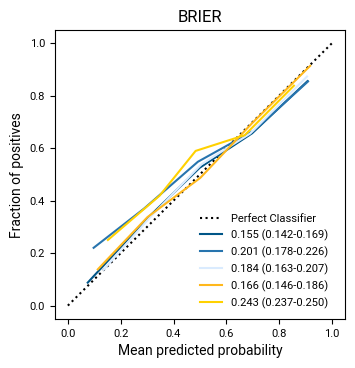

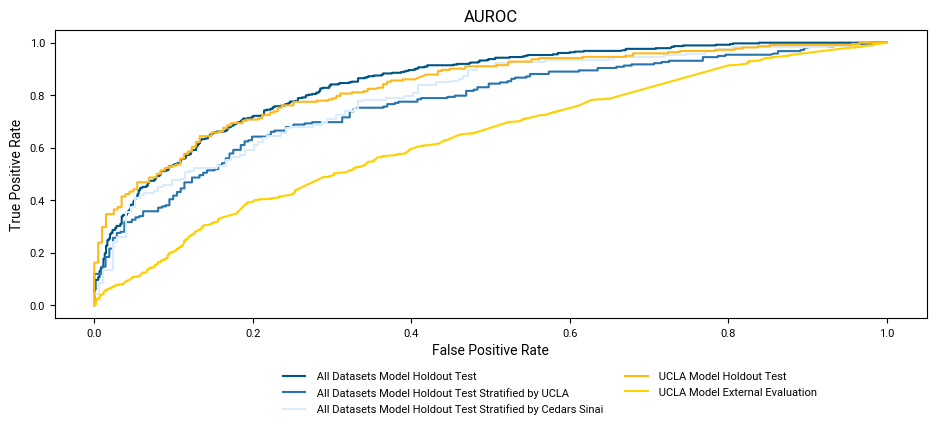

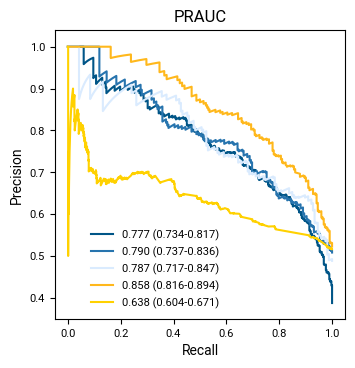

In [38]:
from models.static_models import CURVE_MAP

CURVE_PARAMS = {
    "calibration_curve": {
        "labels": ("prob_pred", "prob_true"),
        "limits": None,
        "metric": "brier",
    },
    "roc_curve": {"labels": ("fpr", "tpr"), "limits": (0, 1), "metric": "auroc"},
    "pr_curve": {"labels": ("recall", "precision"), "limits": None, "metric": "ap"},
    "det_curve": {"labels": ("fpr", "fnr"), "limits": None, "metric": "accuracy"},
}
curve_names = args.curve_names
curve_fns = [CURVE_MAP[metric] for metric in curve_names]
curve_params = [CURVE_PARAMS[metric] for metric in curve_names]

plt_labels = ['All Datasets Model Holdout Test', 'UCLA Model Holdout Test', "UCLA Model External Evaluation"]
runs = [all_preselectall, ucla_train, ucla_train]
filters = ['', '', 'cedars_crrt']

subgroups = [""]
subgroup_labels = [""]
colors = ['#005587','#2774AE', '#DAEBFE', '#FFB81C', '#FFD100']
plot_metrics(curve_names, curve_fns, curve_params, 
             runs, filters, plt_labels, 
             subgroups, subgroup_labels, colors, 
             bootstrap_point=True)

# plt_labels = ['Combined Dsets Model', 'UCLA Model', "UCLA Model External"]
# runs = [all_preselectall, ucla_train, ucla_train]
# filters = ['', '', 'cedars_crrt']
# subgroups = ["_heart", "_liver", "_infection"]
# subgroup_labels = ["Heart", "Liver", "Infection"]
# colors = ['#446D00','#66A400', '#8ED000', '#56005D', '#9D00F1','#CD6FFF','#AF0000','#FF0000','#FF8787']
# plot_metrics(curve_names, curve_fns, curve_params, 
#              runs, filters, plt_labels, 
#              subgroups, subgroup_labels, colors, 
#              bootstrap_point=True)

uclapluscedars_to_uclapluscedars_preselectcrrt_tune100_v17__calibration_curve
uclapluscedars_to_uclapluscedars_preselectcrrt_tune100_v17__roc_curve
uclapluscedars_to_uclapluscedars_preselectcrrt_tune100_v17__pr_curve
cedars_to_cedars_tune100_v17__calibration_curve
cedars_to_cedars_tune100_v17__roc_curve
cedars_to_cedars_tune100_v17__pr_curve


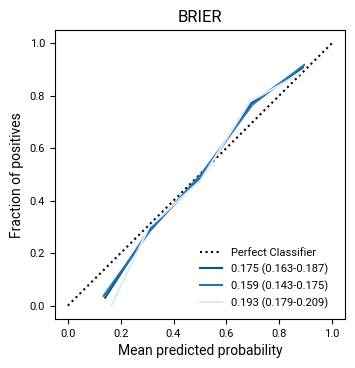

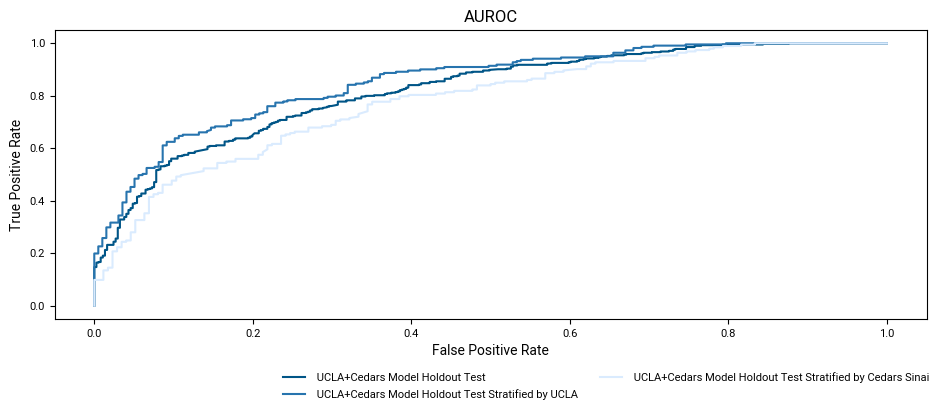

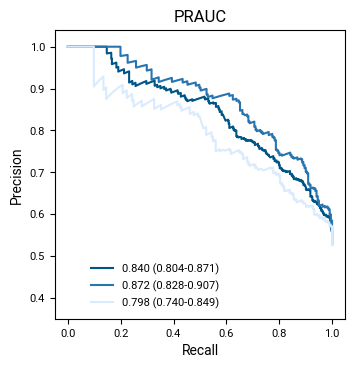

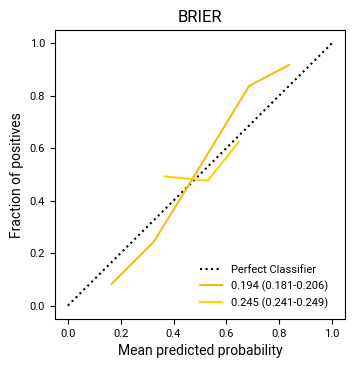

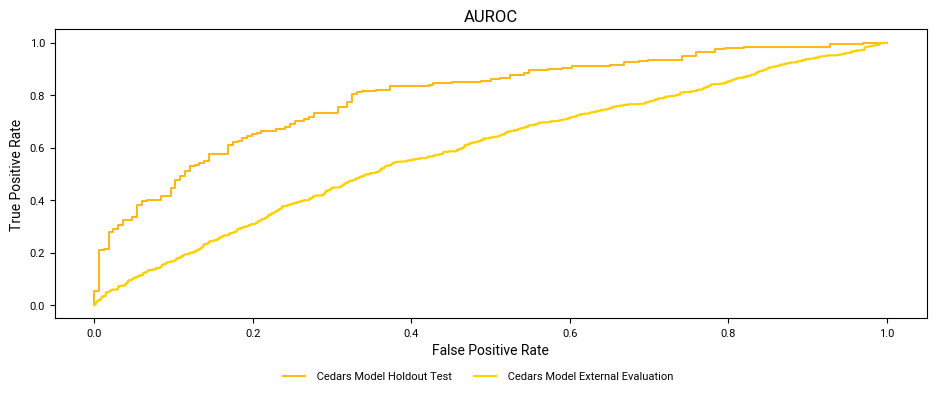

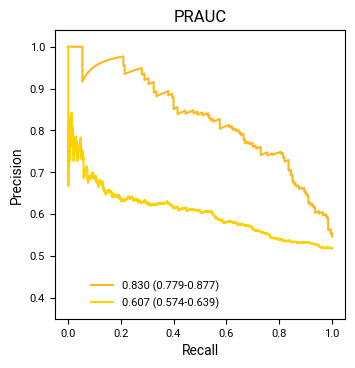

In [39]:
from models.static_models import CURVE_MAP

CURVE_PARAMS = {
    "calibration_curve": {
        "labels": ("prob_pred", "prob_true"),
        "limits": None,
        "metric": "brier",
    },
    "roc_curve": {"labels": ("fpr", "tpr"), "limits": (0, 1), "metric": "auroc"},
    "pr_curve": {"labels": ("recall", "precision"), "limits": None, "metric": "ap"},
    "det_curve": {"labels": ("fpr", "fnr"), "limits": None, "metric": "accuracy"},
}
curve_names = args.curve_names
curve_fns = [CURVE_MAP[metric] for metric in curve_names]
curve_params = [CURVE_PARAMS[metric] for metric in curve_names]

plt_labels = ['UCLA+Cedars Model Holdout Test']
runs = [uclapluscedars_preselectcrrt]
filters = ['']

subgroups = [""]
subgroup_labels = [""]
colors = ['#005587','#2774AE', '#DAEBFE', '#FFB81C', '#FFD100']
plot_metrics(curve_names, curve_fns, curve_params, 
             runs, filters, plt_labels, 
             subgroups, subgroup_labels, colors, 
             bootstrap_point=True)

plt_labels = ['Cedars Model Holdout Test', "Cedars Model External Evaluation"]
runs = [cedars_train, cedars_train]
filters = ['', 'ucla_crrt']

subgroups = [""]
subgroup_labels = [""]
colors = [ '#FFB81C', '#FFD100']
plot_metrics(curve_names, curve_fns, curve_params, 
             runs, filters, plt_labels, 
             subgroups, subgroup_labels, colors, 
             bootstrap_point=True)

# Subgroups

## Helper functions

In [12]:
from models.static_models import METRIC_MAP
from evaluate.utils import bootstrap_metric, confidence_interval, eval_metric
from tqdm import tqdm
from collections import defaultdict
import matplotlib.colors as mcolors

subgroup_dir = os.path.join(output_dir, "subgroups")
os.makedirs(subgroup_dir, exist_ok=True)

def subgroup_tables(metric_names,
                    runs, filters,
                    subgroups, subgroup_labels,
                    full_horizon=False,
                    bootstrap_point=True):
    
    for run,filter in zip(runs, filters):
        table = get_subgroup_table(metric_names, run, filter, subgroups, subgroup_labels, bootstrap_point=bootstrap_point, full_horizon=full_horizon)
        display(pd.DataFrame(table))
        
def get_subgroup_table(metric_names, 
              run_name, filter,
              subgroups, subgroup_labels, 
              bootstrap_point=True,
              full_horizon=False):
    
    table = {'counts': {}}

    if len(filter) > 0:
        if full_horizon and filter != 'ucla_control':
            run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter}_200 best'")
        else:
            run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
    else:
        run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // eval best'")

    metrics = run.data.metrics

    for metric_name in tqdm(metric_names):
        
        metric_fn = METRIC_MAP[metric_name]
        table[metric_name] = {}
        
        for subgroup, subgroup_label in zip(subgroups, subgroup_labels):
            
            prefix = f"{run.data.tags['modeln']}_test{subgroup}"
            
            if filter != 'ucla_control':
                if f"{prefix}__{metric_name}" in metrics.keys() and (metrics[prefix+'__'+metric_name]==metrics[prefix+'__'+metric_name]):
                    _, labels, pred_probas = get_original_probabilities(exp_path, run.info.run_id, run_name, prefix)
                    
                    # if eval_cohort is not None:
                    #     bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                    #     point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point) 
                    #     ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                    # else:
                    point_estimate = get_point_estimate(metrics[prefix+'__'+metric_name], labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point) 
                    ci_low = metrics[f"{prefix}__{metric_name}_CI_low"]
                    ci_high = metrics[f"{prefix}__{metric_name}_CI_high"]
                        
                    table[metric_name][subgroup_label] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                    
                    if len(labels.value_counts()) > 1:
                        table['counts'][subgroup_label] = f"{len(labels)} ({labels.value_counts()[1]/len(labels)*100:.1f}%)"
                    else:
                        table['counts'][subgroup_label] = f"{len(labels)} (0%)"
                else:
                    print(f'{prefix} not calculated')
                    try:
                        _, labels, pred_probas = get_original_probabilities(exp_path, run.info.run_id, run_name, prefix)
                        bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                        point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point) 
                        ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                        table[metric_name][subgroup_label] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                        if len(labels.value_counts()) > 1:
                            table['counts'][subgroup_label] = f"{len(labels)} ({labels.value_counts()[1]/len(labels)*100:.1f}%)"
                        else:
                            table['counts'][subgroup_label] = f"{len(labels)} (0%)"
                    except:  
                        table[metric_name][subgroup_label] = "0.0 (0.0-0.0)"
                        table['counts'][subgroup_label] = "0 (0%)"
                    
                if 'plus' in run_name or 'all_to_all' in run_name:
                    try:          
                        prob_df, _, _ = get_original_probabilities(exp_path, run.info.run_id, run_name, prefix)
                        
                        # ISOLATE UCLA
                        ucla_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(UCLA_IDS)]
                        labels = ucla_prob_df['recommend_crrt']
                        pred_probas = ucla_prob_df[0].values
                        
                        try:
                            bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                            point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point) 
                            ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                            table[metric_name][f"{subgroup_label} ucla_crrt"] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                            
                            if len(labels.value_counts()) > 1:
                                table['counts'][f"{subgroup_label} ucla_crrt"] = f"{len(labels)} ({labels.value_counts()[1]/len(labels)*100:.1f}%)"
                            else:
                                table['counts'][f"{subgroup_label} ucla_crrt"] = f"{len(labels)} (0%)"
                        except:
                            table[metric_name][f"{subgroup_label} ucla_crrt"] = "0.0 (0.0-0.0)"
                            table['counts'][f"{subgroup_label} ucla_crrt"] = "0 (0%)"
                        
                        # ISOLATE CEDARS
                        cedars_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(CEDARS_IDS)]
                        labels = cedars_prob_df['recommend_crrt']
                        pred_probas = cedars_prob_df[0].values
                        try:
                            bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                            point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point) 
                            ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                            table[metric_name][f"{subgroup_label} cedars_crrt"] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                            if len(labels.value_counts()) > 1:
                                table['counts'][f"{subgroup_label} cedars_crrt"] = f"{len(labels)} ({labels.value_counts()[1]/len(labels)*100:.1f}%)"
                            else:
                                table['counts'][f"{subgroup_label} cedars_crrt"] = f"{len(labels)} (0%)"   
                        except:
                            table[metric_name][f"{subgroup_label} cedars_crrt"] = "0.0 (0.0-0.0)"
                            table['counts'][f"{subgroup_label} cedars_crrt"] = "0 (0%)"
                    except:
                        table[metric_name][f"{subgroup_label} ucla_crrt"] = "0.0 (0.0-0.0)"
                        table['counts'][f"{subgroup_label} ucla_crrt"] = "0 (0%)"
                        table[metric_name][f"{subgroup_label} cedars_crrt"] = "0.0 (0.0-0.0)"
                        table['counts'][f"{subgroup_label} cedars_crrt"] = "0 (0%)"
                                 
            else:
                # GET THE CONTROL
                try:
                    _, labels, pred_probas = get_control_probabilities(exp_path, run, run_name, prefix, full_horizon=full_horizon)
                    
                    # GET METRIC
                    bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)

                    point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)
                    ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                    table[metric_name][subgroup_label] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                    if len(labels.value_counts()) > 1:
                        table['counts'][subgroup_label] = f"{len(labels)} ({labels.value_counts()[1]/len(labels)*100:.1f}%)"
                    else:
                        table['counts'][subgroup_label] = f"{len(labels)} (0%)"
                except:
                    table[metric_name][subgroup_label] = "0.0 (0.0-0.0)"
                    table['counts'][subgroup_label] = "0 (0%)"
    
    eval_cohort_str = ''
    if full_horizon:
        eval_cohort_str = f'_full_horizon'
        
    with open(os.path.join(subgroup_dir,f'{run_name}_{filter}{eval_cohort_str}_subgroups.pkl'), 'wb') as f:
        pickle.dump(table,f)   
         
    return table

def report_as_is(metric_names,
                    runs, filters,
                    subgroup_labels,
                    full_horizon=False):
    
        
    for run, filter in zip(runs, filters):
        
        eval_cohort_str = ''
        if full_horizon:
            eval_cohort_str = f'_full_horizon'
        
        with open(os.path.join(subgroup_dir,f'{run}_{filter}{eval_cohort_str}_subgroups.pkl'), 'rb') as f:
            table = pickle.load(f)
                
        metric_table = {}    
        
        for metric_name in metric_names:
            metric_table[metric_name] = {}
                
            for subgroup_label in subgroup_labels:
                metric_table[metric_name][subgroup_label] = table[metric_name][subgroup_label]
    
                if ('plus' in run or 'all_to_all' in run) and 'control' not in filter:
                    metric_table[metric_name][f'{subgroup_label} ucla_crrt'] = table[metric_name][f'{subgroup_label} ucla_crrt']
                    metric_table[metric_name][f'{subgroup_label} cedars_crrt'] = table[metric_name][f'{subgroup_label} cedars_crrt']
                    
        display(pd.DataFrame(metric_table))

def report_subgroup_metrics(metric_names,
                    runs, filters,
                    subgroup_labels,
                    full_horizon=False):

        
    for metric_name in metric_names:
        metric_table = {}
        
        
        for subgroup_label in subgroup_labels:
            metric_table[subgroup_label] = {}
            
            for run, filter in zip(runs, filters):
            
                eval_cohort_str = ''
                if full_horizon:
                    eval_cohort_str = f'_full_horizon'
                
                with open(os.path.join(subgroup_dir,f'{run}_{filter}{eval_cohort_str}_subgroups.pkl'), 'rb') as f:
                    table = pickle.load(f)
                
                metric_table[subgroup_label][f'{run} {filter}'] = table[metric_name][subgroup_label]
    
                if ('plus' in run or 'all_to_all' in run) and 'control' not in filter:
                    metric_table[subgroup_label][f'{run} {filter} ucla_crrt'] = table[metric_name][f'{subgroup_label} ucla_crrt']
                    metric_table[subgroup_label][f'{run} {filter} cedars_crrt'] = table[metric_name][f'{subgroup_label} cedars_crrt']
                    
        display(pd.DataFrame(metric_table))
    
def plot_subgroup(metric_names,
                    runs, filters, plt_labels,
                    subgroup_labels, subgroup_categories,
                    full_horizon=False,
                    strat=None,):
    

    for metric_name in metric_names:
        metric_table = defaultdict(list)
        ci_low_table = defaultdict(list)
        ci_high_table = defaultdict(list)
        
        for run, filter in zip(runs, filters):      
            eval_cohort_str = ''
            if full_horizon:
                eval_cohort_str = f'_full_horizon' 
            
            with open(os.path.join(subgroup_dir,f'{run}_{filter}{eval_cohort_str}_subgroups.pkl'), 'rb') as f:
                table = pickle.load(f)
                
            for subgroup_label in subgroup_labels:
                metric_table[f'{run} {filter}'].append(float(table[metric_name][subgroup_label].split(' (')[0]))
                ci_low_table[f'{run} {filter}'].append(float(table[metric_name][subgroup_label].split('(')[-1].split('-')[0]))
                ci_high_table[f'{run} {filter}'].append(float(table[metric_name][subgroup_label].split('-')[-1].split(')')[0]))

                if ('plus' in run or 'all_to_all' in run) and 'control' not in filter and strat:
                    metric_table[f'{run} {filter} ucla_crrt'].append(float(table[metric_name][f'{subgroup_label} ucla_crrt'].split(' (')[0]))
                    ci_low_table[f'{run} {filter} ucla_crrt'].append(float(table[metric_name][f'{subgroup_label} ucla_crrt'].split('(')[-1].split('-')[0]))
                    ci_high_table[f'{run} {filter} ucla_crrt'].append(float(table[metric_name][f'{subgroup_label} ucla_crrt'].split('-')[-1].split(')')[0]))
                
                    metric_table[f'{run} {filter} cedars_crrt'].append(float(table[metric_name][f'{subgroup_label} cedars_crrt'].split(' (')[0]))
                    ci_low_table[f'{run} {filter} cedars_crrt'].append(float(table[metric_name][f'{subgroup_label} cedars_crrt'].split('(')[-1].split('-')[0]))
                    ci_high_table[f'{run} {filter} cedars_crrt'].append(float(table[metric_name][f'{subgroup_label} cedars_crrt'].split('-')[-1].split(')')[0]))
                        
        for key_ in metric_table.keys():
            ci_low_table[key_] = np.absolute(np.array(metric_table[key_]) - np.array(ci_low_table[key_]))
            ci_high_table[key_] = np.absolute(np.array(ci_high_table[key_]) - np.array(metric_table[key_]))
            
        # organize subgroups into broader categories (eg. age, race)
        x = []
        category_x = []
        category_labels = []
        prev_category = None
        current_category = None
        index = len(subgroup_labels) + len(np.unique(subgroup_categories)) - 1
        for i in range(len(subgroup_labels)):
            current_category = subgroup_categories[i]
            if current_category != prev_category:
                category_x.append(index)
                category_labels.append(current_category)
                index -= 1
                prev_category = current_category
            x.append(index)
            index -= 1
        x = np.array(x)
        
        # plotting
        fig, ax = plt.subplots()
        width = 0.25
        multiplier = 0
        
        for i, key_ in enumerate(metric_table.keys()):
            
            offset = width * multiplier
            
            # Horizontal
            # ax.bar(x + offset, grouped_metric_vals[i], width, label=plt_labels[i], yerr=[errors_low[i], errors_high[i]])
            # plt.errorbar(x + offset, grouped_metric_vals[i], yerr=[errors_low[i], errors_high[i]], marker="D", capsize=5, elinewidth=2,label=plt_labels[i])
            
            # Vertical
            ax.barh(x + offset, metric_table[key_], width, label=plt_labels[i], xerr=[ci_low_table[key_], ci_high_table[key_]],capsize=3)
            # plt.errorbar(metric_table[key_], x + offset, xerr=[ci_low_table[key_], ci_high_table[key_]], marker="D", 
            #              capsize=3, elinewidth=1,label=plt_labels[i], linestyle='none')
        
            
            # Plot a vertical line for main value (metric on all patients)
            # ax.plot([0., x[-1]], [grouped_metric_vals[0][0], grouped_metric_vals[0][0]], "k--")
            # ax.plot([0., x[-1]], [grouped_metric_vals[1][0], grouped_metric_vals[1][0]], "k--")
            ax.plot([metric_table[key_][0], metric_table[key_][0]], [0., x[0]], "k--", linewidth=1)
            
            multiplier += 1
        
        # Subgroup category labels
        ax.set_yticks(category_x, category_labels, minor=False, fontweight='bold')
        # Subgroup labels
        ax.set_yticks(x + width, subgroup_labels, minor=True)
        
        if metric_name not in ['TP', 'FP', 'TN', 'FN']:
            ax.set_xlim([0,1])
        ax.tick_params(axis='y', which='major', length=0)
        # plt.yticks(ha='left')
        # ax.set_title(name)
        ax.set_xlabel(metric_name.upper())
        ax.legend(loc="upper left", bbox_to_anchor=(-0.1, -0.05))
        
        # save figure
        name = f"{metric_name}_subgroup" 
        print(name)
        fig = plt.gcf()
        fig.set_size_inches(3, 10)
        plt.savefig(os.path.join(subgroup_dir,f'{name}_forestplot.svg'), format='svg',  bbox_inches="tight")

def plot_subgroup_onerun(metric_names,
                    run, filter,
                    subgroup_labels, subgroup_categories,
                    full_horizon=False,
                    strat=None,):
    
    # organize subgroups into broader categories (eg. age, race)
    x = []
    category_x = []
    category_labels = []
    prev_category = None
    current_category = None
    index = len(subgroup_labels) + len(np.unique(subgroup_categories)) - 1
    for i in range(len(subgroup_labels)):
        current_category = subgroup_categories[i]
        if current_category != prev_category:
            category_x.append(index)
            category_labels.append(current_category)
            index -= 1
            prev_category = current_category
        x.append(index)
        index -= 1
    x = np.array(x)
    
    # plotting
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set2.colors)

    fig, ax = plt.subplots()
    width = 0.3
    multiplier = 0
        
    metric_table = defaultdict(list)
    ci_low_table = defaultdict(list)
    ci_high_table = defaultdict(list)
    
    eval_cohort_str = ''
    if full_horizon:
        eval_cohort_str = f'_full_horizon' 
    
    with open(os.path.join(subgroup_dir,f'{run}_{filter}{eval_cohort_str}_subgroups.pkl'), 'rb') as f:
        table = pickle.load(f)
    
            
    subgroup_labels_with_counts = []
    for subgroup_label in subgroup_labels:
        lab_ = subgroup_label.replace('\ninfection','infection')
        subgroup_labels_with_counts.append(f"{lab_}\n N={table['counts'][subgroup_label]}")
        
    for metric_name in metric_names:
            
        for subgroup_label in subgroup_labels:
            metric_table[metric_name].append(float(table[metric_name][subgroup_label].split(' (')[0]))
            ci_low_table[metric_name].append(float(table[metric_name][subgroup_label].split('(')[-1].split('-')[0]))
            ci_high_table[metric_name].append(float(table[metric_name][subgroup_label].split('-')[-1].split(')')[0]))
            
            if ('plus' in run or 'all_to_all' in run) and 'control' not in filter and strat:
                metric_table[f'{metric_name} ucla_crrt'].append(float(table[metric_name][f'{subgroup_label} ucla_crrt'].split(' (')[0]))
                ci_low_table[f'{metric_name} ucla_crrt'].append(float(table[metric_name][f'{subgroup_label} ucla_crrt'].split('(')[-1].split('-')[0]))
                ci_high_table[f'{metric_name} ucla_crrt'].append(float(table[metric_name][f'{subgroup_label} ucla_crrt'].split('-')[-1].split(')')[0]))
            
                metric_table[f'{metric_name} cedars_crrt'].append(float(table[metric_name][f'{subgroup_label} cedars_crrt'].split(' (')[0]))
                ci_low_table[f'{metric_name} cedars_crrt'].append(float(table[metric_name][f'{subgroup_label} cedars_crrt'].split('(')[-1].split('-')[0]))
                ci_high_table[f'{metric_name} cedars_crrt'].append(float(table[metric_name][f'{subgroup_label} cedars_crrt'].split('-')[-1].split(')')[0]))
                        
    for key_ in metric_table.keys():
        ci_low_table[key_] = np.absolute(np.array(metric_table[key_]) - np.array(ci_low_table[key_]))
        ci_high_table[key_] = np.absolute(np.array(ci_high_table[key_]) - np.array(metric_table[key_]))
    
    # plt.rcParams['image.cmap'] = 'Set2'
    colors = ['#FF00A5','#00FFFF']
    for i, key_ in enumerate(metric_table.keys()):
        
        offset = width * multiplier
        
        # Horizontal
        # ax.bar(x + offset, grouped_metric_vals[i], width, label=plt_labels[i], yerr=[errors_low[i], errors_high[i]])
        # plt.errorbar(x + offset, grouped_metric_vals[i], yerr=[errors_low[i], errors_high[i]], marker="D", capsize=5, elinewidth=2,label=plt_labels[i])
        
        # Vertical
        ax.barh(x + offset, metric_table[key_], width, label=metric_names[i].replace('ap','PRAUC').upper(), xerr=[ci_low_table[key_], ci_high_table[key_]],capsize=2,color=colors[i])
        # plt.errorbar(metric_table[key_], x + offset, xerr=[ci_low_table[key_], ci_high_table[key_]], marker="D", 
        #              capsize=3, elinewidth=1,label=metric_names[i].upper(), linestyle='none')
    
        
        # Plot a vertical line for main value (metric on all patients)
        # ax.plot([0., x[-1]], [grouped_metric_vals[0][0], grouped_metric_vals[0][0]], "k--")
        # ax.plot([0., x[-1]], [grouped_metric_vals[1][0], grouped_metric_vals[1][0]], "k--")
        ax.plot([metric_table[key_][0], metric_table[key_][0]], [0., x[0]], "k--", linewidth=1, alpha=0.5)
        
        multiplier += 1
        
    # Subgroup category labels
    ax.set_yticks(category_x, category_labels, minor=False, fontweight='bold')
    # Subgroup labels
    ax.set_yticks(x + width*(multiplier-1)/2, subgroup_labels_with_counts, minor=True)
    
    if metric_name not in ['TP', 'FP', 'TN', 'FN']:
        ax.set_xlim([0,1])
    ax.tick_params(axis='y', which='major', length=0)
    # plt.yticks(ha='left')
    # ax.set_title(name)
    ax.set_xlabel('Value')
    ax.legend(loc="upper left", bbox_to_anchor=(0.0, 0.03),ncol=len(metric_table.keys()),
              frameon=False, columnspacing=0.5,handlelength=1,handletextpad=0.25)
    
    # save figure
    name = f"{run}{filter}_subgroup" 
    print(name)
    fig = plt.gcf()
    fig.set_size_inches(3, 10)
    plt.savefig(os.path.join(subgroup_dir, f'{name}_forestplot.svg'), format='svg',  bbox_inches="tight")
    plt.show()
    plt.close()
                    

## Process subgroups

### No intersection + Intersection

In [13]:
metric_names = args.metric_names + ['specificity']

runs = [
        # ucla_train,
        # ucla_train,
        # ucla_train,
        # cedars_train,
        # cedars_train,
        # cedars_train,
        # uclapluscedars_train,
        # uclapluscedars_train,
        # all_train,
        # ucla_preselectall,
        # ucla_preselectall,
        # ucla_preselectall,
        # ucla_preselectcrrt,
        # ucla_preselectcrrt,
        # cedars_preselectall,
        # cedars_preselectall,
        # cedars_preselectall,
        # cedars_preselectcrrt,
        # cedars_preselectcrrt,
        # uclapluscedars_preselectall,
        # uclapluscedars_preselectall,
        # uclapluscedars_preselectcrrt,
        # all_preselectall
        ]
filters = [
        #     '',
        #     'cedars_crrt',
        #     'ucla_control',
        #     '',
        #     'ucla_crrt',
        #     'ucla_control',
        #     '',
        #     'ucla_control',
            # '',
            
        #     "",
        #     "cedars_crrt",
        #     "ucla_control",
        #     "",
        #     "cedars_crrt",
            
        #     '',
        #     'ucla_crrt',
        #     'ucla_control',
        #     '',
        #     'ucla_crrt',
            
        #     '',
        #     'ucla_control',
        #     '',
        #     ''
            ]

subgroups = [
              "", "_heart", "_liver", "_infection",'_no_heart_liver_infection',
              '_female','_male', 
              '_American Indian or Alaska Native','_Asian','_Black or African American','_Native Hawaiian or Other Pacific Islander','_Multiple Races','_Unknown','_White or Caucasian',
              '_Hispanic or Latino','_Not Hispanic or Latino',
              '_age_20_to_30', '_age_30_to_40', '_age_40_to_50', '_age_50_to_60', '_age_60_to_70', '_age_70_to_80','_age_80_to_90','_age_90_to_100'
            ]
subgroup_labels = [
              "all", "heart", "liver", "infection","no heart,liver,\ninfection",
              'female','male', 
              'American Indian\nor Alaska Native','Asian','Black or African American','Native Hawaiian or\nOther Pacific Islander','Multiple Races','Unknown','White or Caucasian',
              'Hispanic or Latino','Not Hispanic or Latino',
              '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80','80 to 90','90 to 100'
              ]

subgroup_categories = [
              "indicator", "indicator", "indicator", "indicator","indicator",
              'sex','sex', 
              'race','race','race','race','race','race','race',
              'ethnicity','ethnicity',
              'age','age','age','age','age','age','age','age'
              ]

subgroup_tables(metric_names,
                runs, filters,
                subgroups, subgroup_labels,
                bootstrap_point=True,
                full_horizon=False)


  0%|          | 0/11 [00:00<?, ?it/s]

### CRRT Total Days > 7 included

In [90]:
metric_names = args.metric_names + ['specificity']


runs = [
        # ucla_train,
        # ucla_train,
        # ucla_train,
        # cedars_train,
        # cedars_train,
        # cedars_train,
        # uclapluscedars_train,
        uclapluscedars_train,
        all_train,
        ucla_preselectall,
        ucla_preselectall,
        ucla_preselectall,
        ucla_preselectcrrt,
        ucla_preselectcrrt,
        cedars_preselectall,
        cedars_preselectall,
        cedars_preselectall,
        cedars_preselectcrrt,
        cedars_preselectcrrt,
        uclapluscedars_preselectall,
        uclapluscedars_preselectall,
        uclapluscedars_preselectcrrt,
        all_preselectall
        ]
filters = [
        #     'ucla_crrt',
        #     'cedars_crrt',
        #     'ucla_control',
        #     'cedars_crrt',
        #     'ucla_crrt',
        #     'ucla_control',
        #     'ucla_crrt+cedars_crrt',
            'ucla_control',
            'ucla_crrt+cedars_crrt+ucla_control',
            "ucla_crrt",
            "cedars_crrt",
            "ucla_control",
            "ucla_crrt",
            "cedars_crrt",
            'cedars_crrt',
            'ucla_crrt',
            'ucla_control',
            'cedars_crrt',
            'ucla_crrt',
            'ucla_crrt+cedars_crrt',
            'ucla_control',
            'ucla_crrt+cedars_crrt',
            'ucla_crrt+cedars_crrt+ucla_control'
            ]

subgroups = [
              "", "_heart", "_liver", "_infection",'_no_heart_liver_infection',
              '_female','_male', 
              '_American Indian or Alaska Native','_Asian','_Black or African American','_Native Hawaiian or Other Pacific Islander','_Multiple Races','_Unknown','_White or Caucasian',
              '_Hispanic or Latino','_Not Hispanic or Latino',
              '_age_20_to_30', '_age_30_to_40', '_age_40_to_50', '_age_50_to_60', '_age_60_to_70', '_age_70_to_80','_age_80_to_90','_age_90_to_100'
            ]
subgroup_labels = [
              "all", "heart", "liver", "infection","no heart,liver,\ninfection",
              'female','male', 
              'American Indian\nor Alaska Native','Asian','Black or African American','Native Hawaiian or\nOther Pacific Islander','Multiple Races','Unknown','White or Caucasian',
              'Hispanic or Latino','Not Hispanic or Latino',
              '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80','80 to 90','90 to 100'
              ]

subgroup_categories = [
              "indicator", "indicator", "indicator", "indicator","indicator",
              'sex','sex', 
              'race','race','race','race','race','race','race',
              'ethnicity','ethnicity',
              'age','age','age','age','age','age','age','age'
              ]

subgroup_tables(metric_names,
                runs, filters,
                subgroups, subgroup_labels,
                bootstrap_point=True,
                full_horizon=True
                )


  0%|          | 0/11 [00:00<?, ?it/s]

## Visualize subgroups

### All patients (CRRT Total Days > 7 included)

In [13]:
runs = [
        ucla_train,
        ucla_train,
        ucla_train,
        cedars_train,
        cedars_train,
        cedars_train,
        uclapluscedars_train,
        uclapluscedars_train,
        all_train,
        ucla_preselectall,
        ucla_preselectall,
        ucla_preselectall,
        ucla_preselectcrrt,
        ucla_preselectcrrt,
        cedars_preselectall,
        cedars_preselectall,
        cedars_preselectall,
        cedars_preselectcrrt,
        cedars_preselectcrrt,
        uclapluscedars_preselectall,
        uclapluscedars_preselectall,
        uclapluscedars_preselectcrrt,
        all_preselectall
        ]
filters = [
            'ucla_crrt',
            'cedars_crrt',
            'ucla_control',
            'cedars_crrt',
            'ucla_crrt',
            'ucla_control',
            'ucla_crrt+cedars_crrt',
            'ucla_control',
            'ucla_crrt+cedars_crrt+ucla_control',
            "ucla_crrt",
            "cedars_crrt",
            "ucla_control",
            "ucla_crrt",
            "cedars_crrt",
            'cedars_crrt',
            'ucla_crrt',
            'ucla_control',
            'cedars_crrt',
            'ucla_crrt',
            'ucla_crrt+cedars_crrt',
            'ucla_control',
            'ucla_crrt+cedars_crrt',
            'ucla_crrt+cedars_crrt+ucla_control'
            ]

subgroup_labels = [
              "all", "heart", "liver", "infection","no heart,liver,\ninfection",
              'female','male', 
              'American Indian\nor Alaska Native','Asian','Black or African American','Native Hawaiian or\nOther Pacific Islander','Multiple Races','Unknown','White or Caucasian',
              'Hispanic or Latino','Not Hispanic or Latino',
              '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80','80 to 90','90 to 100'
              ]

report_subgroup_metrics(['counts','auroc', 'ap', 'brier'],
                runs, filters,
                subgroup_labels,
                full_horizon=True)

all  \
ucla_to_ucla_tune100_v17 ucla_crrt                  1746 (53.6%)   
ucla_to_ucla_tune100_v17 cedars_crrt                2867 (54.3%)   
ucla_to_ucla_tune100_v17 ucla_control               2520 (37.1%)   
cedars_to_cedars_tune100_v17 cedars_crrt            1316 (54.6%)   
cedars_to_cedars_tune100_v17 ucla_crrt              3698 (54.2%)   
cedars_to_cedars_tune100_v17 ucla_control           4762 (42.1%)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  3092 (54.2%)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  1769 (54.3%)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  1323 (54.1%)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  4018 (41.7%)   
all_to_all_tune100_v17 ucla_crrt+cedars_crrt+uc...  3282 (49.5%)   
ucla_to_ucla_preselectall_tune100_v17 ucla_crrt     1756 (53.6%)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   2870 (54.3%)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control  2583 (36.5%)   
ucla_to_ucla_preselectcrrt_tune100_v17 ucla_crrt    1746 (53.6%)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  2867 (54.3%)   
cedars_to_cedars_preselectall_tune100_v17 cedar...  1316 (54.6%)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  3698 (54.2%)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  4762 (42.1%)   
cedars_to_cedars_preselectcrrt_tune100_v17 ceda...  1316 (54.6%)   
cedars_to_cedars_preselectcrrt_tune100_v17 ucla...  3698 (54.2%)   
uclapluscedars_to_uclapluscedars_preselectall_t...  3060 (53.7%)   
uclapluscedars_to_uclapluscedars_preselectall_t...  1738 (54.0%)   
uclapluscedars_to_uclapluscedars_preselectall_t...  1322 (53.3%)   
uclapluscedars_to_uclapluscedars_preselectall_t...  3927 (41.8%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  3092 (54.2%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  1769 (54.3%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  1323 (54.1%)   
all_to_all_preselectall_tune100_v17 ucla_crrt+c...  3282 (49.5%)   

                                                           heart  \
ucla_to_ucla_tune100_v17 ucla_crrt                   685 (51.7%)   
ucla_to_ucla_tune100_v17 cedars_crrt                1523 (50.4%)   
ucla_to_ucla_tune100_v17 ucla_control                916 (38.6%)   
cedars_to_cedars_tune100_v17 cedars_crrt            1087 (53.0%)   
cedars_to_cedars_tune100_v17 ucla_crrt              2541 (53.2%)   
cedars_to_cedars_tune100_v17 ucla_control           3023 (44.7%)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  1759 (52.3%)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...   889 (53.3%)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...   870 (51.3%)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  2101 (43.8%)   
all_to_all_tune100_v17 ucla_crrt+cedars_crrt+uc...  2339 (50.0%)   
ucla_to_ucla_preselectall_tune100_v17 ucla_crrt      754 (51.5%)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   1647 (50.6%)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control  1032 (37.6%)   
ucla_to_ucla_preselectcrrt_tune100_v17 ucla_crrt     685 (51.7%)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  1523 (50.4%)   
cedars_to_cedars_preselectall_tune100_v17 cedar...  1087 (53.0%)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  2541 (53.2%)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  3023 (44.7%)   
cedars_to_cedars_preselectcrrt_tune100_v17 ceda...  1087 (53.0%)   
cedars_to_cedars_preselectcrrt_tune100_v17 ucla...  2541 (53.2%)   
uclapluscedars_to_uclapluscedars_preselectall_t...  1647 (52.1%)   
uclapluscedars_to_uclapluscedars_preselectall_t...   827 (53.2%)   
uclapluscedars_to_uclapluscedars_preselectall_t...   820 (51.0%)   
uclapluscedars_to_uclapluscedars_preselectall_t...  1952 (44.0%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  1759 (52.3%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...   889 (53.3%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...   870 (51.3%)   
all_to_all_preselectall_tune100_v17 ucla_crrt+c.

all  \
ucla_to_ucla_tune100_v17 ucla_crrt                  0.65 (0.62-0.67)   
ucla_to_ucla_tune100_v17 cedars_crrt                0.60 (0.58-0.62)   
ucla_to_ucla_tune100_v17 ucla_control               0.63 (0.61-0.65)   
cedars_to_cedars_tune100_v17 cedars_crrt            0.75 (0.73-0.77)   
cedars_to_cedars_tune100_v17 ucla_crrt              0.58 (0.56-0.60)   
cedars_to_cedars_tune100_v17 ucla_control           0.53 (0.51-0.55)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.68 (0.66-0.70)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.66 (0.64-0.69)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.71 (0.68-0.73)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.66 (0.65-0.68)   
all_to_all_tune100_v17 ucla_crrt+cedars_crrt+uc...  0.74 (0.72-0.76)   
ucla_to_ucla_preselectall_tune100_v17 ucla_crrt     0.65 (0.63-0.68)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   0.56 (0.54-0.58)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control  0.65 (0.63-0.67)   
ucla_to_ucla_preselectcrrt_tune100_v17 ucla_crrt    0.66 (0.63-0.68)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  0.59 (0.57-0.61)   
cedars_to_cedars_preselectall_tune100_v17 cedar...  0.74 (0.72-0.77)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.58 (0.57-0.60)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.55 (0.54-0.57)   
cedars_to_cedars_preselectcrrt_tune100_v17 ceda...  0.75 (0.72-0.77)   
cedars_to_cedars_preselectcrrt_tune100_v17 ucla...  0.59 (0.58-0.61)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.66 (0.64-0.68)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.65 (0.62-0.68)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.68 (0.65-0.71)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.67 (0.65-0.68)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.67 (0.65-0.68)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.65 (0.63-0.68)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.70 (0.67-0.72)   
all_to_all_preselectall_tune100_v17 ucla_crrt+c...  0.72 (0.70-0.73)   

                                                               heart  \
ucla_to_ucla_tune100_v17 ucla_crrt                  0.66 (0.62-0.70)   
ucla_to_ucla_tune100_v17 cedars_crrt                0.62 (0.59-0.64)   
ucla_to_ucla_tune100_v17 ucla_control               0.63 (0.60-0.67)   
cedars_to_cedars_tune100_v17 cedars_crrt            0.76 (0.73-0.78)   
cedars_to_cedars_tune100_v17 ucla_crrt              0.57 (0.55-0.59)   
cedars_to_cedars_tune100_v17 ucla_control           0.53 (0.51-0.55)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.68 (0.66-0.71)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.65 (0.61-0.68)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.73 (0.70-0.77)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.67 (0.65-0.70)   
all_to_all_tune100_v17 ucla_crrt+cedars_crrt+uc...  0.74 (0.71-0.76)   
ucla_to_ucla_preselectall_tune100_v17 ucla_crrt     0.65 (0.61-0.69)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   0.58 (0.56-0.61)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control  0.64 (0.61-0.67)   
ucla_to_ucla_preselectcrrt_tune100_v17 ucla_crrt    0.65 (0.61-0.69)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  0.59 (0.57-0.62)   
cedars_to_cedars_preselectall_tune100_v17 cedar...  0.75 (0.73-0.78)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.57 (0.55-0.59)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.54 (0.52-0.56)   
cedars_to_cedars_preselectcrrt_tune100_v17 ceda...  0.76 (0.73-0.78)   
cedars_to_cedars_preselectcrrt_tune100_v17 ucla...  0.58 (0.55-0.60)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.67 (0.65-0.70)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.65 (0.61-0.68)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.70 (0.66-0.73)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.66 (0.63-0.68)   
uclapluscedars_to_uclapluscedars

all  \
ucla_to_ucla_tune100_v17 ucla_crrt                  0.67 (0.63-0.70)   
ucla_to_ucla_tune100_v17 cedars_crrt                0.62 (0.60-0.65)   
ucla_to_ucla_tune100_v17 ucla_control               0.50 (0.47-0.53)   
cedars_to_cedars_tune100_v17 cedars_crrt            0.79 (0.76-0.82)   
cedars_to_cedars_tune100_v17 ucla_crrt              0.61 (0.58-0.63)   
cedars_to_cedars_tune100_v17 ucla_control           0.44 (0.42-0.46)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.70 (0.67-0.72)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.69 (0.66-0.72)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.72 (0.69-0.76)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.58 (0.55-0.60)   
all_to_all_tune100_v17 ucla_crrt+cedars_crrt+uc...  0.72 (0.69-0.74)   
ucla_to_ucla_preselectall_tune100_v17 ucla_crrt     0.66 (0.63-0.70)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   0.60 (0.58-0.63)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control  0.50 (0.47-0.54)   
ucla_to_ucla_preselectcrrt_tune100_v17 ucla_crrt    0.68 (0.64-0.71)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  0.62 (0.59-0.64)   
cedars_to_cedars_preselectall_tune100_v17 cedar...  0.79 (0.75-0.81)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.61 (0.59-0.63)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.44 (0.42-0.46)   
cedars_to_cedars_preselectcrrt_tune100_v17 ceda...  0.79 (0.76-0.82)   
cedars_to_cedars_preselectcrrt_tune100_v17 ucla...  0.63 (0.61-0.65)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.68 (0.65-0.70)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.67 (0.63-0.71)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.71 (0.68-0.75)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.56 (0.54-0.59)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.67 (0.65-0.70)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.67 (0.63-0.70)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.71 (0.67-0.74)   
all_to_all_preselectall_tune100_v17 ucla_crrt+c...  0.70 (0.68-0.72)   

                                                               heart  \
ucla_to_ucla_tune100_v17 ucla_crrt                  0.65 (0.59-0.70)   
ucla_to_ucla_tune100_v17 cedars_crrt                0.60 (0.56-0.63)   
ucla_to_ucla_tune100_v17 ucla_control               0.51 (0.45-0.56)   
cedars_to_cedars_tune100_v17 cedars_crrt            0.79 (0.76-0.82)   
cedars_to_cedars_tune100_v17 ucla_crrt              0.59 (0.57-0.62)   
cedars_to_cedars_tune100_v17 ucla_control           0.47 (0.45-0.49)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.69 (0.65-0.72)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.67 (0.63-0.72)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.73 (0.69-0.78)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.60 (0.56-0.63)   
all_to_all_tune100_v17 ucla_crrt+cedars_crrt+uc...  0.72 (0.69-0.75)   
ucla_to_ucla_preselectall_tune100_v17 ucla_crrt     0.65 (0.59-0.70)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   0.59 (0.56-0.63)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control  0.50 (0.45-0.55)   
ucla_to_ucla_preselectcrrt_tune100_v17 ucla_crrt    0.66 (0.60-0.71)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  0.60 (0.56-0.63)   
cedars_to_cedars_preselectall_tune100_v17 cedar...  0.79 (0.75-0.82)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.59 (0.56-0.62)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.47 (0.44-0.49)   
cedars_to_cedars_preselectcrrt_tune100_v17 ceda...  0.79 (0.75-0.82)   
cedars_to_cedars_preselectcrrt_tune100_v17 ucla...  0.61 (0.58-0.64)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.67 (0.63-0.71)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.66 (0.61-0.71)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.72 (0.68-0.76)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.58 (0.54-0.62)   
uclapluscedars_to_uclapluscedars

all  \
ucla_to_ucla_tune100_v17 ucla_crrt                  0.25 (0.24-0.27)   
ucla_to_ucla_tune100_v17 cedars_crrt                0.25 (0.25-0.26)   
ucla_to_ucla_tune100_v17 ucla_control               0.28 (0.27-0.29)   
cedars_to_cedars_tune100_v17 cedars_crrt            0.21 (0.20-0.21)   
cedars_to_cedars_tune100_v17 ucla_crrt              0.24 (0.24-0.25)   
cedars_to_cedars_tune100_v17 ucla_control           0.27 (0.26-0.27)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.24 (0.23-0.25)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.25 (0.24-0.26)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.22 (0.21-0.23)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.26 (0.26-0.27)   
all_to_all_tune100_v17 ucla_crrt+cedars_crrt+uc...  0.22 (0.21-0.23)   
ucla_to_ucla_preselectall_tune100_v17 ucla_crrt     0.26 (0.25-0.28)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   0.29 (0.28-0.30)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control  0.29 (0.28-0.30)   
ucla_to_ucla_preselectcrrt_tune100_v17 ucla_crrt    0.28 (0.26-0.29)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  0.34 (0.32-0.35)   
cedars_to_cedars_preselectall_tune100_v17 cedar...  0.21 (0.20-0.21)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.24 (0.24-0.25)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.26 (0.26-0.27)   
cedars_to_cedars_preselectcrrt_tune100_v17 ceda...  0.21 (0.20-0.21)   
cedars_to_cedars_preselectcrrt_tune100_v17 ucla...  0.24 (0.24-0.25)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.24 (0.23-0.25)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.25 (0.24-0.27)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.23 (0.22-0.24)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.26 (0.25-0.27)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.23 (0.23-0.24)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.25 (0.23-0.26)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.22 (0.21-0.23)   
all_to_all_preselectall_tune100_v17 ucla_crrt+c...  0.23 (0.22-0.24)   

                                                               heart  \
ucla_to_ucla_tune100_v17 ucla_crrt                  0.26 (0.24-0.28)   
ucla_to_ucla_tune100_v17 cedars_crrt                0.24 (0.24-0.25)   
ucla_to_ucla_tune100_v17 ucla_control               0.29 (0.28-0.31)   
cedars_to_cedars_tune100_v17 cedars_crrt            0.20 (0.20-0.21)   
cedars_to_cedars_tune100_v17 ucla_crrt              0.25 (0.24-0.25)   
cedars_to_cedars_tune100_v17 ucla_control           0.26 (0.26-0.27)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.24 (0.23-0.25)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.27 (0.25-0.28)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.21 (0.20-0.23)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.26 (0.25-0.27)   
all_to_all_tune100_v17 ucla_crrt+cedars_crrt+uc...  0.22 (0.21-0.23)   
ucla_to_ucla_preselectall_tune100_v17 ucla_crrt     0.27 (0.25-0.29)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   0.31 (0.29-0.32)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control  0.31 (0.29-0.32)   
ucla_to_ucla_preselectcrrt_tune100_v17 ucla_crrt    0.29 (0.27-0.32)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  0.36 (0.34-0.38)   
cedars_to_cedars_preselectall_tune100_v17 cedar...  0.21 (0.20-0.21)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.25 (0.24-0.25)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.26 (0.26-0.27)   
cedars_to_cedars_preselectcrrt_tune100_v17 ceda...  0.21 (0.20-0.21)   
cedars_to_cedars_preselectcrrt_tune100_v17 ucla...  0.25 (0.24-0.25)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.24 (0.23-0.26)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.26 (0.24-0.28)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.23 (0.21-0.24)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.26 (0.25-0.27)   
uclapluscedars_to_uclapluscedars

### CRRT Total Days < 7

In [14]:
runs = [
        ucla_train,
        ucla_train,
        ucla_train,
        cedars_train,
        cedars_train,
        cedars_train,
        uclapluscedars_train,
        uclapluscedars_train,
        all_train,
        ucla_preselectall,
        ucla_preselectall,
        ucla_preselectall,
        ucla_preselectcrrt,
        ucla_preselectcrrt,
        cedars_preselectall,
        cedars_preselectall,
        cedars_preselectall,
        cedars_preselectcrrt,
        cedars_preselectcrrt,
        uclapluscedars_preselectall,
        uclapluscedars_preselectall,
        uclapluscedars_preselectcrrt,
        all_preselectall
        ]
filters = [
            '',
            'cedars_crrt',
            'ucla_control',
            '',
            'ucla_crrt',
            'ucla_control',
            '',
            'ucla_control',
            '',
            "",
            "cedars_crrt",
            "ucla_control",
            "",
            "cedars_crrt",
            '',
            'ucla_crrt',
            'ucla_control',
            '',
            'ucla_crrt',
            '',
            'ucla_control',
            '',
            ''
            ]


report_subgroup_metrics(['counts','auroc', 'ap','brier'],
                runs, filters,
                subgroup_labels)

all  \
ucla_to_ucla_tune100_v17                             425 (52.2%)   
ucla_to_ucla_tune100_v17 cedars_crrt                1788 (51.6%)   
ucla_to_ucla_tune100_v17 ucla_control               1199 (18.5%)   
cedars_to_cedars_tune100_v17                         366 (54.6%)   
cedars_to_cedars_tune100_v17 ucla_crrt              2149 (51.8%)   
cedars_to_cedars_tune100_v17 ucla_control           3213 (34.6%)   
uclapluscedars_to_uclapluscedars_tune100_v17         785 (52.7%)   
uclapluscedars_to_uclapluscedars_tune100_v17  u...   418 (52.9%)   
uclapluscedars_to_uclapluscedars_tune100_v17  c...   367 (52.6%)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  1711 (24.2%)   
all_to_all_tune100_v17                               991 (38.7%)   
all_to_all_tune100_v17  ucla_crrt                    429 (50.8%)   
all_to_all_tune100_v17  cedars_crrt                  340 (48.8%)   
ucla_to_ucla_preselectall_tune100_v17                430 (52.6%)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   1790 (51.6%)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control  1257 (18.0%)   
ucla_to_ucla_preselectcrrt_tune100_v17               425 (52.2%)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  1788 (51.6%)   
cedars_to_cedars_preselectall_tune100_v17            366 (54.6%)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  2149 (51.8%)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  3213 (34.6%)   
cedars_to_cedars_preselectcrrt_tune100_v17           366 (54.6%)   
cedars_to_cedars_preselectcrrt_tune100_v17 ucla...  2149 (51.8%)   
uclapluscedars_to_uclapluscedars_preselectall_t...   781 (51.7%)   
uclapluscedars_to_uclapluscedars_preselectall_t...   411 (53.3%)   
uclapluscedars_to_uclapluscedars_preselectall_t...   370 (50.0%)   
uclapluscedars_to_uclapluscedars_preselectall_t...  1648 (24.5%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...   785 (52.7%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...   418 (52.9%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...   367 (52.6%)   
all_to_all_preselectall_tune100_v17                  991 (38.7%)   
all_to_all_preselectall_tune100_v17  ucla_crrt       429 (50.8%)   
all_to_all_preselectall_tune100_v17  cedars_crrt     340 (48.8%)   

                                                           heart  \
ucla_to_ucla_tune100_v17                             191 (51.3%)   
ucla_to_ucla_tune100_v17 cedars_crrt                 975 (48.1%)   
ucla_to_ucla_tune100_v17 ucla_control                422 (23.2%)   
cedars_to_cedars_tune100_v17                         298 (51.7%)   
cedars_to_cedars_tune100_v17 ucla_crrt              1559 (50.7%)   
cedars_to_cedars_tune100_v17 ucla_control           2041 (38.8%)   
uclapluscedars_to_uclapluscedars_tune100_v17         466 (52.1%)   
uclapluscedars_to_uclapluscedars_tune100_v17  u...   221 (52.5%)   
uclapluscedars_to_uclapluscedars_tune100_v17  c...   245 (51.8%)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...   808 (30.1%)   
all_to_all_tune100_v17                               674 (40.7%)   
all_to_all_tune100_v17  ucla_crrt                    290 (48.6%)   
all_to_all_tune100_v17  cedars_crrt                  289 (46.0%)   
ucla_to_ucla_preselectall_tune100_v17                198 (48.5%)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   1048 (48.3%)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control   476 (20.2%)   
ucla_to_ucla_preselectcrrt_tune100_v17               191 (51.3%)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt   975 (48.1%)   
cedars_to_cedars_preselectall_tune100_v17            298 (51.7%)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  1559 (50.7%)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  2041 (38.8%)   
cedars_to_cedars_preselectcrrt_tune100_v17           298 (51.7%)   
cedars_to_cedars_preselectcrrt_tune100_v17 ucla...  1559 (50.7%)   
uclapluscedars_to_uclapluscedars_preselectall_t...   449 (52.3%)   
uclapluscedars_to_uclapluscedars_preselectall_t.

all  \
ucla_to_ucla_tune100_v17                            0.84 (0.80-0.87)   
ucla_to_ucla_tune100_v17 cedars_crrt                0.63 (0.61-0.66)   
ucla_to_ucla_tune100_v17 ucla_control               0.71 (0.66-0.74)   
cedars_to_cedars_tune100_v17                        0.80 (0.75-0.84)   
cedars_to_cedars_tune100_v17 ucla_crrt              0.59 (0.57-0.62)   
cedars_to_cedars_tune100_v17 ucla_control           0.52 (0.50-0.54)   
uclapluscedars_to_uclapluscedars_tune100_v17        0.83 (0.80-0.86)   
uclapluscedars_to_uclapluscedars_tune100_v17  u...  0.86 (0.83-0.89)   
uclapluscedars_to_uclapluscedars_tune100_v17  c...  0.79 (0.74-0.83)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.71 (0.68-0.74)   
all_to_all_tune100_v17                              0.88 (0.86-0.90)   
all_to_all_tune100_v17  ucla_crrt                   0.81 (0.77-0.85)   
all_to_all_tune100_v17  cedars_crrt                 0.82 (0.77-0.86)   
ucla_to_ucla_preselectall_tune100_v17               0.83 (0.79-0.87)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   0.57 (0.54-0.60)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control  0.71 (0.67-0.74)   
ucla_to_ucla_preselectcrrt_tune100_v17              0.84 (0.80-0.87)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  0.60 (0.57-0.63)   
cedars_to_cedars_preselectall_tune100_v17           0.79 (0.74-0.83)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.60 (0.57-0.62)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.55 (0.53-0.57)   
cedars_to_cedars_preselectcrrt_tune100_v17          0.77 (0.72-0.82)   
cedars_to_cedars_preselectcrrt_tune100_v17 ucla...  0.61 (0.58-0.63)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.79 (0.75-0.82)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.84 (0.80-0.87)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.72 (0.67-0.77)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.70 (0.67-0.73)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.82 (0.79-0.85)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.85 (0.82-0.89)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.78 (0.73-0.82)   
all_to_all_preselectall_tune100_v17                 0.85 (0.82-0.87)   
all_to_all_preselectall_tune100_v17  ucla_crrt      0.77 (0.72-0.81)   
all_to_all_preselectall_tune100_v17  cedars_crrt    0.80 (0.74-0.84)   

                                                               heart  \
ucla_to_ucla_tune100_v17                            0.86 (0.81-0.91)   
ucla_to_ucla_tune100_v17 cedars_crrt                0.64 (0.60-0.67)   
ucla_to_ucla_tune100_v17 ucla_control               0.71 (0.65-0.77)   
cedars_to_cedars_tune100_v17                        0.79 (0.74-0.84)   
cedars_to_cedars_tune100_v17 ucla_crrt              0.59 (0.56-0.61)   
cedars_to_cedars_tune100_v17 ucla_control           0.53 (0.50-0.55)   
uclapluscedars_to_uclapluscedars_tune100_v17        0.84 (0.81-0.88)   
uclapluscedars_to_uclapluscedars_tune100_v17  u...  0.86 (0.82-0.91)   
uclapluscedars_to_uclapluscedars_tune100_v17  c...  0.83 (0.77-0.87)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.72 (0.69-0.76)   
all_to_all_tune100_v17                              0.86 (0.83-0.88)   
all_to_all_tune100_v17  ucla_crrt                   0.82 (0.77-0.86)   
all_to_all_tune100_v17  cedars_crrt                 0.82 (0.77-0.86)   
ucla_to_ucla_preselectall_tune100_v17               0.84 (0.79-0.90)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   0.59 (0.55-0.62)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control  0.70 (0.64-0.76)   
ucla_to_ucla_preselectcrrt_tune100_v17              0.87 (0.82-0.92)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  0.61 (0.58-0.65)   
cedars_to_cedars_preselectall_tune100_v17           0.79 (0.73-0.83)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.58 (0.56-0.61)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.54 (0.51-0.56)   
cedars_to_cedars_preselectcrrt_t

all  \
ucla_to_ucla_tune100_v17                            0.86 (0.82-0.89)   
ucla_to_ucla_tune100_v17 cedars_crrt                0.64 (0.60-0.67)   
ucla_to_ucla_tune100_v17 ucla_control               0.38 (0.32-0.45)   
cedars_to_cedars_tune100_v17                        0.83 (0.78-0.88)   
cedars_to_cedars_tune100_v17 ucla_crrt              0.61 (0.57-0.64)   
cedars_to_cedars_tune100_v17 ucla_control           0.36 (0.33-0.38)   
uclapluscedars_to_uclapluscedars_tune100_v17        0.85 (0.82-0.88)   
uclapluscedars_to_uclapluscedars_tune100_v17  u...  0.88 (0.84-0.91)   
uclapluscedars_to_uclapluscedars_tune100_v17  c...  0.81 (0.75-0.86)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.44 (0.39-0.49)   
all_to_all_tune100_v17                              0.83 (0.79-0.86)   
all_to_all_tune100_v17  ucla_crrt                   0.84 (0.79-0.88)   
all_to_all_tune100_v17  cedars_crrt                 0.81 (0.75-0.87)   
ucla_to_ucla_preselectall_tune100_v17               0.84 (0.79-0.88)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   0.59 (0.56-0.63)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control  0.34 (0.28-0.40)   
ucla_to_ucla_preselectcrrt_tune100_v17              0.85 (0.80-0.90)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  0.61 (0.58-0.65)   
cedars_to_cedars_preselectall_tune100_v17           0.82 (0.77-0.87)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.60 (0.57-0.64)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.36 (0.34-0.38)   
cedars_to_cedars_preselectcrrt_tune100_v17          0.81 (0.76-0.86)   
cedars_to_cedars_preselectcrrt_tune100_v17 ucla...  0.63 (0.60-0.66)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.82 (0.78-0.85)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.87 (0.83-0.90)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.75 (0.68-0.81)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.41 (0.36-0.46)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.84 (0.80-0.87)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.87 (0.83-0.91)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.80 (0.74-0.85)   
all_to_all_preselectall_tune100_v17                 0.78 (0.73-0.82)   
all_to_all_preselectall_tune100_v17  ucla_crrt      0.79 (0.74-0.84)   
all_to_all_preselectall_tune100_v17  cedars_crrt    0.79 (0.72-0.85)   

                                                               heart  \
ucla_to_ucla_tune100_v17                            0.88 (0.83-0.93)   
ucla_to_ucla_tune100_v17 cedars_crrt                0.61 (0.56-0.65)   
ucla_to_ucla_tune100_v17 ucla_control               0.46 (0.36-0.55)   
cedars_to_cedars_tune100_v17                        0.82 (0.76-0.87)   
cedars_to_cedars_tune100_v17 ucla_crrt              0.60 (0.56-0.64)   
cedars_to_cedars_tune100_v17 ucla_control           0.41 (0.38-0.44)   
uclapluscedars_to_uclapluscedars_tune100_v17        0.86 (0.82-0.89)   
uclapluscedars_to_uclapluscedars_tune100_v17  u...  0.88 (0.83-0.93)   
uclapluscedars_to_uclapluscedars_tune100_v17  c...  0.84 (0.78-0.89)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.51 (0.44-0.58)   
all_to_all_tune100_v17                              0.81 (0.77-0.85)   
all_to_all_tune100_v17  ucla_crrt                   0.83 (0.77-0.88)   
all_to_all_tune100_v17  cedars_crrt                 0.80 (0.72-0.86)   
ucla_to_ucla_preselectall_tune100_v17               0.85 (0.78-0.90)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   0.57 (0.53-0.62)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control  0.37 (0.28-0.46)   
ucla_to_ucla_preselectcrrt_tune100_v17              0.90 (0.85-0.94)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  0.59 (0.54-0.64)   
cedars_to_cedars_preselectall_tune100_v17           0.81 (0.76-0.86)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.59 (0.55-0.63)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.41 (0.38-0.44)   
cedars_to_cedars_preselectcrrt_t

all  \
ucla_to_ucla_tune100_v17                            0.17 (0.15-0.19)   
ucla_to_ucla_tune100_v17 cedars_crrt                0.24 (0.24-0.25)   
ucla_to_ucla_tune100_v17 ucla_control               0.28 (0.26-0.29)   
cedars_to_cedars_tune100_v17                        0.19 (0.18-0.21)   
cedars_to_cedars_tune100_v17 ucla_crrt              0.25 (0.24-0.25)   
cedars_to_cedars_tune100_v17 ucla_control           0.28 (0.27-0.28)   
uclapluscedars_to_uclapluscedars_tune100_v17        0.17 (0.15-0.18)   
uclapluscedars_to_uclapluscedars_tune100_v17  u...  0.15 (0.13-0.17)   
uclapluscedars_to_uclapluscedars_tune100_v17  c...  0.19 (0.17-0.20)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.27 (0.26-0.28)   
all_to_all_tune100_v17                              0.14 (0.13-0.15)   
all_to_all_tune100_v17  ucla_crrt                   0.18 (0.16-0.20)   
all_to_all_tune100_v17  cedars_crrt                 0.17 (0.15-0.19)   
ucla_to_ucla_preselectall_tune100_v17               0.17 (0.15-0.20)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   0.29 (0.28-0.30)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control  0.28 (0.27-0.30)   
ucla_to_ucla_preselectcrrt_tune100_v17              0.17 (0.15-0.20)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  0.34 (0.32-0.36)   
cedars_to_cedars_preselectall_tune100_v17           0.20 (0.18-0.21)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.25 (0.24-0.25)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.28 (0.27-0.28)   
cedars_to_cedars_preselectcrrt_tune100_v17          0.20 (0.19-0.21)   
cedars_to_cedars_preselectcrrt_tune100_v17 ucla...  0.24 (0.24-0.25)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.19 (0.17-0.20)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.16 (0.15-0.18)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.21 (0.20-0.24)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.25 (0.24-0.27)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.17 (0.16-0.19)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.16 (0.14-0.17)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.19 (0.18-0.21)   
all_to_all_preselectall_tune100_v17                 0.15 (0.14-0.17)   
all_to_all_preselectall_tune100_v17  ucla_crrt      0.20 (0.18-0.23)   
all_to_all_preselectall_tune100_v17  cedars_crrt    0.18 (0.16-0.21)   

                                                               heart  \
ucla_to_ucla_tune100_v17                            0.15 (0.13-0.18)   
ucla_to_ucla_tune100_v17 cedars_crrt                0.24 (0.23-0.25)   
ucla_to_ucla_tune100_v17 ucla_control               0.29 (0.26-0.31)   
cedars_to_cedars_tune100_v17                        0.20 (0.18-0.21)   
cedars_to_cedars_tune100_v17 ucla_crrt              0.25 (0.24-0.25)   
cedars_to_cedars_tune100_v17 ucla_control           0.27 (0.27-0.28)   
uclapluscedars_to_uclapluscedars_tune100_v17        0.16 (0.15-0.18)   
uclapluscedars_to_uclapluscedars_tune100_v17  u...  0.15 (0.13-0.18)   
uclapluscedars_to_uclapluscedars_tune100_v17  c...  0.17 (0.15-0.19)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.24 (0.22-0.26)   
all_to_all_tune100_v17                              0.15 (0.14-0.16)   
all_to_all_tune100_v17  ucla_crrt                   0.18 (0.15-0.20)   
all_to_all_tune100_v17  cedars_crrt                 0.17 (0.15-0.20)   
ucla_to_ucla_preselectall_tune100_v17               0.17 (0.14-0.20)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   0.31 (0.29-0.32)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control  0.30 (0.27-0.33)   
ucla_to_ucla_preselectcrrt_tune100_v17              0.15 (0.12-0.18)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  0.36 (0.34-0.38)   
cedars_to_cedars_preselectall_tune100_v17           0.20 (0.18-0.21)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.25 (0.24-0.25)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.27 (0.27-0.28)   
cedars_to_cedars_preselectcrrt_t

### Plot subgroups

all_to_all_preselectall_tune100_v17ucla_crrt+cedars_crrt+ucla_control_subgroup


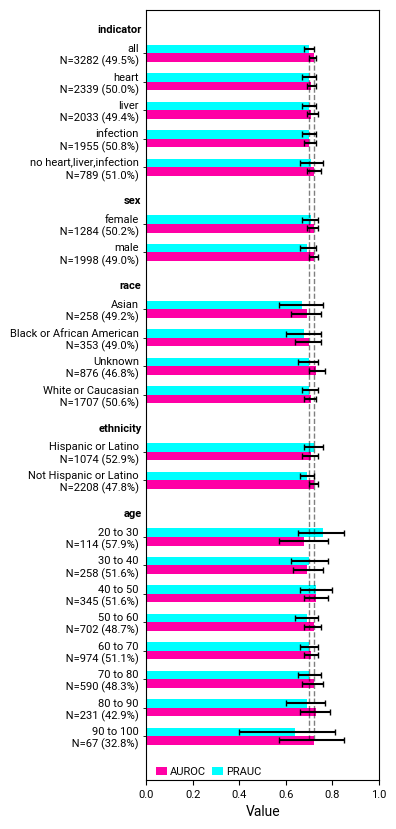

In [15]:
metric_names = ['auroc', 'ap']

run =  all_preselectall
filter = 'ucla_crrt+cedars_crrt+ucla_control'

subgroup_labels = [
              "all", "heart", "liver", "infection","no heart,liver,\ninfection",
              'female','male', 
        #       'American Indian\nor Alaska Native','Native Hawaiian or\nOther Pacific Islander','Multiple Races',
              'Asian','Black or African American','Unknown','White or Caucasian',
              'Hispanic or Latino','Not Hispanic or Latino',
              '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80','80 to 90','90 to 100'
              ]
subgroup_categories = [
              "indicator", "indicator", "indicator", "indicator","indicator",
              'sex','sex', 
        #       'race','race','race',
              'race','race','race','race',
              'ethnicity','ethnicity',
              'age','age','age','age','age','age','age','age'
              ]
plot_subgroup_onerun(metric_names,
                run, filter,
                subgroup_labels, subgroup_categories,
                full_horizon=True,
                strat=False)

ucla_to_ucla_tune100_v17ucla_crrt_subgroup


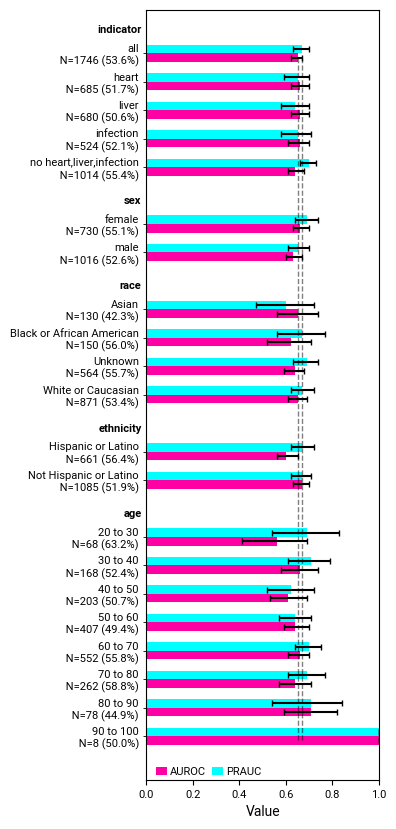

ucla_to_ucla_tune100_v17cedars_crrt_subgroup


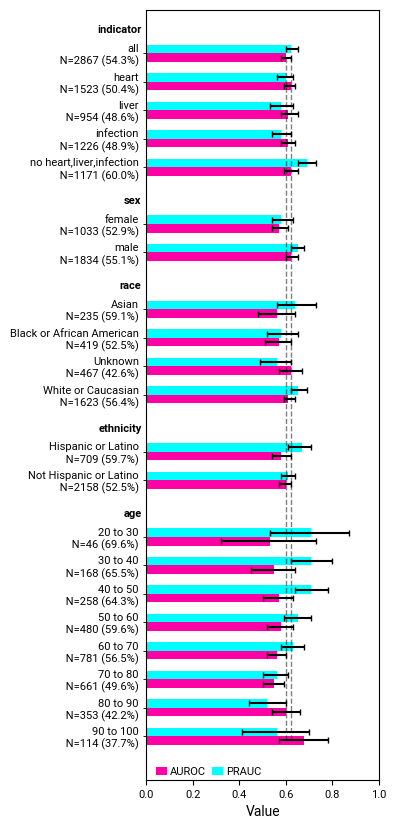

cedars_to_cedars_tune100_v17cedars_crrt_subgroup


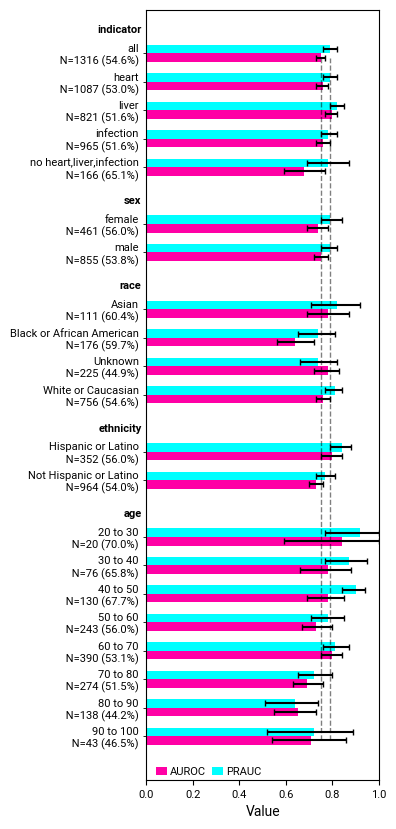

cedars_to_cedars_tune100_v17ucla_crrt_subgroup


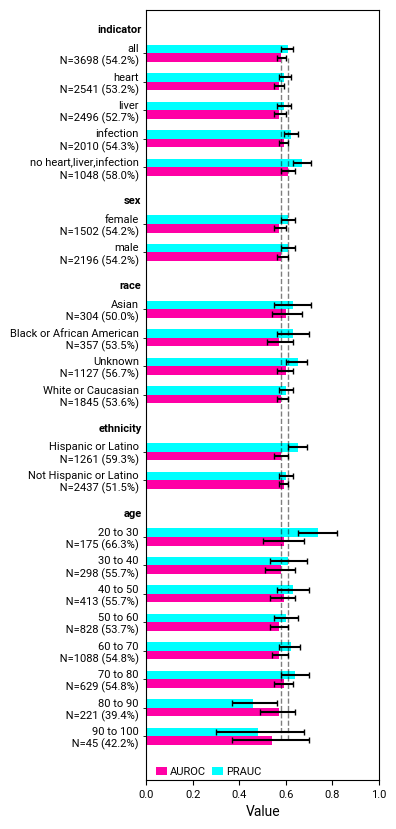

uclapluscedars_to_uclapluscedars_preselectcrrt_tune100_v17ucla_crrt+cedars_crrt_subgroup


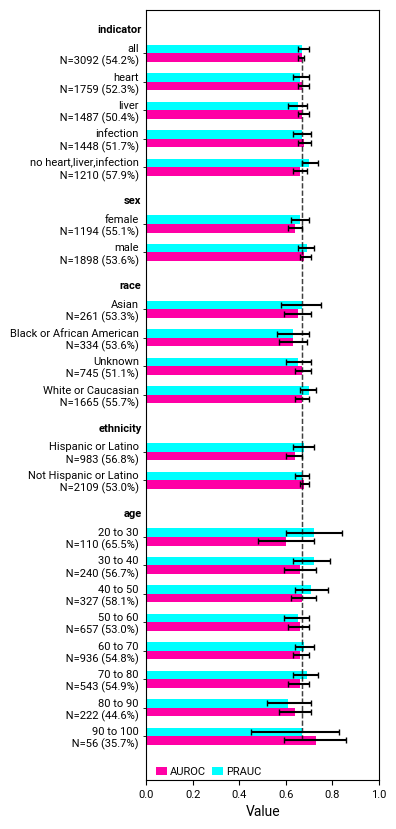

In [16]:
metric_names = ['auroc', 'ap']

run =  ucla_train
filter = 'ucla_crrt'
plot_subgroup_onerun(metric_names,
                run, filter,
                subgroup_labels, subgroup_categories,
                full_horizon=True,
                strat=False)

run =  ucla_train
filter = 'cedars_crrt'
plot_subgroup_onerun(metric_names,
                run, filter,
                subgroup_labels, subgroup_categories,
                full_horizon=True,
                strat=False)

run =  cedars_train
filter = 'cedars_crrt'
plot_subgroup_onerun(metric_names,
                run, filter,
                subgroup_labels, subgroup_categories,
                full_horizon=True,
                strat=False)

run =  cedars_train
filter = 'ucla_crrt'
plot_subgroup_onerun(metric_names,
                run, filter,
                subgroup_labels, subgroup_categories,
                full_horizon=True,
                strat=False)

run =  uclapluscedars_preselectcrrt
filter = 'ucla_crrt+cedars_crrt'
plot_subgroup_onerun(metric_names,
                run, filter,
                subgroup_labels, subgroup_categories,
                full_horizon=True,
                strat=False)

# Rolling window

## Helper functions

In [13]:
from models.static_models import METRIC_MAP
from evaluate.utils import bootstrap_metric, confidence_interval, eval_metric
from tqdm import tqdm
from collections import defaultdict

rolling_dir = os.path.join(output_dir, 'rolling')
os.makedirs(rolling_dir,exist_ok=True)

def rolling_count(runs, filters, slides):
    
    table = {}

    # get run
    for j in range(len(runs)):
        for k in tqdm(slides):
            
            if len(filters[j]) > 0:
                if k == 0:
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // post_eval_{filters[j]} best'")
                else:
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // post_eval_{filters[j]} rolling window: {k}'")
            else:
                if k == 0:
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // eval best'")
                else:
                    # run, _ = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]}' and tags.slide_window_by='{k}'")
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // rolling window: {k}'")
                        
            if k not in table.keys():
                table[k] = {}
            
            prefix = f"{run.data.tags['modeln']}_test"
            
            if 'control' not in filters[j]:
                
                prob_df, labels, _ = get_original_probabilities(exp_path, run.info.run_id, runs[j], prefix)
                total_len = len(labels)
                # total_len = len(prob_df.index.get_level_values('IP_PATIENT_ID').unique())
                table[k][f"{runs[j]} {filters[j]}"] = f"{total_len} ({labels.value_counts()[1]/total_len*100:.2f}%)"
                    
                if 'plus' in runs[j] or 'all_to_all' in runs[j]:
                    prob_df, _, _ = get_original_probabilities(exp_path, run.info.run_id, runs[j], prefix)
                    
                    # ISOLATE UCLA
                    ucla_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(UCLA_IDS)]
                    labels = ucla_prob_df['recommend_crrt']
                    total_len = len(labels)
                    # total_len = len(ucla_prob_df.index.get_level_values('IP_PATIENT_ID').unique())
                    table[k][f"{runs[j]} ucla_crrt"] = f"{total_len} ({labels.value_counts()[1]/total_len*100:.2f}%)"
                    
                    # ISOLATE CEDARS
                    cedars_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(CEDARS_IDS)]
                    labels = cedars_prob_df['recommend_crrt']
                    total_len = len(labels)
                    # total_len = len(cedars_prob_df.index.get_level_values('IP_PATIENT_ID').unique())
                    table[k][f"{runs[j]} cedars_crrt"] = f"{total_len} ({labels.value_counts()[1]/total_len*100:.2f}%)"
                             
            else:
                _, labels, _ = get_control_probabilities(exp_path, run, runs[j], prefix, slide=k)
                table[k][f"{runs[j]} {filters[j]}"] = f"{len(labels)} ({labels.value_counts()[1]/len(labels)*100:.2f}%)"
                
    return table

def rolling_tables(metric_names,
                    runs, filters, 
                     slides, 
                     subgroups,
                     bootstrap_point=True,
                     tag=''):

    for metric_name in metric_names:
        for subgroup in subgroups:
            table = get_rolling_table(metric_name, runs, filters, slides, subgroup=subgroup, bootstrap_point=bootstrap_point, tag=tag)
            display(pd.DataFrame(table))

def get_rolling_table(metric_name,
                     runs, filters, 
                     slides, 
                     subgroup="",
                     bootstrap_point=True,
                     tag=''):
    
    metric_fn = METRIC_MAP[metric_name]
    table = {}

    # get run
    for j in range(len(runs)):
        for k in tqdm(slides):
            
            if len(filters[j]) > 0:
                if k == 0:
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // post_eval_{filters[j]} best'")
                else:
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // post_eval_{filters[j]} rolling window: {k}'")
            else:
                if k == 0:
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // eval best'")
                else:
                    # run, _ = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]}' and tags.slide_window_by='{k}'")
                    run, exp_path = get_run_from_name(mlflow_path, runs[j], filter=f"tags.mlflow.runName='{runs[j]} // rolling window: {k}'")
                        
            if k not in table.keys():
                table[k] = {}
            
            metrics = run.data.metrics            
            prefix = f"{run.data.tags['modeln']}_test{subgroup}"
            
            if 'control' not in filters[j]:
            
                if f"{prefix}__{metric_name}" in metrics.keys():
                    _, labels, pred_probas = get_original_probabilities(exp_path, run.info.run_id, runs[j], prefix)
                    point_estimate = get_point_estimate(metrics[prefix+'__'+metric_name], labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point) 
                    ci_low = metrics[f"{prefix}__{metric_name}_CI_low"]
                    ci_high = metrics[f"{prefix}__{metric_name}_CI_high"]
                    table[k][f"{runs[j]} {filters[j]}"] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                else:
                    table[k][f"{runs[j]} {filters[j]}"] = "0.0 (0.0-0.0)"
                    
                if 'plus' in runs[j] or 'all_to_all' in runs[j]:
                    prob_df, _, _ = get_original_probabilities(exp_path, run.info.run_id, runs[j], prefix)
                    
                    # ISOLATE UCLA
                    ucla_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(UCLA_IDS)]
                    labels = ucla_prob_df['recommend_crrt']
                    pred_probas = ucla_prob_df[0].values
                    bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                    point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)  
                    ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                    table[k][f"{runs[j]} ucla_crrt"] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                    
                    # ISOLATE CEDARS
                    cedars_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(CEDARS_IDS)]
                    labels = cedars_prob_df['recommend_crrt']
                    pred_probas = cedars_prob_df[0].values
                    bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                    point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)  
                    ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                    table[k][f"{runs[j]} cedars_crrt"] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                             
            else:
                # GET THE CONTROL
                # try:
                _, labels, pred_probas = get_control_probabilities(exp_path, run, runs[j], prefix, slide=k)
                
                # GET METRIC
                bootstrapped_metrics = bootstrap_metric(labels,pred_probas,metric_name,metric_fn,decision_threshold=0.5,seed=42,)
                point_estimate = get_point_estimate(np.nanmean(bootstrapped_metrics), labels, pred_probas, metric_name, metric_fn, bootstrap_point=bootstrap_point)  
                ci_low, ci_high = confidence_interval(bootstrapped_metrics)
                table[k][f"{runs[j]} {filters[j]}"] = f"{point_estimate:.2f} ({ci_low:.2f}-{ci_high:.2f})"
                # except:
                #     table[k][f"{runs[j]} {filters[j]}"] = "0.0 (0.0-0.0)"
        
    with open(os.path.join(rolling_dir,f'{tag}{subgroup}{metric_name}_rolling.pkl'), 'wb') as f:
        pickle.dump(table,f)    
        
    return table

def plot_rolling(metric_names,
                runs, filters, plt_labels,
                slides, 
                subgroups, subgroup_labels,
                colors=None,
                strat=True,
                tag=''):
    
    for metric_name in metric_names:
                
        # Iterate through each subgroup
        for subgroup, subgroup_label in zip(subgroups, subgroup_labels):
            
            metric_table = defaultdict(list)
            ci_low_table = defaultdict(list)
            ci_high_table = defaultdict(list)
            
            with open(os.path.join(rolling_dir,f'{tag}{subgroup}{metric_name}_rolling.pkl'), 'rb') as f:
                table = pickle.load(f)  
                
            print(table)
           
            for run, filter in zip(runs,filters):
                for k in slides:
                    metric_table[f"{run} {filter}"].append(float(table[k][f"{run} {filter}"].split(' (')[0]))                
                    ci_low_table[f'{run} {filter}'].append(float(table[k][f"{run} {filter}"].split('(')[-1].split('-')[0]))
                    ci_high_table[f'{run} {filter}'].append(float(table[k][f"{run} {filter}"].split('-')[-1].split(')')[0]))
    
                    if ('plus' in run or 'all_to_all' in run) and 'control' not in filter and strat:
                        metric_table[f'{run} {filter} ucla_crrt'].append(float(table[k][f'{run} ucla_crrt'].split(' (')[0]))
                        ci_low_table[f'{run} {filter} ucla_crrt'].append(float(table[k][f'{run} ucla_crrt'].split('(')[-1].split('-')[0]))
                        ci_high_table[f'{run} {filter} ucla_crrt'].append(float(table[k][f'{run} ucla_crrt'].split('-')[-1].split(')')[0]))
                    
                        metric_table[f'{run} {filter} cedars_crrt'].append(float(table[k][f'{run} cedars_crrt'].split(' (')[0]))
                        ci_low_table[f'{run} {filter} cedars_crrt'].append(float(table[k][f'{run} cedars_crrt'].split('(')[-1].split('-')[0]))
                        ci_high_table[f'{run} {filter} cedars_crrt'].append(float(table[k][f'{run} cedars_crrt'].split('-')[-1].split(')')[0]))
                        
            
            # difference between value and CI bounds
            for key_ in metric_table.keys():
                ci_low_table[key_] = np.array(metric_table[key_]) - np.array(ci_low_table[key_])
                ci_high_table[key_] = np.array(ci_high_table[key_]) - np.array(metric_table[key_])
                
            
            # plot combined plots
            fig, ax = plt.subplots()
            
            width = 0.1
            multiplier = 0
            
            x = np.arange(len(slides))

            for i, key_ in enumerate(metric_table.keys()):                
                offset = width * multiplier

                # ax.bar(x + offset, grouped_metric_vals[i], width, label=plt_labels[i], yerr=[errors_low[i], errors_high[i]])

                if colors is not None:
                    plt.errorbar(x + offset, metric_table[key_], yerr=[ci_low_table[key_], ci_high_table[key_]], marker="d", linestyle='--', capsize=3, elinewidth=2,label=plt_labels[i], color=colors[i])
                else:
                    plt.errorbar(x + offset, metric_table[key_], yerr=[ci_low_table[key_], ci_high_table[key_]], marker="d", linestyle='--', capsize=3, elinewidth=2,label=plt_labels[i])
                
                multiplier += 1
            
            ax.set_xticks(x + width, slides)
            ax.set_ylabel(metric_name.replace('ap','PRAUC').upper())
            ax.set_xlabel('Days relative to start date')
            ax.set_ylim([0,1.05])
            ax.legend(loc="lower left", bbox_to_anchor=(0, 0), frameon=False)
            
            # Save figures
            name = f"{metric_name}_{subgroup_label}"
            print(name)
            fig = plt.gcf()
            fig.set_size_inches(5, 3)
            plt.savefig(os.path.join(rolling_dir,f'{name}_rolling.svg'), format='svg',  bbox_inches="tight")
            plt.show()
            plt.close()

## Window counts

In [18]:
table = rolling_count([
                          ucla_train,
                          ucla_train,
                          ucla_train,
                          cedars_train,
                          cedars_train,
                          cedars_train,
                          uclapluscedars_train,
                          uclapluscedars_train,
                          all_train
                          ], 
                         [
                          '',
                          'cedars_crrt',
                          'ucla_control',
                          '',
                          'ucla_crrt',
                          'ucla_control',
                          '',
                          'ucla_control',
                          ''
                          ],
                         [-3,-2,-1,0,1,2,3,4,5,6])
display(pd.DataFrame(table))

table = rolling_count([
                        ucla_preselectall,
                          ucla_preselectall,
                          ucla_preselectall,
                          ucla_preselectcrrt,
                          ucla_preselectcrrt,
                          cedars_preselectall,
                          cedars_preselectall,
                          cedars_preselectall,
                          cedars_preselectcrrt,
                          cedars_preselectcrrt,
                          uclapluscedars_preselectall,
                          uclapluscedars_preselectall,
                          uclapluscedars_preselectcrrt,
                          all_preselectall],
                         [
                             "",
                          "cedars_crrt",
                          "ucla_control",
                          "",
                          "cedars_crrt",
                          '',
                          'ucla_crrt',
                          'ucla_control',
                          '',
                          'ucla_crrt',
                          '',
                          'ucla_control',
                          '',
                          ''],
                         [-3,-2,-1,0,1,2,3,4,5,6])
display(pd.DataFrame(table))

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:23<00:00,  2.34s/it]


-3  \
ucla_to_ucla_tune100_v17                             317 (54.57%)   
ucla_to_ucla_tune100_v17 cedars_crrt                1080 (53.06%)   
ucla_to_ucla_tune100_v17 ucla_control                797 (21.71%)   
cedars_to_cedars_tune100_v17                         224 (54.91%)   
cedars_to_cedars_tune100_v17 ucla_crrt              1706 (53.46%)   
cedars_to_cedars_tune100_v17 ucla_control           2595 (35.14%)   
uclapluscedars_to_uclapluscedars_tune100_v17         537 (54.00%)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...   318 (53.77%)   
uclapluscedars_to_uclapluscedars_tune100_v17 ce...   219 (54.34%)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  1241 (23.37%)   
all_to_all_tune100_v17                               743 (38.22%)   
all_to_all_tune100_v17 ucla_crrt                     351 (51.28%)   
all_to_all_tune100_v17 cedars_crrt                   208 (50.00%)   

                                                               -2  \
ucla_to_ucla_tune100_v17                             331 (54.98%)   
ucla_to_ucla_tune100_v17 cedars_crrt                1217 (53.16%)   
ucla_to_ucla_tune100_v17 ucla_control                854 (21.31%)   
cedars_to_cedars_tune100_v17                         251 (56.57%)   
cedars_to_cedars_tune100_v17 ucla_crrt              1779 (53.29%)   
cedars_to_cedars_tune100_v17 ucla_control           2706 (35.03%)   
uclapluscedars_to_uclapluscedars_tune100_v17         585 (53.33%)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...   336 (53.57%)   
uclapluscedars_to_uclapluscedars_tune100_v17 ce...   249 (53.01%)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  1330 (23.46%)   
all_to_all_tune100_v17                               781 (38.80%)   
all_to_all_tune100_v17 ucla_crrt                     361 (51.25%)   
all_to_all_tune100_v17 cedars_crrt                   230 (51.30%)   

                                                               -1  \
ucla_to_ucla_tune100_v17                             364 (54.12%)   
ucla_to_ucla_tune100_v17 cedars_crrt                1417 (52.29%)   
ucla_to_ucla_tune100_v17 ucla_control                996 (19.78%)   
cedars_to_cedars_tune100_v17                         291 (56.01%)   
cedars_to_cedars_tune100_v17 ucla_crrt              1885 (53.21%)   
cedars_to_cedars_tune100_v17 ucla_control           2867 (34.98%)   
uclapluscedars_to_uclapluscedars_tune100_v17         645 (52.56%)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...   366 (53.01%)   
uclapluscedars_to_uclapluscedars_tune100_v17 ce...   279 (51.97%)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  1466 (23.12%)   
all_to_all_tune100_v17                               851 (38.78%)   
all_to_all_tune100_v17 ucla_crrt                     371 (51.48%)   
all_to_all_tune100_v17 cedars_crrt                   276 (50.36%)   

                                                                0  \
ucla_to_ucla_tune100_v17                             425 (52.24%)   
ucla_to_ucla_tune100_v17 cedars_crrt                1788 (51.62%)   
ucla_to_ucla_tune100_v17 ucla_control               1199 (18.52%)   
cedars_to_cedars_tune100_v17                         366 (54.64%)   
cedars_to_cedars_tune100_v17 ucla_crrt              2149 (51.79%)   
cedars_to_cedars_tune100_v17 ucla_control           3213 (34.64%)   
uclapluscedars_to_uclapluscedars_tune100_v17         785 (52.74%)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...   418 (52.87%)   
uclapluscedars_to_uclapluscedars_tune100_v17 ce...   367 (52.59%)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  1711 (24.20%)   
all_to_all_tune100_v17                               991 (38.75%)   
all_to_all_tune100_v17 ucla_crrt                     429 (50.82%)   
all_to_all_tune100_v17 cedars_crrt                   340 (48.82%)   

                                                                1  \
ucla_to_ucla_tune100_v17                             364 (57.14%)   
ucla_to_ucla_tune100_v17 cedars_crrt                1560 

100%|██████████| 10/10 [00:34<00:00,  3.47s/it]


-3  \
ucla_to_ucla_preselectall_tune100_v17                326 (55.21%)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   1086 (53.13%)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control   898 (20.04%)   
ucla_to_ucla_preselectcrrt_tune100_v17               317 (54.57%)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  1080 (53.06%)   
cedars_to_cedars_preselectall_tune100_v17            224 (54.91%)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  1706 (53.46%)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  2595 (35.14%)   
cedars_to_cedars_preselectcrrt_tune100_v17           224 (54.91%)   
cedars_to_cedars_preselectcrrt_tune100_v17 ucla...  1706 (53.46%)   
uclapluscedars_to_uclapluscedars_preselectall_t...   528 (51.33%)   
uclapluscedars_to_uclapluscedars_preselectall_t...   310 (52.58%)   
uclapluscedars_to_uclapluscedars_preselectall_t...   218 (49.54%)   
uclapluscedars_to_uclapluscedars_preselectall_t...  1156 (23.44%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...   537 (54.00%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...   318 (53.77%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...   219 (54.34%)   
all_to_all_preselectall_tune100_v17                  743 (38.22%)   
all_to_all_preselectall_tune100_v17 ucla_crrt        351 (51.28%)   
all_to_all_preselectall_tune100_v17 cedars_crrt      208 (50.00%)   

                                                               -2  \
ucla_to_ucla_preselectall_tune100_v17                336 (54.46%)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   1223 (53.15%)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control   943 (19.41%)   
ucla_to_ucla_preselectcrrt_tune100_v17               331 (54.98%)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  1217 (53.16%)   
cedars_to_cedars_preselectall_tune100_v17            251 (56.57%)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  1779 (53.29%)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  2706 (35.03%)   
cedars_to_cedars_preselectcrrt_tune100_v17           251 (56.57%)   
cedars_to_cedars_preselectcrrt_tune100_v17 ucla...  1779 (53.29%)   
uclapluscedars_to_uclapluscedars_preselectall_t...   566 (52.30%)   
uclapluscedars_to_uclapluscedars_preselectall_t...   324 (53.70%)   
uclapluscedars_to_uclapluscedars_preselectall_t...   242 (50.41%)   
uclapluscedars_to_uclapluscedars_preselectall_t...  1241 (23.85%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...   585 (53.33%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...   336 (53.57%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...   249 (53.01%)   
all_to_all_preselectall_tune100_v17                  781 (38.80%)   
all_to_all_preselectall_tune100_v17 ucla_crrt        361 (51.25%)   
all_to_all_preselectall_tune100_v17 cedars_crrt      230 (51.30%)   

                                                               -1  \
ucla_to_ucla_preselectall_tune100_v17                363 (54.27%)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   1419 (52.29%)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control  1060 (18.58%)   
ucla_to_ucla_preselectcrrt_tune100_v17               364 (54.12%)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  1417 (52.29%)   
cedars_to_cedars_preselectall_tune100_v17            291 (56.01%)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  1885 (53.21%)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  2867 (34.98%)   
cedars_to_cedars_preselectcrrt_tune100_v17           291 (56.01%)   
cedars_to_cedars_preselectcrrt_tune100_v17 ucla...  1885 (53.21%)   
uclapluscedars_to_uclapluscedars_preselectall_t...   636 (52.20%)   
uclapluscedars_to_uclapluscedars_preselectall_t...   348 (54.60%)   
uclapluscedars_to_uclapluscedars_preselectall_t...   288 (49.31%)   
uclapluscedars_to_uclapluscedars_preselectall_t...  1381 (24.04%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...   645 (52.56%)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...   366 (5

## Process windows

In [20]:

metric_names = ['auroc','ap']
runs = [
        ucla_train,
        ucla_train,
        ucla_train,
        cedars_train,
        cedars_train,
        cedars_train,
        uclapluscedars_train,
        uclapluscedars_train,
        all_train,
        ucla_preselectall,
        ucla_preselectall,
        ucla_preselectall,
        ucla_preselectcrrt,
        ucla_preselectcrrt,
        cedars_preselectall,
        cedars_preselectall,
        cedars_preselectall,
        cedars_preselectcrrt,
        cedars_preselectcrrt,
        uclapluscedars_preselectall,
        uclapluscedars_preselectall,
        uclapluscedars_preselectcrrt,
        all_preselectall
        ]
filters = [
        '',
        'cedars_crrt',
        'ucla_control',
        '',
        'ucla_crrt',
        'ucla_control',
        '',
        'ucla_control',
        '',
        "",
        "cedars_crrt",
        "ucla_control",
        "",
        "cedars_crrt",
        '',
        'ucla_crrt',
        'ucla_control',
        '',
        'ucla_crrt',
        '',
        'ucla_control',
        '',
        ''
        ]
slides = [-3,-2,-1,0,1,2,3,4,5,6]
subgroups =  [""]
subgroup_labels = ["all"]
# subgroups = ["", "_heart"]
plt_labels = ["Test", "External test"]

rolling_tables(metric_names,
                runs, filters, 
                slides, 
                subgroups,
                bootstrap_point=True,
                tag='tune100')
                    

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:08<00:00,  6.88s/it]


-3  \
ucla_to_ucla_tune100_v17                            0.69 (0.63-0.75)   
ucla_to_ucla_tune100_v17 cedars_crrt                0.61 (0.58-0.65)   
ucla_to_ucla_tune100_v17 ucla_control               0.64 (0.59-0.68)   
cedars_to_cedars_tune100_v17                        0.74 (0.68-0.81)   
cedars_to_cedars_tune100_v17 ucla_crrt              0.57 (0.55-0.60)   
cedars_to_cedars_tune100_v17 ucla_control           0.51 (0.49-0.53)   
uclapluscedars_to_uclapluscedars_tune100_v17        0.75 (0.72-0.79)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.76 (0.71-0.81)   
uclapluscedars_to_uclapluscedars_tune100_v17 ce...  0.75 (0.69-0.81)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.68 (0.64-0.71)   
all_to_all_tune100_v17                              0.84 (0.81-0.87)   
all_to_all_tune100_v17 ucla_crrt                    0.73 (0.67-0.78)   
all_to_all_tune100_v17 cedars_crrt                  0.80 (0.74-0.85)   
ucla_to_ucla_preselectall_tune100_v17               0.73 (0.68-0.79)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   0.53 (0.50-0.56)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control  0.67 (0.62-0.71)   
ucla_to_ucla_preselectcrrt_tune100_v17              0.70 (0.64-0.76)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  0.55 (0.52-0.59)   
cedars_to_cedars_preselectall_tune100_v17           0.73 (0.66-0.79)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.58 (0.55-0.60)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.53 (0.51-0.55)   
cedars_to_cedars_preselectcrrt_tune100_v17          0.73 (0.66-0.79)   
cedars_to_cedars_preselectcrrt_tune100_v17 ucla...  0.59 (0.56-0.62)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.70 (0.66-0.74)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.72 (0.67-0.77)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.67 (0.59-0.74)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.66 (0.62-0.70)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.73 (0.69-0.78)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.74 (0.69-0.79)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.72 (0.66-0.79)   
all_to_all_preselectall_tune100_v17                 0.81 (0.77-0.84)   
all_to_all_preselectall_tune100_v17 ucla_crrt       0.69 (0.63-0.75)   
all_to_all_preselectall_tune100_v17 cedars_crrt     0.75 (0.68-0.80)   

                                                                  -2  \
ucla_to_ucla_tune100_v17                            0.71 (0.66-0.77)   
ucla_to_ucla_tune100_v17 cedars_crrt                0.60 (0.57-0.63)   
ucla_to_ucla_tune100_v17 ucla_control               0.64 (0.59-0.68)   
cedars_to_cedars_tune100_v17                        0.72 (0.66-0.79)   
cedars_to_cedars_tune100_v17 ucla_crrt              0.58 (0.55-0.60)   
cedars_to_cedars_tune100_v17 ucla_control           0.51 (0.49-0.53)   
uclapluscedars_to_uclapluscedars_tune100_v17        0.77 (0.74-0.81)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.80 (0.75-0.84)   
uclapluscedars_to_uclapluscedars_tune100_v17 ce...  0.74 (0.68-0.80)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.69 (0.65-0.72)   
all_to_all_tune100_v17                              0.84 (0.82-0.87)   
all_to_all_tune100_v17 ucla_crrt                    0.75 (0.69-0.79)   
all_to_all_tune100_v17 cedars_crrt                  0.78 (0.72-0.83)   
ucla_to_ucla_preselectall_tune100_v17               0.74 (0.69-0.79)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   0.56 (0.53-0.59)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control  0.67 (0.63-0.72)   
ucla_to_ucla_preselectcrrt_tune100_v17              0.72 (0.67-0.78)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  0.56 (0.52-0.59)   
cedars_to_cedars_preselectall_tune100_v17           0.71 (0.64-0.77)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.58 (0.55-0.60)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.53 (0.51-0.55)   
cedars_to_cedars_preselectcrrt_tu

100%|██████████| 10/10 [01:06<00:00,  6.65s/it]


-3  \
ucla_to_ucla_tune100_v17                            0.73 (0.65-0.79)   
ucla_to_ucla_tune100_v17 cedars_crrt                0.63 (0.59-0.67)   
ucla_to_ucla_tune100_v17 ucla_control               0.32 (0.26-0.38)   
cedars_to_cedars_tune100_v17                        0.79 (0.71-0.85)   
cedars_to_cedars_tune100_v17 ucla_crrt              0.62 (0.59-0.66)   
cedars_to_cedars_tune100_v17 ucla_control           0.37 (0.34-0.39)   
uclapluscedars_to_uclapluscedars_tune100_v17        0.79 (0.74-0.83)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.80 (0.74-0.85)   
uclapluscedars_to_uclapluscedars_tune100_v17 ce...  0.79 (0.71-0.86)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.38 (0.33-0.44)   
all_to_all_tune100_v17                              0.77 (0.72-0.82)   
all_to_all_tune100_v17 ucla_crrt                    0.77 (0.71-0.83)   
all_to_all_tune100_v17 cedars_crrt                  0.80 (0.71-0.87)   
ucla_to_ucla_preselectall_tune100_v17               0.77 (0.70-0.83)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   0.57 (0.53-0.61)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control  0.33 (0.27-0.39)   
ucla_to_ucla_preselectcrrt_tune100_v17              0.72 (0.65-0.79)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  0.59 (0.56-0.64)   
cedars_to_cedars_preselectall_tune100_v17           0.77 (0.68-0.84)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.62 (0.58-0.65)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.36 (0.33-0.39)   
cedars_to_cedars_preselectcrrt_tune100_v17          0.78 (0.69-0.84)   
cedars_to_cedars_preselectcrrt_tune100_v17 ucla...  0.62 (0.58-0.65)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.73 (0.67-0.78)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.76 (0.70-0.82)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.67 (0.57-0.76)   
uclapluscedars_to_uclapluscedars_preselectall_t...  0.34 (0.29-0.39)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.77 (0.72-0.81)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.78 (0.72-0.83)   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  0.77 (0.69-0.84)   
all_to_all_preselectall_tune100_v17                 0.73 (0.68-0.78)   
all_to_all_preselectall_tune100_v17 ucla_crrt       0.74 (0.68-0.80)   
all_to_all_preselectall_tune100_v17 cedars_crrt     0.76 (0.67-0.83)   

                                                                  -2  \
ucla_to_ucla_tune100_v17                            0.75 (0.69-0.81)   
ucla_to_ucla_tune100_v17 cedars_crrt                0.62 (0.58-0.66)   
ucla_to_ucla_tune100_v17 ucla_control               0.33 (0.27-0.40)   
cedars_to_cedars_tune100_v17                        0.78 (0.71-0.84)   
cedars_to_cedars_tune100_v17 ucla_crrt              0.62 (0.59-0.66)   
cedars_to_cedars_tune100_v17 ucla_control           0.37 (0.34-0.40)   
uclapluscedars_to_uclapluscedars_tune100_v17        0.81 (0.76-0.85)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.83 (0.78-0.88)   
uclapluscedars_to_uclapluscedars_tune100_v17 ce...  0.78 (0.72-0.85)   
uclapluscedars_to_uclapluscedars_tune100_v17 uc...  0.39 (0.34-0.44)   
all_to_all_tune100_v17                              0.79 (0.74-0.83)   
all_to_all_tune100_v17 ucla_crrt                    0.79 (0.73-0.84)   
all_to_all_tune100_v17 cedars_crrt                  0.80 (0.72-0.87)   
ucla_to_ucla_preselectall_tune100_v17               0.77 (0.70-0.83)   
ucla_to_ucla_preselectall_tune100_v17 cedars_crrt   0.59 (0.55-0.63)   
ucla_to_ucla_preselectall_tune100_v17 ucla_control  0.32 (0.26-0.38)   
ucla_to_ucla_preselectcrrt_tune100_v17              0.75 (0.69-0.81)   
ucla_to_ucla_preselectcrrt_tune100_v17 cedars_crrt  0.59 (0.55-0.63)   
cedars_to_cedars_preselectall_tune100_v17           0.76 (0.69-0.83)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.62 (0.58-0.65)   
cedars_to_cedars_preselectall_tune100_v17 ucla_...  0.37 (0.34-0.39)   
cedars_to_cedars_preselectcrrt_tu

## Plot rolling windows

{-3: {'ucla_to_ucla_tune100_v17 ': '0.73 (0.65-0.79)', 'ucla_to_ucla_tune100_v17 cedars_crrt': '0.63 (0.59-0.67)', 'ucla_to_ucla_tune100_v17 ucla_control': '0.32 (0.26-0.38)', 'cedars_to_cedars_tune100_v17 ': '0.79 (0.71-0.85)', 'cedars_to_cedars_tune100_v17 ucla_crrt': '0.62 (0.59-0.66)', 'cedars_to_cedars_tune100_v17 ucla_control': '0.37 (0.34-0.39)', 'uclapluscedars_to_uclapluscedars_tune100_v17 ': '0.79 (0.74-0.83)', 'uclapluscedars_to_uclapluscedars_tune100_v17 ucla_crrt': '0.80 (0.74-0.85)', 'uclapluscedars_to_uclapluscedars_tune100_v17 cedars_crrt': '0.79 (0.71-0.86)', 'uclapluscedars_to_uclapluscedars_tune100_v17 ucla_control': '0.38 (0.33-0.44)', 'all_to_all_tune100_v17 ': '0.77 (0.72-0.82)', 'all_to_all_tune100_v17 ucla_crrt': '0.77 (0.71-0.83)', 'all_to_all_tune100_v17 cedars_crrt': '0.80 (0.71-0.87)', 'ucla_to_ucla_preselectall_tune100_v17 ': '0.77 (0.70-0.83)', 'ucla_to_ucla_preselectall_tune100_v17 cedars_crrt': '0.57 (0.53-0.61)', 'ucla_to_ucla_preselectall_tune100_v17 u

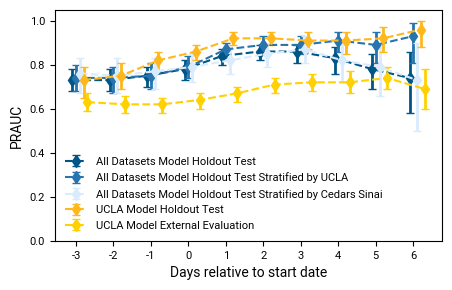

{-3: {'ucla_to_ucla_tune100_v17 ': '0.69 (0.63-0.75)', 'ucla_to_ucla_tune100_v17 cedars_crrt': '0.61 (0.58-0.65)', 'ucla_to_ucla_tune100_v17 ucla_control': '0.64 (0.59-0.68)', 'cedars_to_cedars_tune100_v17 ': '0.74 (0.68-0.81)', 'cedars_to_cedars_tune100_v17 ucla_crrt': '0.57 (0.55-0.60)', 'cedars_to_cedars_tune100_v17 ucla_control': '0.51 (0.49-0.53)', 'uclapluscedars_to_uclapluscedars_tune100_v17 ': '0.75 (0.72-0.79)', 'uclapluscedars_to_uclapluscedars_tune100_v17 ucla_crrt': '0.76 (0.71-0.81)', 'uclapluscedars_to_uclapluscedars_tune100_v17 cedars_crrt': '0.75 (0.69-0.81)', 'uclapluscedars_to_uclapluscedars_tune100_v17 ucla_control': '0.68 (0.64-0.71)', 'all_to_all_tune100_v17 ': '0.84 (0.81-0.87)', 'all_to_all_tune100_v17 ucla_crrt': '0.73 (0.67-0.78)', 'all_to_all_tune100_v17 cedars_crrt': '0.80 (0.74-0.85)', 'ucla_to_ucla_preselectall_tune100_v17 ': '0.73 (0.68-0.79)', 'ucla_to_ucla_preselectall_tune100_v17 cedars_crrt': '0.53 (0.50-0.56)', 'ucla_to_ucla_preselectall_tune100_v17 u

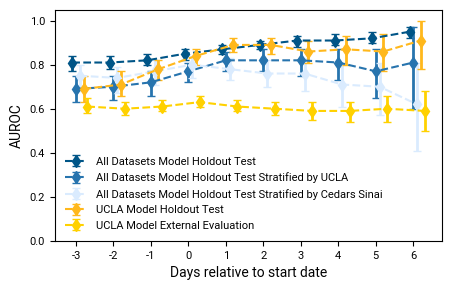

In [22]:
slides = [-3,-2,-1,0,1,2,3,4,5,6]
metric_names = ['ap','auroc']
plt_labels = ['All Datasets Model Holdout Test',
              'All Datasets Model Holdout Test Stratified by UCLA',
              'All Datasets Model Holdout Test Stratified by Cedars Sinai', 
              'UCLA Model Holdout Test', 
              "UCLA Model External Evaluation"]
colors = ['#005587','#2774AE', '#DAEBFE', '#FFB81C', '#FFD100']
runs = [all_preselectall, ucla_train, ucla_train]
filters = ['', '', 'cedars_crrt']

plot_rolling(metric_names,
                runs, filters, plt_labels,
                slides, 
                [""],subgroup_labels = ["all"],
                colors=colors,
                tag='tune100',
                strat=True)

# plt_labels = ['Combined Dsets Model']
# runs = [all_preselectall]
# filters = ['']

# plot_rolling(metric_names,
#                 runs, filters, plt_labels,
#                 slides, 
#                 [""],subgroup_labels = ["all"],
#                 tag='tune50',
#                 strat=False)

{-3: {'ucla_to_ucla_tune100_v17 ': '0.73 (0.65-0.79)', 'ucla_to_ucla_tune100_v17 cedars_crrt': '0.63 (0.59-0.67)', 'ucla_to_ucla_tune100_v17 ucla_control': '0.32 (0.26-0.38)', 'cedars_to_cedars_tune100_v17 ': '0.79 (0.71-0.85)', 'cedars_to_cedars_tune100_v17 ucla_crrt': '0.62 (0.59-0.66)', 'cedars_to_cedars_tune100_v17 ucla_control': '0.37 (0.34-0.39)', 'uclapluscedars_to_uclapluscedars_tune100_v17 ': '0.79 (0.74-0.83)', 'uclapluscedars_to_uclapluscedars_tune100_v17 ucla_crrt': '0.80 (0.74-0.85)', 'uclapluscedars_to_uclapluscedars_tune100_v17 cedars_crrt': '0.79 (0.71-0.86)', 'uclapluscedars_to_uclapluscedars_tune100_v17 ucla_control': '0.38 (0.33-0.44)', 'all_to_all_tune100_v17 ': '0.77 (0.72-0.82)', 'all_to_all_tune100_v17 ucla_crrt': '0.77 (0.71-0.83)', 'all_to_all_tune100_v17 cedars_crrt': '0.80 (0.71-0.87)', 'ucla_to_ucla_preselectall_tune100_v17 ': '0.77 (0.70-0.83)', 'ucla_to_ucla_preselectall_tune100_v17 cedars_crrt': '0.57 (0.53-0.61)', 'ucla_to_ucla_preselectall_tune100_v17 u

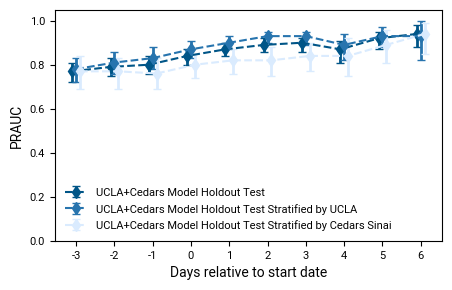

{-3: {'ucla_to_ucla_tune100_v17 ': '0.73 (0.65-0.79)', 'ucla_to_ucla_tune100_v17 cedars_crrt': '0.63 (0.59-0.67)', 'ucla_to_ucla_tune100_v17 ucla_control': '0.32 (0.26-0.38)', 'cedars_to_cedars_tune100_v17 ': '0.79 (0.71-0.85)', 'cedars_to_cedars_tune100_v17 ucla_crrt': '0.62 (0.59-0.66)', 'cedars_to_cedars_tune100_v17 ucla_control': '0.37 (0.34-0.39)', 'uclapluscedars_to_uclapluscedars_tune100_v17 ': '0.79 (0.74-0.83)', 'uclapluscedars_to_uclapluscedars_tune100_v17 ucla_crrt': '0.80 (0.74-0.85)', 'uclapluscedars_to_uclapluscedars_tune100_v17 cedars_crrt': '0.79 (0.71-0.86)', 'uclapluscedars_to_uclapluscedars_tune100_v17 ucla_control': '0.38 (0.33-0.44)', 'all_to_all_tune100_v17 ': '0.77 (0.72-0.82)', 'all_to_all_tune100_v17 ucla_crrt': '0.77 (0.71-0.83)', 'all_to_all_tune100_v17 cedars_crrt': '0.80 (0.71-0.87)', 'ucla_to_ucla_preselectall_tune100_v17 ': '0.77 (0.70-0.83)', 'ucla_to_ucla_preselectall_tune100_v17 cedars_crrt': '0.57 (0.53-0.61)', 'ucla_to_ucla_preselectall_tune100_v17 u

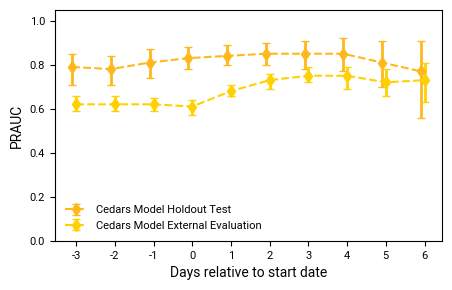

In [14]:
slides = [-3,-2,-1,0,1,2,3,4,5,6]
metric_names = ['ap']
plt_labels = ['UCLA+Cedars Model Holdout Test',
              'UCLA+Cedars Model Holdout Test Stratified by UCLA',
              'UCLA+Cedars Model Holdout Test Stratified by Cedars Sinai'
              ]
colors = ['#005587','#2774AE', '#DAEBFE', '#FFB81C', '#FFD100']
runs = [uclapluscedars_preselectcrrt]
filters = ['']

plot_rolling(metric_names,
                runs, filters, plt_labels,
                slides, 
                [""],subgroup_labels = ["all"],
                colors=colors,
                tag='tune100',
                strat=True)

slides = [-3,-2,-1,0,1,2,3,4,5,6]
metric_names = ['ap']
plt_labels = ['Cedars Model Holdout Test', "Cedars Model External Evaluation"]
colors = [ '#FFB81C', '#FFD100']
runs = [cedars_train, cedars_train]
filters = ['','ucla_crrt']

plot_rolling(metric_names,
                runs, filters, plt_labels,
                slides, 
                [""],subgroup_labels = ["all"],
                colors=colors,
                tag='tune100',
                strat=True)

# Clinical impact

In [23]:
from sklearn.metrics import auc, det_curve, confusion_matrix

clinical_impact_dir = os.path.join(output_dir,'clinical_impact')
os.makedirs(clinical_impact_dir, exist_ok=True)

def get_cost(prob_df, threshold, price=True):
    
    prices = [543, 3486*0.76/7, 5177*0.76/7, 276.70*1.11, 2607*0.76/7,3089*0.76/7,436*1.11, 3629.80, 1100*0.76, 3700*0.76]
    
    # GET FN AND TN patients 
    # labels = prob_df['recommend_crrt']
    # pred_probas = prob_df[0].values
    
    prob_df['pred'] = (prob_df[0] >= threshold).astype(int)
    prob_df['TN'] = ((prob_df['pred']==0)&(prob_df['recommend_crrt']==0)).astype(int)
    
    # GET CRRT_TOTAL_DAYS for the selected patients
    days = pd.merge(prob_df, pd.concat([OUTCOMES_UCLA, OUTCOMES_CEDARS]), how='left', on=['IP_PATIENT_ID','Start Date'])
    days = days[days['TN']==1]
    
    # sum total days
    total_days_saved = days['CRRT Total Days'].sum() #/ len(days)
    if total_days_saved != total_days_saved:
        total_days_saved = 0
    
    # multuply by cost
    if price:
        return total_days_saved*np.mean(prices)
    else:
        return total_days_saved

def get_spending(prob_df, threshold, price=True):
    
    prices = [543, 3486*0.76/7, 5177*0.76/7, 276.70*1.11, 2607*0.76/7,3089*0.76/7,436*1.11, 3629.80, 1100*0.76, 3700*0.76]
    
    # GET TP AND FP patients 
    # labels = prob_df['recommend_crrt']
    # pred_probas = prob_df[0].values
    
    prob_df['pred'] = (prob_df[0] >= threshold).astype(int)
    prob_df['TP'] = ((prob_df['pred']==1)&(prob_df['recommend_crrt']==1)).astype(int)
    
    # GET CRRT_TOTAL_DAYS for the selected patients
    days = pd.merge(prob_df, pd.concat([OUTCOMES_UCLA, OUTCOMES_CEDARS]), how='left', on=['IP_PATIENT_ID','Start Date'])
    days = days[days['TP']==1]
    
    # sum total days
    total_days_saved = days['CRRT Total Days'].sum() #/ len(days)
    if total_days_saved != total_days_saved:
        total_days_saved = 0
    
    # multuply by cost
    if price:
        return total_days_saved*np.mean(prices)
    else:
        return total_days_saved
    
                    
def create_matrix(metric_names, metric_fns, prob_df, labels, pred_probas,grouping_labels, control_probas, price):
    conf_matrix_values = {metric: [] for metric in metric_names}
    
    if len(control_probas) > 0:
        conf_matrix_values['CONTROL_P'] = [0]
        conf_matrix_values['CONTROL_N'] = [len(control_probas)]
    savings = [np.nan]
    spendings = [np.nan]
    
    # Current clinical practice
    for metric_name, metric_fn in zip(metric_names,metric_fns):
        conf_matrix_values[metric_name].append(metric_fn(labels, labels, 0.5))
    conf_matrix_values['FP'] = conf_matrix_values['TN']
    conf_matrix_values['TN'] = [0]
    
    # Search for good threshold (FN=0 or FN=2)
    fpr, fnr, thresholds = det_curve(labels, pred_probas)
    use_thresh = []
    
    # FNs = [0,2]
    # curr = 0
    # for threshold in sorted(thresholds):
    #     if confusion_matrix(labels, (pred_probas >= threshold).astype(int))[1, 0] >= FNs[curr]:
    #         use_thresh.append(threshold)
    #         curr+=1
        
    #     # if confusion_matrix(labels, (pred_probas >= threshold).astype(int))[1, 0] > FNs[curr] and len(use_thresh) < 2:
    #     #     use_thresh.append(threshold)
            
    #     if len(use_thresh) == 2:
    #         break
        
    use_thresh = [0,0.25,0.5,0.75,1.0]
    grouping_labels = grouping_labels + [str(thresh) for thresh in use_thresh]
    
    for k in range(len(use_thresh)):
        for metric_name, metric_fn in zip(metric_names,metric_fns):
            conf_matrix_values[metric_name].append(metric_fn(labels, pred_probas, use_thresh[k]))
            
        if len(control_probas) > 0:
            conf_matrix_values['CONTROL_P'].append((control_probas >= use_thresh[k]).sum())
            conf_matrix_values['CONTROL_N'].append((control_probas < use_thresh[k]).sum())
    
        savings.append(get_cost(prob_df, use_thresh[k], price))
        spendings.append(get_spending(prob_df, use_thresh[k], price))
    # Decision threshold = 0.5
    # for metric_name, metric_fn in zip(metric_names,metric_fns):
    #     conf_matrix_values[metric_name].append(metric_fn(labels, pred_probas, 0.5))
    # savings.append(get_cost(prob_df, 0.5, price))
    return conf_matrix_values,savings,spendings,grouping_labels

def plot_clinical_impact(grouping_labels,
                         conf_matrix_values, savings,spendings,
                         plt_label, 
                         subgroup_label, 
                         colors,conf_matrix_label,conf_matrix_baseline_label,
                         price=True):
    fig, ax = plt.subplots()
    bottom = np.zeros(len(grouping_labels)-1)
    bottom_baseline = 0

    if 'CONTROL_N' in conf_matrix_values.keys():
        p = ax.bar(grouping_labels[0], conf_matrix_values['CONTROL_N'][0], 0.75, label='Not put on CRRT, should not have been put on CRRT (control)', bottom=bottom_baseline, edgecolor='black',linestyle='--',color='#8237FF', alpha=0.5)
        bottom_baseline += conf_matrix_values['CONTROL_N'][0]
        labels = [int(v) if v > 2 else "" for v in p.datavalues]    
        ax.bar_label(p, labels=labels, label_type="center")
    
    # current standard
    for k, metric_name in enumerate(metric_names):
        data = conf_matrix_values[metric_name]
        if data[0] > 0:
            p = ax.bar(grouping_labels[0], data[0], 0.75, label=conf_matrix_baseline_label[k], bottom=bottom_baseline, edgecolor='black',linestyle='--',color=colors[k], alpha=0.5)
            bottom_baseline += data[0]
            labels = [int(v) if v > 2 else "" for v in p.datavalues]    
            ax.bar_label(p, labels=labels, label_type="center")
    
    # Control
    if 'CONTROL_N' in conf_matrix_values.keys():
        p = ax.bar(grouping_labels[1:], conf_matrix_values['CONTROL_P'][1:], 0.75, label='Recommend CRRT, should not have been put on CRRT (control)', bottom=bottom, color='#FF00A5')
        bottom += conf_matrix_values['CONTROL_P'][1:]
        labels = [int(v) if v > 2 else "" for v in p.datavalues]    
        ax.bar_label(p, labels=labels, label_type="center")
        
        p = ax.bar(grouping_labels[1:], conf_matrix_values['CONTROL_N'][1:], 0.75, label='Do not recommend CRRT, should not be put on CRRT (control)', bottom=bottom, color='#00FFFF')
        bottom += conf_matrix_values['CONTROL_N'][1:]
        labels = [int(v) if v > 2 else "" for v in p.datavalues]    
        ax.bar_label(p, labels=labels, label_type="center")
    
    
    # different thresholds
    for k, metric_name in enumerate(metric_names):
        
        p = ax.bar(grouping_labels[1:], conf_matrix_values[metric_name][1:], 0.75, label=conf_matrix_label[k], bottom=bottom, color=colors[k])
        bottom += conf_matrix_values[metric_name][1:]

        labels = [int(v) if v > 2 else "" for v in p.datavalues]    
        ax.bar_label(p, labels=labels, label_type="center")
    

    ax.set_xlabel('Clinical ML decision threshold')
    ax.xaxis.set_label_coords(0.6, -0.15)
    ax.set_ylim([0,bottom_baseline+0.05*bottom_baseline])

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    # if price:
    #     ax2.set_ylabel('Estimated total cost savings ($)', color='#FF00A5')  # we already handled the x-label with ax1
    # else:
    #     ax2.set_ylabel('Estimated number CRRT days saved', color='#FF00A5')  # we already handled the x-label with ax1
    # ax2.tick_params(axis='y', labelcolor='#FF00A5')
    
    if price:
        ax2.set_ylabel('Estimated total cost')  # we already handled the x-label with ax1
    else:
        ax2.set_ylabel('Estimated number of CRRT days')  # we already handled the x-label with ax1
    ax2.tick_params(axis='y')
    print(savings)

    # ax2.errorbar(grouping_labels, spendings, color='#00FF87, alpha=0.5)
    # ax2.errorbar(grouping_labels, savings, color='#FF00A5', alpha=0.5)
    
    ax2.errorbar(grouping_labels, spendings, color='black', alpha=0.5,linewidth=2.1, )
    ax2.errorbar(grouping_labels, spendings, color=colors[0],label='Recommended beneficial days',linewidth=2, alpha=0.75)
    
    ax2.errorbar(grouping_labels, savings, color='black', alpha=0.5,linewidth=2.1, )
    ax2.errorbar(grouping_labels, savings, color=colors[2],label='Avoided non-beneficial days',linewidth=2,alpha=0.75)
    
    ax2.set_ylim([0, np.nanmax(savings + spendings)+0.1*np.nanmax(savings + spendings)])
    
    
    # ax.set_title(f"Clinical impact_{subgroup_labels[i]}_{plt_labels[j]}")
    print(f"Clinical impact_{subgroup_label}_{plt_label}")
    
    # if 'CONTROL_N' in conf_matrix_values.keys():
    # ax2.legend(loc='upper left', bbox_to_anchor=(0.6, -0.25),
    # fancybox=False, shadow=False, ncol=2, frameon=False)
    # ax.legend(loc='upper left', bbox_to_anchor=(-0.05, -0.25),
    # fancybox=False, shadow=False, ncol=2, frameon=False)
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2,loc='upper left', bbox_to_anchor=(-0.1, -0.25),
    fancybox=False, shadow=False, ncol=2, frameon=False )

    ax.set_ylabel("Patient counts")
    fig = plt.gcf()
    fig.set_size_inches(5,3)
    plt.savefig(os.path.join(clinical_impact_dir,f'Clinical impact_{subgroup_label}_{plt_label}.svg'), format='svg',  bbox_inches="tight")
    plt.show()
    plt.close()
    
def process_and_plot_clinical_impact(metric_names, metric_fns, 
                         runs, filters, plt_labels, 
                         subgroups, subgroup_labels, 
                         colors,conf_matrix_label,conf_matrix_baseline_label,
                         full_horizon=True,price=True, strat=False):

    for subgroup, subgroup_label in zip(subgroups, subgroup_labels):
        print(subgroup)

        for run_name, filter, plt_label in zip(runs,filters,plt_labels):
            
            if len(filter) > 0:
                if full_horizon and filter != 'ucla_control':
                    run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter}_200 best'")
                else:
                    run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
            else:
                run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // eval best'")

            prefix = f"{run.data.tags['modeln']}_test{subgroup}"
            
            if filter != 'ucla_control':
                prob_df, labels, pred_probas = get_original_probabilities(exp_path, run.info.run_id, run_name, prefix)
            else:
                prob_df, labels, pred_probas = get_control_probabilities(exp_path, run, run_name, prefix, full_horizon=full_horizon)
                    
            # print(len(prob_df))
            control_probas = prob_df[~prob_df.index.get_level_values('IP_PATIENT_ID').isin(list(UCLA_IDS)+list(CEDARS_IDS))].copy()[0].values
            prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(list(UCLA_IDS)+list(CEDARS_IDS))].copy()
            # print(len(prob_df))
            labels = prob_df['recommend_crrt']
            pred_probas = prob_df[0].values
                
            grouping_labels = ['Current\nStandard']
            
            conf_matrix_values,savings,spendings,grouping_labels = create_matrix(metric_names, metric_fns, prob_df, labels, pred_probas,grouping_labels, control_probas, price)
            print(grouping_labels)
            plot_clinical_impact(grouping_labels, conf_matrix_values,savings,spendings,
                                 plt_label, 
                                subgroup_label, 
                                colors,conf_matrix_label,conf_matrix_baseline_label,
                                price=price)
        
            if ('plus' in run_name or 'all_to_all' in run_name) and strat:
                
                ucla_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(UCLA_IDS)].copy()
                labels = ucla_prob_df['recommend_crrt']
                pred_probas = ucla_prob_df[0].values
                
                conf_matrix_values,savings,grouping_labels = create_matrix(metric_names, metric_fns, ucla_prob_df, labels, pred_probas,grouping_labels, price)
            
                plot_clinical_impact(grouping_labels, conf_matrix_values,savings,
                                    plt_label + ' Strat. UCLA', 
                                    subgroup_label, 
                                    colors,conf_matrix_label,conf_matrix_baseline_label,
                                    price=price)
                         
                cedars_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(CEDARS_IDS)].copy()
                labels = cedars_prob_df['recommend_crrt']
                pred_probas = cedars_prob_df[0].values
                
                conf_matrix_values,savings,grouping_labels = create_matrix(metric_names, metric_fns, cedars_prob_df, labels, pred_probas,grouping_labels, price)
            
                plot_clinical_impact(grouping_labels, conf_matrix_values,savings,
                                    plt_label+ ' Strat. Cedars', 
                                    subgroup_label, 
                                    colors,conf_matrix_label,conf_matrix_baseline_label,
                                    price=price)

mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate da

['Current\nStandard', '0', '0.25', '0.5', '0.75', '1.0']
[nan, 0, 4252, 9912, 14714, 20511]
Clinical impact_all_Combined Dsets Model


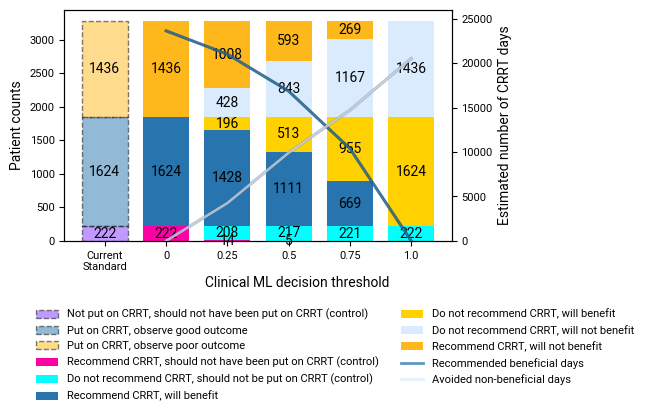

In [24]:
from models.static_models import METRIC_MAP

metric_names = ["TP", "FN", "TN","FP"]
metric_fns = [METRIC_MAP[metric] for metric in metric_names]

plt_labels = ['Combined Dsets Model']#, 'UCLA Model', "UCLA Model External"]
runs = [all_preselectall]#, ucla_train, ucla_train]
filters = ['ucla_crrt+cedars_crrt+ucla_control']#, '', 'cedars_crrt']

subgroups = [""]#, "_heart", "_liver", "_infection"]
subgroup_labels = ["all"]#, "heart", "liver", "infection"]

colors = ['#2774AE','#FFD100','#DAEBFE','#FFB81C']
conf_matrix_label = ['Recommend CRRT, will benefit','Do not recommend CRRT, will benefit','Do not recommend CRRT, will not benefit','Recommend CRRT, will not benefit']
conf_matrix_baseline_label = ['Put on CRRT, observe good outcome','','','Put on CRRT, observe poor outcome']

process_and_plot_clinical_impact(metric_names, metric_fns,
                     runs, filters, plt_labels,
                     subgroups, subgroup_labels,
                     colors, conf_matrix_label, conf_matrix_baseline_label,
                     strat=False,
                     price=False)

mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate da

['Current\nStandard', '0', '0.25', '0.5', '0.75', '1.0']
[nan, 0, 2069, 5631, 9261, 12784]
Clinical impact_all_UCLA Model


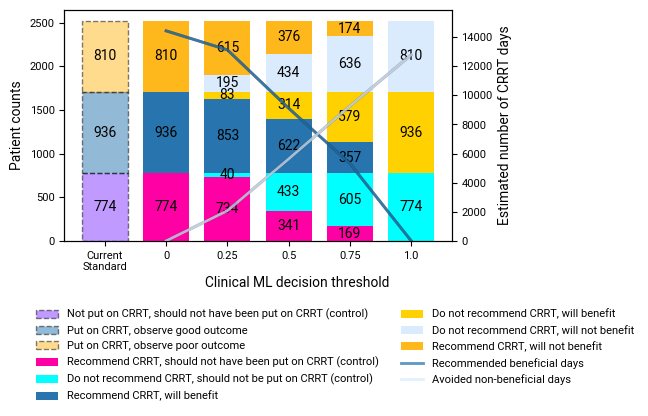

mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


['Current\nStandard', '0', '0.25', '0.5', '0.75', '1.0']
[nan, 0, 129, 7378, 9534, 9919]
Clinical impact_all_UCLA Model External


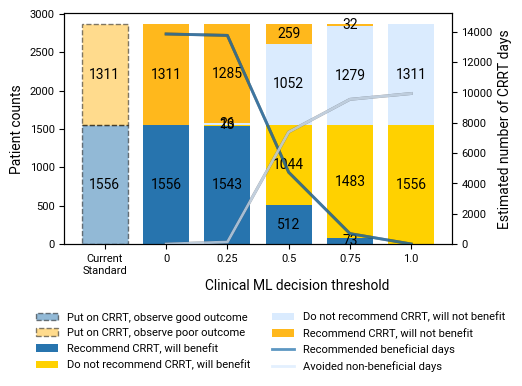

mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


['Current\nStandard', '0', '0.25', '0.5', '0.75', '1.0']
[nan, 0, 238, 3295, 7459, 7572]
Clinical impact_all_Cedars Model


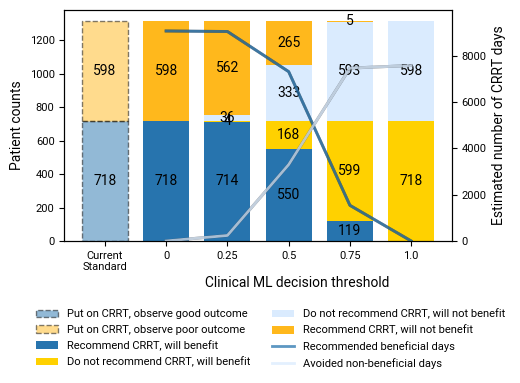

mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate da

['Current\nStandard', '0', '0.25', '0.5', '0.75', '1.0']
[nan, 0, 1, 3767, 16444, 16489]
Clinical impact_all_Cedars Model External


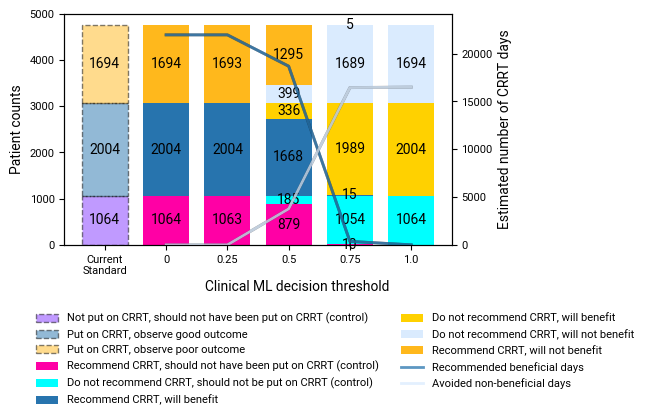

mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
mealy | INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


['Current\nStandard', '0', '0.25', '0.5', '0.75', '1.0']
[nan, 0, 1613, 7230, 15911, 20438]
Clinical impact_all_UCLA+Cedars Model


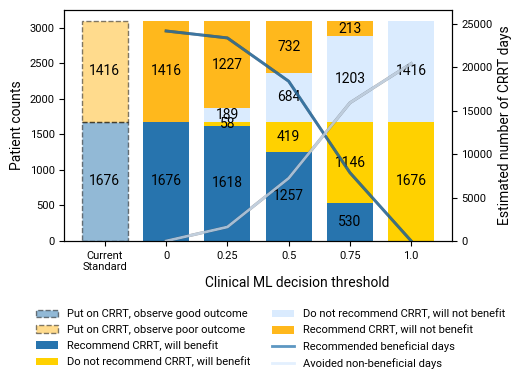

In [25]:
plt_labels = ['UCLA Model', "UCLA Model External", 'Cedars Model', "Cedars Model External",'UCLA+Cedars Model']
runs = [ucla_train, ucla_train, cedars_train, cedars_train, uclapluscedars_preselectcrrt]
filters = ['ucla_control', 'cedars_crrt', 'cedars_crrt', 'ucla_control' , 'ucla_crrt+cedars_crrt']
process_and_plot_clinical_impact(metric_names, metric_fns,
                     runs, filters, plt_labels,
                     subgroups, subgroup_labels,
                     colors, conf_matrix_label, conf_matrix_baseline_label,
                     strat=False,
                     price=False)

In [26]:
from sklearn.metrics import auc, det_curve, confusion_matrix

clinical_impact_dir = os.path.join(output_dir,'clinical_impact')
os.makedirs(clinical_impact_dir, exist_ok=True)

def get_cost(prob_df, threshold, price=True):
    
    prices = [543, 3486*0.76/7, 5177*0.76/7, 276.70*1.11, 2607*0.76/7,3089*0.76/7,436*1.11, 3629.80, 1100*0.76, 3700*0.76]
    
    # GET FN AND TN patients 
    # labels = prob_df['recommend_crrt']
    # pred_probas = prob_df[0].values
    
    prob_df['pred'] = (prob_df[0] >= threshold).astype(int)
    prob_df['N'] = (prob_df['pred']==0).astype(int)
    
    # GET CRRT_TOTAL_DAYS for the selected patients
    days = pd.merge(prob_df, pd.concat([OUTCOMES_UCLA, OUTCOMES_CEDARS]), how='left', on=['IP_PATIENT_ID','Start Date'])
    days = days[days['N']==1]
    
    # sum total days
    total_days_saved = days['CRRT Total Days'].sum()
    
    # multuply by cost
    if price:
        return total_days_saved*np.mean(prices)
    else:
        return total_days_saved

def create_matrix(metric_names, metric_fns, prob_df, labels, pred_probas,grouping_labels, price):
    conf_matrix_values = {metric: [] for metric in metric_names}
    savings = [np.nan]
    
    # Current clinical practice
    for metric_name, metric_fn in zip(metric_names,metric_fns):
        conf_matrix_values[metric_name].append(metric_fn(labels, labels, 0.5))
    conf_matrix_values['FP'] = conf_matrix_values['TN']
    conf_matrix_values['TN'] = [0]
    
    # Search for good threshold (FN=0 or FN=2)
    fpr, fnr, thresholds = det_curve(labels, pred_probas)
    use_thresh = sorted(thresholds)
    grouping_labels = grouping_labels + [str(thresh) for thresh in use_thresh]
        
    for k in range(len(use_thresh)):
        for metric_name, metric_fn in zip(metric_names,metric_fns):
            conf_matrix_values[metric_name].append(metric_fn(labels, pred_probas, use_thresh[k]))
        savings.append(get_cost(prob_df, use_thresh[k], price))

    # Decision threshold = 0.5
    # for metric_name, metric_fn in zip(metric_names,metric_fns):
    #     conf_matrix_values[metric_name].append(metric_fn(labels, pred_probas, 0.5))
    # savings.append(get_cost(prob_df, 0.5, price))
    
    return conf_matrix_values,savings,grouping_labels

def plot_clinical_impact(grouping_labels,
                         conf_matrix_values, savings,
                         plt_label, 
                         subgroup_label, 
                         colors,conf_matrix_label,conf_matrix_baseline_label,
                         price=True):
    fig, ax = plt.subplots()
    bottom_baseline = 0

    for k, metric_name in enumerate(metric_names):
        data = conf_matrix_values[metric_name]
        if data[0] > 0:
            p = ax.bar(-0.105, data[0], 0.2, label=conf_matrix_baseline_label[k], 
                       bottom=bottom_baseline, edgecolor='black',linestyle='--',
                       color=colors[k], alpha=0.5)
            bottom_baseline += data[0]
            labels = [int(v) if v > 2 else "" for v in p.datavalues]    
            ax.bar_label(p, labels=labels, label_type="center")

    # for k, metric_name in enumerate(metric_names):
    x = [float(thresh) for thresh in grouping_labels[1:]]
    p = ax.stackplot(x, conf_matrix_values[metric_names[0]][1:],
               conf_matrix_values[metric_names[1]][1:],
               conf_matrix_values[metric_names[2]][1:],
               conf_matrix_values[metric_names[3]][1:], 
               labels=conf_matrix_label,colors=colors)
        # bottom += conf_matrix_values[metric_name][1:]

        # labels = [int(v) if v > 2 else "" for v in p.datavalues]    
        # ax.bar_label(p, labels=labels, label_type="center")
    ax.set_xticks([-0.105] + list(np.linspace(0,1,6)))
    labels = ax.set_xticklabels([grouping_labels[0]] + ['0.0','0.2','0.4','0.6','0.8','1.0'])
    labels[0].set_ha('right')
    ax.set_xlabel('Decision threshold')

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    if price:
        ax2.set_ylabel('Total cost savings ($)', color='#FF00A5')  # we already handled the x-label with ax1
    else:
        ax2.set_ylabel('Total CRRT days saved', color='#FF00A5')  # we already handled the x-label with ax1
    print(savings)

    ax2.errorbar(x, savings[1:], color='#FF00A5')
    ax2.set_ylim([0, np.nanmax(savings)+0.1*np.nanmax(savings)])
    ax2.tick_params(axis='y', labelcolor='#FF00A5')

    # ax.set_title(f"Clinical impact_{subgroup_labels[i]}_{plt_labels[j]}")
    print(f"Clinical impact_{subgroup_label}_{plt_label}")
    ax.legend(loc='upper left', bbox_to_anchor=(0.05, -0.25),
    fancybox=False, shadow=False, ncol=1)

    ax.set_ylabel("Patient counts")
    fig = plt.gcf()
    fig.set_size_inches(5,3)
    plt.savefig(os.path.join(clinical_impact_dir,f'Clinical impact_{subgroup_label}_{plt_label}v2.svg'), format='svg',  bbox_inches="tight")
    plt.show()
    plt.close()
    
def process_and_plot_clinical_impact_v2(metric_names, metric_fns, 
                         runs, filters, eval_cohorts, plt_labels, 
                         subgroups, subgroup_labels, 
                         colors,conf_matrix_label,conf_matrix_baseline_label,
                         price=True, strat=False):

    for subgroup, subgroup_label in zip(subgroups, subgroup_labels):
        print(subgroup)

        for run_name, filter, eval_cohort, plt_label in zip(runs,filters,eval_cohorts,plt_labels):
            
            if len(filter) > 0:
                run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
            else:
                run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // eval best'")

            prefix = f"{run.data.tags['modeln']}_test{subgroup}"
            
            prob_df, labels, pred_probas = get_original_probabilities(exp_path, run.info.run_id, run_name, prefix, filter=eval_cohort)
            # prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(list(UCLA_IDS)+list(CEDARS_IDS))].copy()
            labels = prob_df['recommend_crrt']
            pred_probas = prob_df[0].values
                
            grouping_labels = ['Current\nStandard']
            
            conf_matrix_values,savings,grouping_labels = create_matrix(metric_names, metric_fns, prob_df, labels, pred_probas,grouping_labels, price)
            
            plot_clinical_impact(grouping_labels, conf_matrix_values,savings,
                                 plt_label, 
                                subgroup_label, 
                                colors,conf_matrix_label,conf_matrix_baseline_label,
                                price=price)
        
            if ('plus' in run_name or 'all_to_all' in run_name) and strat:
                
                ucla_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(UCLA_IDS)].copy()
                labels = ucla_prob_df['recommend_crrt']
                pred_probas = ucla_prob_df[0].values
                
                conf_matrix_values,savings = create_matrix(metric_names, metric_fns, ucla_prob_df, labels, pred_probas,grouping_labels, price)
            
                plot_clinical_impact(grouping_labels, conf_matrix_values,savings,
                                    plt_label + ' Strat. UCLA', 
                                    subgroup_label, 
                                    colors,conf_matrix_label,conf_matrix_baseline_label,
                                    price=price)
                         
                cedars_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(CEDARS_IDS)].copy()
                labels = cedars_prob_df['recommend_crrt']
                pred_probas = cedars_prob_df[0].values
                
                conf_matrix_values,savings = create_matrix(metric_names, metric_fns, cedars_prob_df, labels, pred_probas,grouping_labels, price)
            
                plot_clinical_impact(grouping_labels, conf_matrix_values,savings,
                                    plt_label+ ' Strat. Cedars', 
                                    subgroup_label, 
                                    colors,conf_matrix_label,conf_matrix_baseline_label,
                                    price=price)


[nan, 15.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 45.0, 45.0, 45.0, 45.0, 49.0, 49.0, 49.0, 52.0, 52.0, 58.0, 58.0, 58.0, 58.0, 59.0, 59.0, 59.0, 59.0, 59.0, 62.0, 63.0, 63.0, 63.0, 63.0, 63.0, 63.0, 63.0, 63.0, 70.0, 71.0, 71.0, 74.0, 74.0, 74.0, 76.0, 76.0, 76.0, 76.0, 76.0, 76.0, 76.0, 76.0, 78.0, 78.0, 78.0, 81.0, 81.0, 81.0, 81.

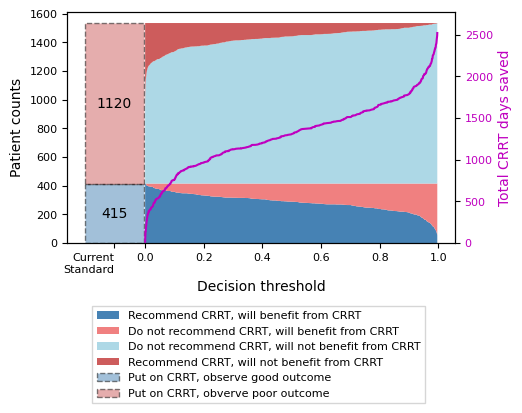


[nan, 0.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 

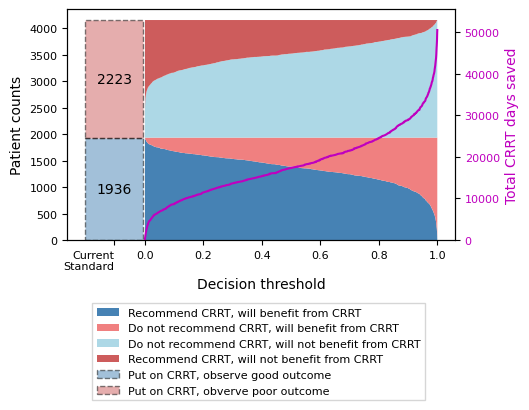

In [78]:
from models.static_models import METRIC_MAP

metric_names = ["TP", "FN", "TN","FP"]
metric_fns = [METRIC_MAP[metric] for metric in metric_names]

plt_labels = ['Combined Dsets Model']#, 'UCLA Model', "UCLA Model External"]
runs = [all_preselectall]#, ucla_train, ucla_train]
filters = ['']#, '', 'cedars_crrt']
eval_cohorts = ['ucla_crrt+cedars_crrt']#, None, None]

subgroups = [""]#, "_heart", "_liver", "_infection"]
subgroup_labels = ["all"]#, "heart", "liver", "infection"]

colors = ['steelblue','lightcoral','lightblue','indianred']
conf_matrix_label = ['Recommend CRRT, will benefit from CRRT','Do not recommend CRRT, will benefit from CRRT','Do not recommend CRRT, will not benefit from CRRT','Recommend CRRT, will not benefit from CRRT']
conf_matrix_baseline_label = ['Put on CRRT, observe good outcome','','','Put on CRRT, obverve poor outcome']

process_and_plot_clinical_impact_v2(metric_names, metric_fns,
                     runs, filters, eval_cohorts, plt_labels,
                     subgroups, subgroup_labels,
                     colors, conf_matrix_label, conf_matrix_baseline_label,
                     strat=False,
                     price=False)

# Decision Curve 

In [27]:
from dcurves import dca, plot_graphs

decision_dir = os.path.join(output_dir,'decision')
os.makedirs(decision_dir,exist_ok=True)

def plot_dca(dca_df, run_name, color):
    single_model_df = dca_df[dca_df["model"] == run_name]
    plt.plot(
        single_model_df["threshold"],
        single_model_df["net_benefit"],
        color=color,
        label=run_name
    )
        
    single_model_df = dca_df[dca_df["model"] == 'all']
    plt.plot(
        single_model_df["threshold"],
        single_model_df["net_benefit"],
        color=color,
        linestyle='--',
        label=run_name.replace('Model ','')+ ", Always put on CRRT"
    )
    
def decision_analysis(runs, filters,
                        full_horizon=True,
                        plt_labels = None,
                        colors = None):

    dca_dfs = []
    dca_models = []

    for i, (run_name, filter, plt_label) in enumerate(zip(runs,filters,plt_labels)):
        
        if len(filter) > 0:
            if full_horizon and filter != 'ucla_control':
                run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter}_200 best'")
            else:
                run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
        else:
            run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // eval best'")

        prefix = f"{run.data.tags['modeln']}_test"
        
        # ignore controls for now
        prob_df, labels, pred_probas = get_original_probabilities(exp_path, run.info.run_id, run_name, prefix)
        # prob_df['not_recommend_crrt'] = 1 - prob_df['recommend_crrt']
        prob_df[plt_label] = prob_df[0].values
        
        dca_df = dca(
            data=prob_df,
            outcome='recommend_crrt',
            modelnames=[plt_label]
        )
        dca_dfs.append(dca_df)
        dca_models.append(plt_label)      
        
        if ('plus' in run_name or 'all_to_all' in run_name):
            # ISOLATE UCLA
            ucla_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(UCLA_IDS)]
            ucla_prob_df[f'{plt_label} Stratified by UCLA'] = ucla_prob_df[0].values
            dca_df = \
            dca(
                data=ucla_prob_df,
                outcome='recommend_crrt',
                modelnames=[f'{plt_label} Stratified by UCLA']
            )
            dca_dfs.append(dca_df)
            dca_models.append(f'{plt_label} Stratified by UCLA')   
            
            # ISOLATE CEDARS
            cedars_prob_df = prob_df[prob_df.index.get_level_values('IP_PATIENT_ID').isin(CEDARS_IDS)]
            cedars_prob_df[f'{plt_label} Stratified by Cedars'] = cedars_prob_df[0].values
            dca_df = \
            dca(
                data=cedars_prob_df,
                outcome='recommend_crrt',
                modelnames=[f'{plt_label} Stratified by Cedars']
            )
            dca_dfs.append(dca_df)
            dca_models.append(f'{plt_label} Stratified by Cedars')  
        
    for i in range(len(dca_dfs)):
        plot_dca(dca_dfs[i], dca_models[i], colors[i])
    
    # Just take the last one
    single_model_df = dca_df[dca_df["model"] == 'none']
    plt.plot(
        single_model_df["threshold"],
        single_model_df["net_benefit"],
        color='gray',
        linestyle='--',
        label="Never put on CRRT"
    )
        
    plt.ylim([-0.1, 0.6])
    plt.xlabel("Threshold Values")
    plt.ylabel("Net Benefit")
        
    plt.legend(fancybox=False, shadow=False,  frameon=False,loc="upper left", bbox_to_anchor=(0.025, -0.25),ncol=1)
    fig = plt.gcf()
    fig.set_size_inches(5,3)
    fig.show()
    fig.savefig(os.path.join(decision_dir,f'{run_name}_{filter}_{plt_label}.svg'), format='svg',  bbox_inches="tight")
        
    # print(dca_df)

    # plot_graphs(
    #     plot_df=dca_df,
    #     graph_type='net_benefit', #net_intervention_avoided
    #     # y_limits=[-0.05, 0.4]
    # )
    # plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


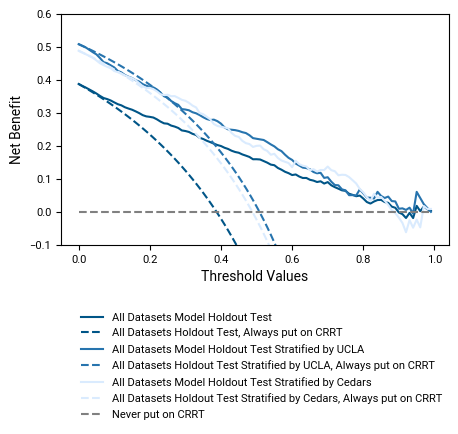

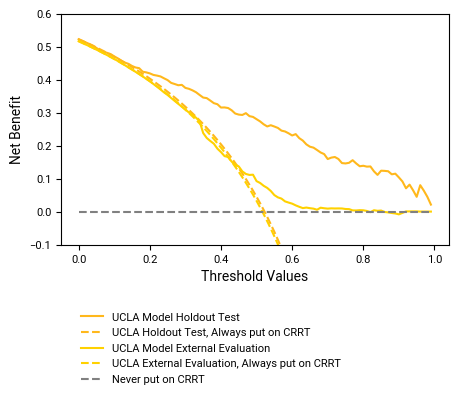

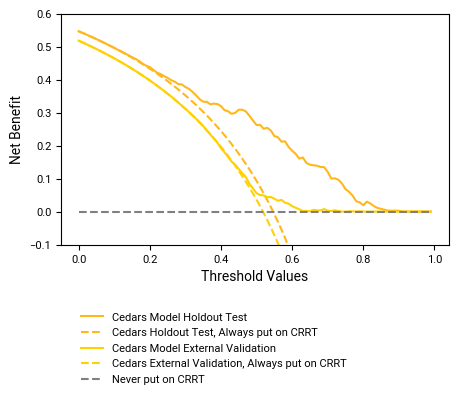


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


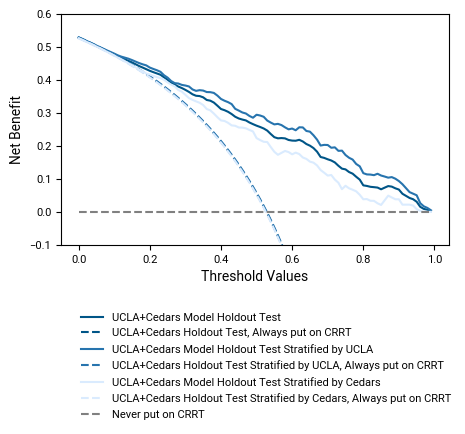

In [28]:
decision_analysis([all_preselectall],
                  [''], 
                  plt_labels=['All Datasets Model Holdout Test',
                              ],
                  colors=['#005587','#2774AE', '#DAEBFE', '#FFB81C', '#FFD100'],
                  full_horizon=False)

decision_analysis([ucla_train,ucla_train],
                  ['','cedars_crrt'], 
                  plt_labels=['UCLA Model Holdout Test',
                              "UCLA Model External Evaluation"],
                  colors=['#FFB81C', '#FFD100'],
                  full_horizon=False)

decision_analysis([cedars_train, cedars_train],
                  ['','ucla_crrt'], 
                  plt_labels=['Cedars Model Holdout Test',
                              'Cedars Model External Validation'],
                  colors=['#FFB81C', '#FFD100'],
                  full_horizon=False)

decision_analysis([uclapluscedars_preselectcrrt],
                  ['',], 
                  plt_labels=['UCLA+Cedars Model Holdout Test'],
                  colors=['#005587','#2774AE', '#DAEBFE', '#FFB81C', '#FFD100'],
                  full_horizon=False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


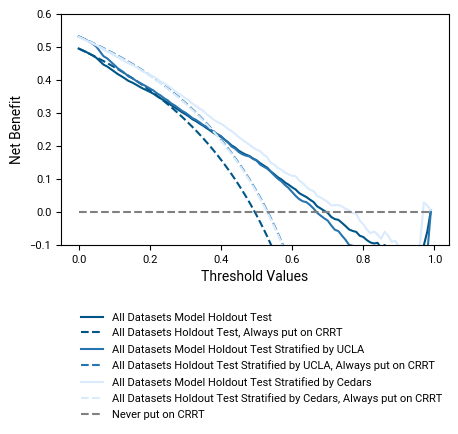

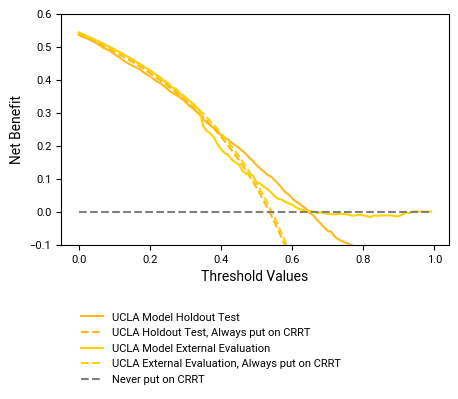

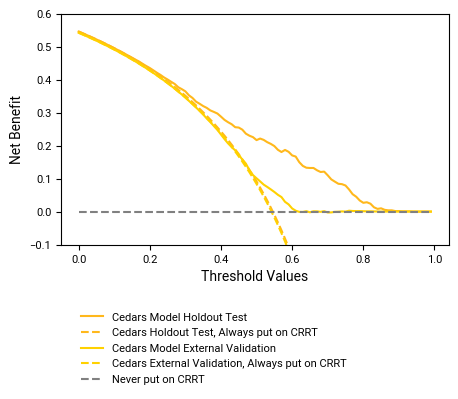


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


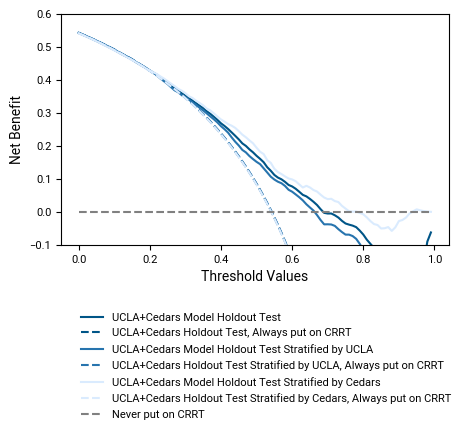

In [29]:
decision_analysis([all_preselectall],
                  ['ucla_crrt+cedars_crrt+ucla_control'], 
                  plt_labels=['All Datasets Model Holdout Test',
                              ],
                  colors=['#005587','#2774AE', '#DAEBFE', '#FFB81C', '#FFD100'],
                  full_horizon=True)

decision_analysis([ucla_train,ucla_train],
                  ['ucla_crrt','cedars_crrt'], 
                  plt_labels=['UCLA Model Holdout Test',
                              "UCLA Model External Evaluation"],
                  colors=['#FFB81C', '#FFD100'],
                  full_horizon=True)

decision_analysis([cedars_train, cedars_train],
                  ['cedars_crrt','ucla_crrt'], 
                  plt_labels=['Cedars Model Holdout Test',
                              'Cedars Model External Validation'],
                  colors=['#FFB81C', '#FFD100'],
                  full_horizon=True)

decision_analysis([uclapluscedars_preselectcrrt],
                  ['ucla_crrt+cedars_crrt',], 
                  plt_labels=['UCLA+Cedars Model Holdout Test'],
                  colors=['#005587','#2774AE', '#DAEBFE', '#FFB81C', '#FFD100'],
                  full_horizon=True)

# Bias Analysis

In [30]:
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

color1 = "#005587"
color2 = "#DAEBFE"


In [31]:
import seaborn as sns
from collections import defaultdict

subgroup_dir = os.path.join(output_dir, "subgroups")
assert os.path.isdir(subgroup_dir), "depends on running subgroup analysis"

bias_dir = os.path.join(output_dir, "bias")
os.makedirs(bias_dir, exist_ok=True)

def bias_analysis(runs, filters,
                    subgroup_labels,subgroup_categories):
    
    metric_names = ['TP','TN','FP','FN', 'recall', 'specificity']
    for run, filter in zip(runs, filters):

        metric_table = defaultdict(list)
        ci_low_table = defaultdict(list)
        ci_high_table = defaultdict(list)

        for metric_name in metric_names:
            
            # _ucla_crrt+cedars_crrt
            with open(os.path.join(subgroup_dir,f'{run}_{filter}_full_horizon_subgroups.pkl'), 'rb') as f:
                table = pickle.load(f)
            
            for subgroup_label in subgroup_labels:
                # if float(table['counts'][subgroup_label].split(' (')[0]) < 5:
                #     continue
                
                metric_table[metric_name].append(float(table[metric_name][subgroup_label].split(' (')[0]))
                ci_low_table[metric_name].append(float(table[metric_name][subgroup_label].split(' (')[0]) - float(table[metric_name][subgroup_label].split(' (')[-1].split('-')[0]))
                ci_high_table[metric_name].append(float(table[metric_name][subgroup_label].split('-')[-1].split(')')[0]) - float(table[metric_name][subgroup_label].split(' (')[0]))
                
                # if ('plus' in run or 'all_to_all' in run) and 'controls' not in filter:
                #     metric_table[metric_name][f'{subgroup_label} ucla_crrt'] = table[metric_name][f'{subgroup_label} ucla_crrt']
                #     ci_low_table[metric_name][f'{subgroup_label} ucla_crrt'] = float(table[metric_name][f'{subgroup_label} ucla_crrt'].split(' (')[-1].split('-')[0])
                #     ci_high_table[metric_name][f'{subgroup_label} ucla_crrt'] = float(table[metric_name][f'{subgroup_label} ucla_crrt'].split('-')[-1].split(')')[0])
                
                #     metric_table[metric_name][f'{subgroup_label} cedars_crrt'] = table[metric_name][f'{subgroup_label} cedars_crrt']
                #     ci_low_table[metric_name][f'{subgroup_label} cedars_crrt'] = float(table[metric_name][f'{subgroup_label} cedars_crrt'].split(' (')[-1].split('-')[0])
                #     ci_high_table[metric_name][f'{subgroup_label} cedars_crrt'] = float(table[metric_name][f'{subgroup_label} cedars_crrt'].split('-')[-1].split(')')[0])
        
        metric_table = pd.DataFrame(metric_table)       
        metric_table['FPR'] = 1 - metric_table['specificity']
        ci_low_table['FPR'] = ci_low_table['specificity']
        ci_high_table['FPR'] = ci_high_table['specificity']
        metric_table['FNR'] = 1 - metric_table['recall']
        ci_low_table['FNR'] = ci_low_table['recall']
        ci_high_table['FNR'] = ci_high_table['recall']
        
        for i in range(len(metric_table)):
            plt.figure(figsize=(2,2))
            # plt.subplot(1,len(metric_table),i+1)
            sns.heatmap([[int(np.nan_to_num(metric_table['TP'][i])),int(np.nan_to_num(metric_table['FP'][i]))],
                         [int(np.nan_to_num(metric_table['FN'][i])),int(np.nan_to_num(metric_table['TN'][i]))]], 
                                annot=True,  fmt="d",
                                xticklabels=['Positive', 'Negative'],
                                yticklabels=['Positive', 'Negative'],cmap=get_color_gradient(color2, color1, 255))
            plt.ylabel('Prediction')
            plt.xlabel('Actual')
            plt.title(subgroup_labels[i].capitalize())
            name = f"{run}{filter}_{subgroup_labels[i]}_confmatrix"
            plt.savefig(os.path.join(bias_dir,f'{name}.svg'), format='svg',  bbox_inches="tight")
            plt.show()
            plt.close()
        
        x = []
        category_x = []
        category_labels = []
        prev_category = None
        current_category = None
        index = len(subgroup_labels) + len(np.unique(subgroup_categories)) - 1
        for i in range(len(subgroup_labels)):
            current_category = subgroup_categories[i]
            if current_category != prev_category:
                category_x.append(index)
                category_labels.append(current_category)
                index -= 1
                prev_category = current_category
            x.append(index)
            index -= 1
        x = np.array(x)
        
        subgroup_labels_with_counts = []
        for subgroup_label in subgroup_labels:
            lab_ = subgroup_label.replace('\ninfection','infection')
            subgroup_labels_with_counts.append(f"{lab_}\n N={table['counts'][subgroup_label]}")
            
        fig, ax = plt.subplots()
        x_pos = np.arange(len(metric_table))
        ax.barh(x, metric_table['FPR'], height=0.3, xerr=[ci_high_table['FPR'], ci_low_table['FPR']],label='FPR', capsize=2,color='#2774AE')
        # ax.plot([metric_table['FPR'][0], metric_table['FPR'][0]], [0., x[0]], "k--", linewidth=1, alpha=0.5)
        
        ax.barh(x+0.3, metric_table['FNR'], height=0.3, xerr=[ci_high_table['FNR'], ci_low_table['FNR']], label='FNR',capsize=2,color='#FFD100')
        # ax.plot([metric_table['FNR'][0], metric_table['FNR'][0]], [0., x[0]], "k--", linewidth=1, alpha=0.5)
        
        # ax.set_xticks(x_pos+0.125)
        ax.set_yticks(category_x, category_labels, minor=False, fontweight='bold')
        ax.set_yticks(x + 0.15, subgroup_labels_with_counts, minor=True)
        ax.tick_params(axis='y', which='major', length=0)
        # ax.set_xticklabels([label.capitalize() for label in subgroup_labels], rotation=45, ha='right')
        plt.legend(loc="upper left", bbox_to_anchor=(0.0, 0.03),ncol=len(metric_table.keys()),
            frameon=False,columnspacing=0.5,handlelength=1,handletextpad=0.25)
        # plt.ylim([-0.5,10.25])
        plt.xlabel('Value')
        fig.set_size_inches(3,10)
        name = f"{run}{filter}_bias"
        plt.savefig(os.path.join(bias_dir,f'{name}.svg'), format='svg',  bbox_inches="tight")
        plt.show()
        plt.close()

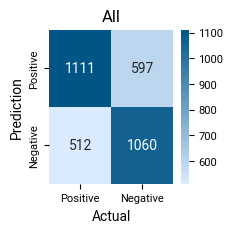

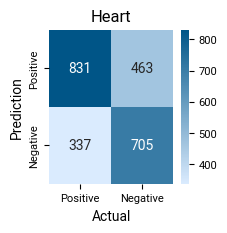

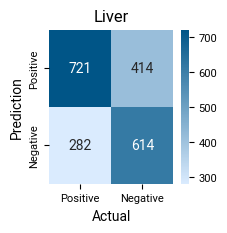

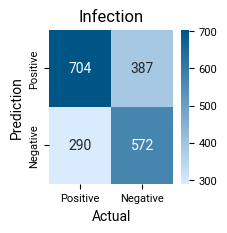

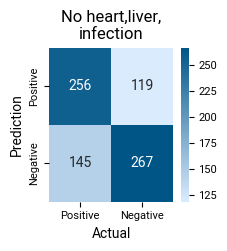

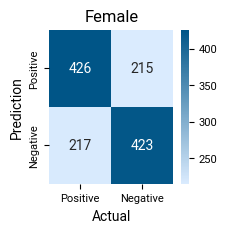

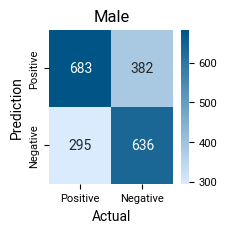

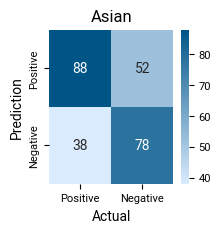

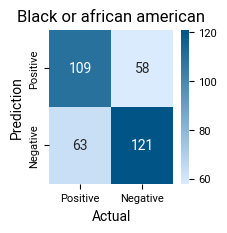

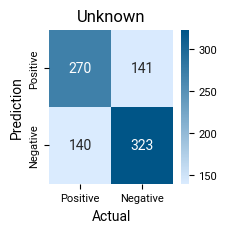

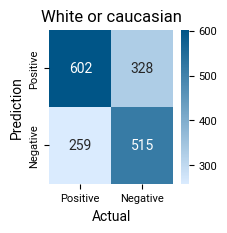

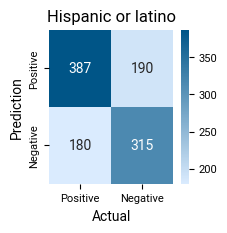

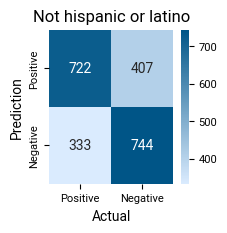

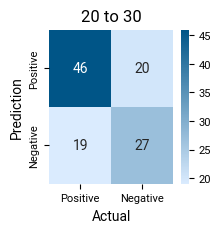

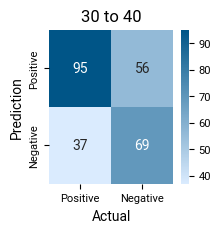

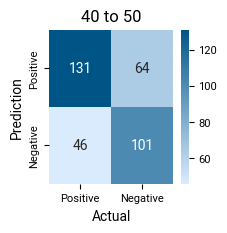

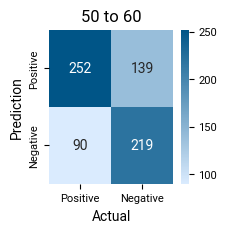

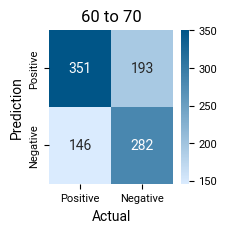

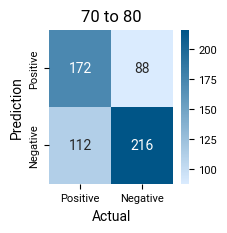

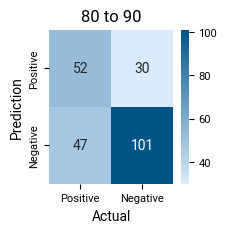

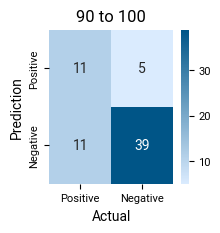

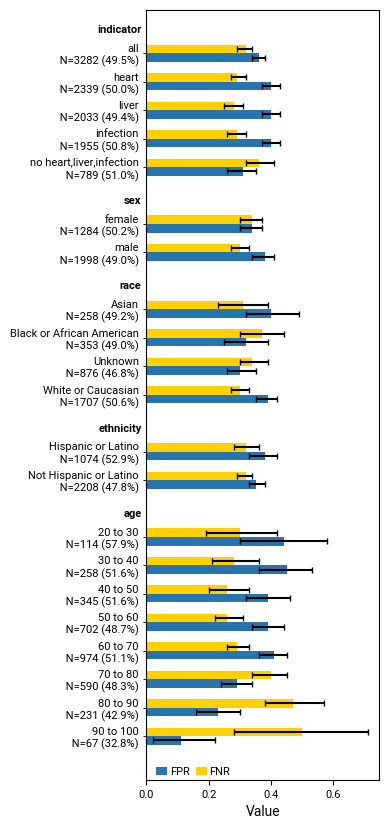

In [35]:
# bias_analysis([ucla_train], [''],
#                 ['American Indian\no
# r Alaska Native','Asian','Black or African American','Native Hawaiian or\nOther Pacific Islander','Multiple Races','Unknown','White or Caucasian',
#               'Hispanic or Latino','Not Hispanic or Latino',])

subgroup_labels = [
              "all", "heart", "liver", "infection","no heart,liver,\ninfection",
              'female','male', 
        #       'American Indian\nor Alaska Native','Native Hawaiian or\nOther Pacific Islander','Multiple Races',
              'Asian','Black or African American','Unknown','White or Caucasian',
              'Hispanic or Latino','Not Hispanic or Latino',
              '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80','80 to 90','90 to 100'
              ]
subgroup_categories = [
              "indicator", "indicator", "indicator", "indicator","indicator",
              'sex','sex', 
        #       'race','race','race',
              'race','race','race','race',
              'ethnicity','ethnicity',
              'age','age','age','age','age','age','age','age'
              ]

bias_analysis([all_preselectall], ['ucla_crrt+cedars_crrt+ucla_control'],
                subgroup_labels,
                subgroup_categories)

In [ ]:
report_as_is(['counts','TP','TN','FP','FN','recall','specificity'],
                [all_preselectall], ['ucla_crrt+cedars_crrt+ucla_control'],
                ['American Indian\nor Alaska Native','Asian','Black or African American','Native Hawaiian or\nOther Pacific Islander','Multiple Races','Unknown','White or Caucasian',
              'Hispanic or Latino','Not Hispanic or Latino','male','female'],
                full_horizon=True)

# Randomness

In [123]:
def load_code_mappings():
    mapping_dict = {}
    
    temp = pd.read_csv('../../Data/cpt_sections.csv')
    for i, row in temp.iterrows():
        mapping_dict[f"CPT_SECTION_{row['Code']}"] = 'CPT: '+row['Name']
        
    temp = pd.read_csv('../../Data/ccs_dx_icd10cm_2019_1.csv')
    for i, row in temp.iterrows():
        code = row['\'CCS CATEGORY\''].strip('\'')
        mapping_dict[f"pr_CCS_CODE_{code}"] = 'CCS: '+row['\'CCS CATEGORY DESCRIPTION\'']
        
    # temp = pd.read_csv('../../Data/ccs_dx_icd10cm_2019_1.csv')
    for i, row in temp.iterrows():
        code = row['\'CCS CATEGORY\''].strip('\'')
        mapping_dict[f"dx_CCS_CODE_{code}"] = 'CCS: '+row['\'CCS CATEGORY DESCRIPTION\'']
        
    return mapping_dict

In [124]:
CODE_MAPPINGS = load_code_mappings()

In [125]:
CONVERSION = {
    'MEAN CORPUSCULAR VOLUME': 'Mean corpuscular volume',
    'Num Prev CRRT Treatments': 'Number of previous CRRT treatments',
    'PHOSPHORUS': "Phosphorus",
    'PH, ARTERIAL': "Arterial pH",
    'CHOLESTEROL,LDL,CALCULATED': "LDL cholesterol",
    'surgery_indicator': "Surgery before CRRT",
    'TOBRAMYCIN,PEAK': 'Peak tobramycin',
    'EOSINOPHIL,FLUID': 'eosinophil',
    'VANCOMYCIN,RANDOM': "Vancomycin random level",
    'PCO2, ARTERIAL': 'Arterial PCO2',
    'PCO2,VENOUS': 'Venous PCO2',
    'PHARM_SUBCLASS_ANTIPSYCHOTICS - MISC.': "Antipsychotics",
    'PH,VENOUS': "venous pH",
    'ADAMTS13 ACTIVITY': "ADAMTS13 activity",
    'TRIGLYCERIDES,FLUID': 'Triglycerides',
    'PHARM_SUBCLASS_CEPHALOSPORINS - 1ST GENERATION': "Cephalosporins - 1st generation",
    'MONOCYTE': 'Monocyte',
    'CHOLESTEROL,FLUID': 'Cholesterol',
    'CHOLESTEROL': 'Cholesterol',
    'OSMOLALITY,URINE': "Urine osmolality",
    'EOSINOPHIL': 'Eosinophil',
    'ETHNICITY': 'Ethnicity',
    'SEX': 'Sex',
    'TROPONIN I': "troponin I",
    'Unknown': "Unknown race",
    'liver_pt_indicator': "Liver comorbidities",
    'infection_pt_indicator': "Infection comorbidities",
    'heart_pt_indicator': "Heart comorbidities",
    'MEAN CORPUSCULAR HEMOGLOBIN': "Mean corpuscular hemoglobin",
    'PHARM_SUBCLASS_MAGNESIUM': "Magnesium",
    'PHARM_SUBCLASS_ANTIPARKINSON DOPAMINERGICS': "Antiparkinson dopaminergics",
    'BILIRUBIN,TOTAL': 'Bilirubin',
    'PHARM_SUBCLASS_CEPHALOSPORINS - 3RD GENERATION': "Cephalosporins - 3rd generation",
    'PHARM_SUBCLASS_BENZODIAZEPINE ANTAGONISTS': "Bensodiazepine antagonists",
    'PHARM_SUBCLASS_BENZISOXAZOLES': "Benzisoxazoles",
    'GENTAMICIN,RANDOM': 'Gentamicin random level',
    'VANCOMYCIN,TROUGH': 'Vancomycin trough',
    'IONIZED CALCIUM(NON-PATIENT)': 'Ionized calcium',
    'IGG ALBUMIN SYN': "IGG albumin synthesis",
    'ABSOLUTE PLASMA CELL CT, MANUAL': "Plasma cell count",
    'N-ACETYLTYROSINE, URINE': 'Urine N-acetyl-tyrosine',
    'HISTOPLASMA ANTIGEN RESULT': 'histoplasma antigen',
    'ALDOSTERONE,SERUM': "Aldosterone",
    'PHENYLACETIC, URINE': "Urine phenylacetic",
    'IRON BINDING CAPACITY(QST)': "Iron binding capacity",
    'ABSOLUTE BASO COUNT': 'Basophil count',
    'URIC ACID(LDQ)': "Uric acid",
    '2-METHYL,3-HYDROXYBUTYRIC, URINE': 'Urine 2-methyl,3-hydroxybutyric',
    '3-HYDROXYBUTYRIC, URINE': 'Urine 3-hydroxybutyric',
    'VALPROIC ACID': "Valproic acid",
    '3-HYDROXYGLUTARIC, URINE': 'Urine 3-hydroxyglutaric',
    '3-HYDROXYISOBUTYRIC, URINE': 'Urine 3-hydroxyisobutyric',
    '3-METHYLGLUTACONIC, URINE': 'Urine 3-methylglutaconic',
    'OCTENEDIOIC, URINE': 'urine octenedioic',
    '4-HYDROXYBUTYRIC, URINE': 'Urine 4-hydroxybutyric',
    'AMIKACIN LEVEL': "amikacin level",
    'T3,TOTAL': 'Triiodothyronine',
    'POTASSIUM-MEQ/D URINE 24 HR': "Urine potassium",
    'CD8 ABS #': "CD8 count",
    'LEUKOCYTE ALKALINE PHOSPHATASE': "Leukocyte alkaline phosphatase",
    'PHARM_SUBCLASS_PHENOTHIAZINES': "Phenothiazines",
    'PHARM_SUBCLASS_PERIPHERAL OPIOID RECEPTOR ANTAGONISTS': "Peripheral opioid receptor antagonists",
    'ALDOLASE-ALDL': "Alsolase",
    'PHARM_SUBCLASS_PERITONEAL DIALYSIS SOLUTIONS': "Peritoneal dialysis solutions",
    'TOBRAMYCIN,RANDOM':"Tobramycin random level",
    'FERRITIN':"Ferritin",
    'TOTAL PROTEIN':'Total protein',
    'UREA NITROGEN, 24 HR UR': "Urea nitrogen",
    'CD3 ABSOLUTE': "CD3 count",
    'PROTEIN,CSF': "CSF protein",
    'GAMMA GLOBULINS':"Gamma globulins",
    'PO2, ARTERIAL': "Arterial PO2",
    'LYMPHOCYTE':"Lymphocyte",
    'HEMOGLOBIN, PLASMA': "Plasma hemoglobin",
    'PHARM_SUBCLASS_PHOSPHODIESTERASE 4 (PDE4) INHIBITORS': "Phosphodiesterase 4 inhibitors",
    'ALPHA-1-ANTITRYPSIN': 'Alpha-1-antitrypsin',
    'CK, TOTAL': "Creatine kinase",
    "CREATININE": "Creatinine",
    "MAGNESIUM": "magnesium",
    "MCH CONCENTRATION": "Mean corpuscular hemoglobin conc.",
    "SQUAMOUS EPITHELIAL CELLS": "squamous epithelial cell",
    "PHARM_SUBCLASS_OIL SOLUBLE VITAMINS": "Oil soluble vitamins",
    "medications": "meds.",
    "medicinal": "med.",
    "musculoskeletal": "MSK",
    "deformities":"deform.",
    "circulatory": "circ.",
    "unspecified nature or uncertain behavior": "unspec. nat./uncert. behav.",
    "PHARM_SUBCLASS AMPHETAMINES": "Amphetamines",
    "Attention-deficit conduct and disruptive behavior disorders": "Attn. def. conduct & disrupt. behav.",
    "TRANSITIONAL EPITHELIAL CELLS": "Transitional epithelial cells",
    "PHARM_SUBCLASS_MONOBACTAMS": "Monobactams",
    "HAPTOGLOBIN":"haptoglobin",
    "PHARM_SUBCLASS_PULMONARY HYPERTENSION - ENDOTHELIN RECEPTOR ANTAGONISTS": 'Pulm. hyperten. - endothelin receptor antag.',
    'PHARM_SUBCLASS_PULMONARY FIBROSIS AGENTS': 'Pulmonary fibrosis agents',
    'PHARM_SUBCLASS_DIABETIC OTHER': 'Other diabetic medications',
    "ESTIMATE FOR NON-AFRICAN AMERICAN": "est. for non-African American",
    'BASE EXCESS, ARTERIAL': 'Arterial base excess',
    'OXYHEMOGLOBIN': 'Oxyhemoglobin',
    'MEAN PLATELET VOLUME': 'Mean platelet volume',
    'BASE EXCESS, VENOUS': 'Venous base excess',
    "PLATELET COUNT, AUTO": "Platelet count",
    'ISSUE DATE': "Issue date",
    'BLOOD LACTATE': 'Blood lactate',
    'CALCIUM': "Calcium",
    "BICARBONATE, ARTERIAL": "Arterial bicarbonate",
    "PHARM_SUBCLASS_ANTIEMETICS - MISCELLANEOUS": "Miscellaneous antiemetics",
    "O2 SATURATION-ARTERIAL": "Arterial O2 saturation",
    'auxiliary':'aux.',
    'procedures':'proc.',
    "Physical therapy exercises; manipulation; and other": "Phys. thrpy. exerc.; manip.; other",
    "PHARM_SUBCLASS_IRRITABLE BOWEL SYNDROME (IBS) AGENTS": "Irritable bowel syndrome agents",
    "Extracorporeal circulation": "Extracorp. circ.",
            
    'AGE': 'Age',
}

def convert_str(x_axis):
    print(x_axis)
    for i in tqdm(range(len(x_axis))):
        curr_name = x_axis[i]
        # if 'dx_' in curr_name:
        #         curr_name = curr_name.replace('dx_','')
        # if 'pr_' in curr_name:
        #         curr_name = curr_name.replace('pr_','')
        if 'RACE_' in curr_name:
                curr_name = curr_name.replace('RACE_','')
                        
        if curr_name in CODE_MAPPINGS.keys():
                curr_name = CODE_MAPPINGS[curr_name]
        # else:
        for key, val in CONVERSION.items():
                if key in curr_name:
                        curr_name = curr_name.replace(key, val)
                
        if '_std' in curr_name:
                curr_name = curr_name.replace('_std',' (SD)')
        if '_min' in curr_name:
                curr_name = curr_name.replace('_min',' (min)')
        if '_mean' in curr_name:
                curr_name = curr_name.replace('_mean',' (mean)')
        if '_max' in curr_name:
                curr_name = curr_name.replace('_max',' (max)')
        if '_skew' in curr_name:
                curr_name = curr_name.replace('_skew',' (skew)')
        if '_len' in curr_name:
                curr_name = "Number of " + curr_name.replace('_len',' measures')
        
        curr_name = curr_name.replace('_', ' ')
        x_axis[i] = curr_name
    return x_axis
        

In [126]:
from tqdm import tqdm

randomness_dir = os.path.join(output_dir,'randomness')
os.makedirs(randomness_dir, exist_ok=True)

def plot_randomness(run_name, filter, correction=False):
        
        if filter is None:
                run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // rolling window: 0'")
                filter = ""
        else:
                run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
        
        plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set2.colors)       
        colors = ['#00FF87', '#8237FF'] 
        df = pd.read_csv(join(exp_path, run.info.run_id, 'artifacts',f"{run.data.tags['modeln']}_test__dist_comparison_table.csv"))
        
        df = df[~df['Unnamed: 1'].str.contains('ISSUE DATE')]

        if correction:
                pthresh = 0.05/len(df)
        else:
                pthresh = 0.05
        df_fntp = df[df['Unnamed: 0']=='fn_vs_tp']
        df_fntp['log p-value'] = -np.log(df_fntp['p-value'])
        df_fntp['reject'] = (df_fntp['p-value']<pthresh)
        df_fntp_true = df_fntp[(df_fntp['Reject H0']==True) & (df_fntp['p-value']<pthresh)]
        print(df_fntp_true['Reject H0'].value_counts())

        ### PLOT
        fig, ax = plt.subplots()
        # ax2 = ax.twinx()
        # sns.scatterplot(data=df_fntp,x='Effect Size',y='log p-value',ax=ax2, hue='reject', alpha=0.5)
        # ax2.set_ylim([0,np.max(df_fntp['log p-value'])+5])
        
        plt.hist(df_fntp_true['Effect Size'], bins=50, range=(0,2), 
                label=f"Different between FN & TP (N={len(df_fntp_true['Effect Size'])})",
                 color=colors[0])
        # plt.hist(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_true)]['Effect Size'], bins=50, range=(0,2),
        #         label=f"Different from TN (N={len(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_true)]['Effect Size'])})",
        #          color=colors[1])
        
        
        plt.xlabel('Effect size')
        plt.ylabel('Number of features')
        plt.ylim([0,35])
        plt.legend(frameon=False, handlelength=1,handletextpad=0.25,)
        
        fig = plt.gcf()
        fig.set_size_inches(3,1.5)
        plt.savefig(os.path.join(randomness_dir,f'randomness_fn_{run_name}_{filter}.svg'), format='svg',  bbox_inches="tight")

        plt.figure(figsize=(4,4))
        relevant = df_fntp_true.sort_values('Effect Size')
        x_axis = [f'{a}, p={b:.2e}' for a,b in zip(convert_str(relevant['Unnamed: 1'][-10:].to_list()),relevant['p-value'][-10:])]
        # x_axis = convert_str(x_axis)
        
        p = plt.barh(x_axis, relevant['Effect Size'][-10:], alpha=1.0,  color=colors[0])
        plt.yticks(ha='left')
        plt.tick_params(axis="y",direction="in", pad=-10)
        plt.xlabel('Effect size')
        plt.xlim([0,2.0])
        plt.savefig(os.path.join(randomness_dir,f'randomness_fn_feat_{run_name}_{filter}.svg'), format='svg',  bbox_inches="tight")

        df_fptn = df[df['Unnamed: 0']=='fp_vs_tn']
        df_fptn_true = df_fptn[(df_fptn['Reject H0']==True)&(df_fptn['p-value']<pthresh)]
        print(df_fptn_true['Reject H0'].value_counts())

        ## PLOT
        plt.figure(figsize=(3,1.5))
        plt.hist(df_fptn_true['Effect Size'], bins=50, range=(0,2),
                label=f"Different between FP & TN (N={len(df_fptn_true['Effect Size'])})",
                color=colors[1])
        # plt.hist(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_true)]['Effect Size'], bins=50, range=(0,2),
        #         label=f"Different from TP (N={len(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_true)]['Effect Size'])})",
        #         color=colors[1])
        plt.xlabel('Effect size')
        plt.ylabel('Number of features')
        plt.ylim([0,35])
        plt.legend(frameon=False, handlelength=1,handletextpad=0.25,)
        plt.savefig(os.path.join(randomness_dir,f'randomness_fp_{run_name}_{filter}.svg'), format='svg',  bbox_inches="tight")
        plt.show()
        plt.close()

        plt.figure(figsize=(4,4))
        relevant = df_fptn_true.sort_values('Effect Size')
        x_axis = [f'{a}, p={b:.2e}' for a,b in zip(convert_str(relevant['Unnamed: 1'][-10:].to_list()),relevant['p-value'][-10:])]
        
        x_axis = convert_str(x_axis)
        print(x_axis)
        plt.barh(x_axis, relevant['Effect Size'][-10:], alpha=1.0, color=colors[1])
        plt.yticks(ha='left')
        plt.tick_params(axis="y",direction="in", pad=-10)
        plt.xlabel('Effect size')
        plt.xlim([0,2.0])
        plt.savefig(os.path.join(randomness_dir,f'randomness_fp_feat_{run_name}_{filter}.svg'), format='svg',  bbox_inches="tight")
        plt.show()
        plt.close()



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


True    13
Name: Reject H0, dtype: int64
['MEAN CORPUSCULAR HEMOGLOBIN_skew', 'MCH CONCENTRATION_mean', 'MEAN CORPUSCULAR HEMOGLOBIN_mean', 'MAGNESIUM_len', 'CREATININE_skew', 'dx_CCS_CODE_132', 'dx_CCS_CODE_243', 'dx_CCS_CODE_245', 'dx_CCS_CODE_242', 'dx_CCS_CODE_240']


100%|██████████| 10/10 [00:00<00:00, 54471.48it/s]


True    44
Name: Reject H0, dtype: int64


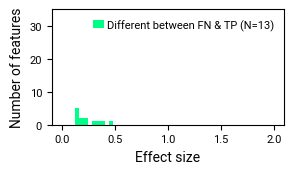

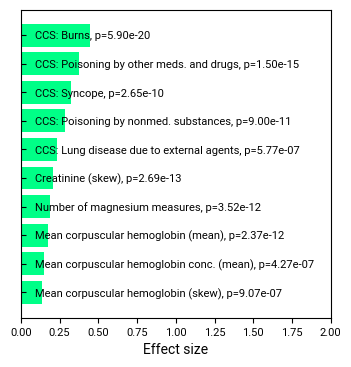

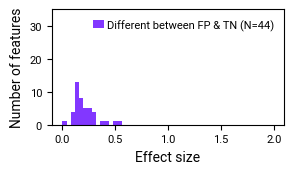

['dx_CCS_CODE_214', 'dx_CCS_CODE_132', 'dx_CCS_CODE_213', 'dx_CCS_CODE_212', 'PHARM_SUBCLASS_OIL SOLUBLE VITAMINS', 'SQUAMOUS EPITHELIAL CELLS_len', 'dx_CCS_CODE_243', 'dx_CCS_CODE_245', 'dx_CCS_CODE_242', 'dx_CCS_CODE_240']


100%|██████████| 10/10 [00:00<00:00, 35098.78it/s]


['CCS: Digestive congenital anomalies, p=1.02e-07', 'CCS: Lung disease due to external agents, p=5.29e-07', 'CCS: Cardiac and circ. congenital anomalies, p=2.46e-08', 'CCS: Other bone disease and MSK deform., p=4.13e-09', 'Oil soluble vitamins, p=3.53e-10', 'Number of squamous epithelial cell measures, p=8.37e-07', 'CCS: Poisoning by nonmed. substances, p=1.01e-13', 'CCS: Syncope, p=3.47e-18', 'CCS: Poisoning by other meds. and drugs, p=3.11e-22', 'CCS: Burns, p=1.88e-26']


100%|██████████| 10/10 [00:00<00:00, 38621.58it/s]

['CCS: Digestive congenital anomalies, p=1.02e-07', 'CCS: Lung disease due to external agents, p=5.29e-07', 'CCS: Cardiac and circ. congenital anomalies, p=2.46e-08', 'CCS: Other bone disease and MSK deform., p=4.13e-09', 'Oil soluble vitamins, p=3.53e-10', 'Number of squamous epithelial cell measures, p=8.37e-07', 'CCS: Poisoning by nonmed. substances, p=1.01e-13', 'CCS: Syncope, p=3.47e-18', 'CCS: Poisoning by other meds. and drugs, p=3.11e-22', 'CCS: Burns, p=1.88e-26']


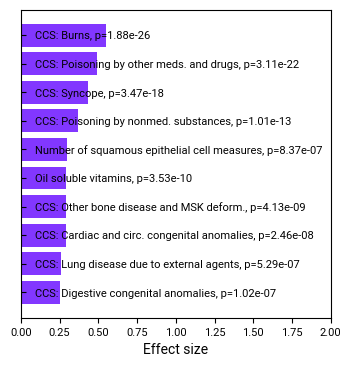

In [127]:
plot_randomness(all_preselectall, 'ucla_crrt+cedars_crrt+ucla_control_200', correction=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


True    35
Name: Reject H0, dtype: int64
['dx_CCS_CODE_651', 'HAPTOGLOBIN_len', 'dx_CCS_CODE_46', 'PHARM_SUBCLASS_MONOBACTAMS', 'TRANSITIONAL EPITHELIAL CELLS_max', 'dx_CCS_CODE_652', 'PHARM_SUBCLASS_AMPHETAMINES', 'dx_CCS_CODE_658', 'dx_CCS_CODE_45', 'dx_CCS_CODE_44']


100%|██████████| 10/10 [00:00<00:00, 23790.72it/s]


True    29
Name: Reject H0, dtype: int64


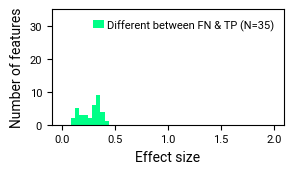

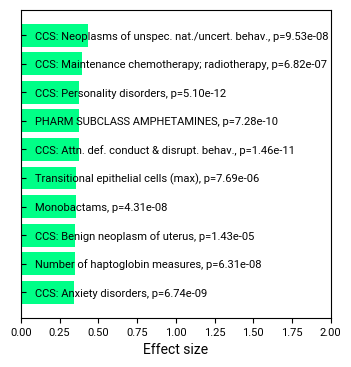

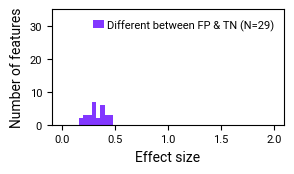

['dx_CCS_CODE_146', 'dx_CCS_CODE_235', 'dx_CCS_CODE_145', 'dx_CCS_CODE_236', 'PHARM_SUBCLASS_PULMONARY FIBROSIS AGENTS', 'PHARM_SUBCLASS_PULMONARY HYPERTENSION - ENDOTHELIN RECEPTOR ANTAGONISTS', 'TRANSITIONAL EPITHELIAL CELLS_max', 'dx_CCS_CODE_46', 'dx_CCS_CODE_44', 'dx_CCS_CODE_45']


100%|██████████| 10/10 [00:00<00:00, 32948.19it/s]


['CCS: Diverticulosis and diverticulitis, p=2.05e-08', 'CCS: Open wounds of head; neck; and trunk, p=2.13e-07', 'CCS: Intestinal obstruction without hernia, p=2.52e-08', 'CCS: Open wounds of extremities, p=4.08e-08', 'Pulmonary fibrosis agents, p=4.97e-08', 'Pulm. hyperten. - endothelin receptor antag., p=3.90e-09', 'Transitional epithelial cells (max), p=1.38e-07', 'CCS: Benign neoplasm of uterus, p=5.74e-07', 'CCS: Neoplasms of unspec. nat./uncert. behav., p=9.60e-09', 'CCS: Maintenance chemotherapy; radiotherapy, p=5.81e-08']


100%|██████████| 10/10 [00:00<00:00, 35910.14it/s]

['CCS: Diverticulosis and diverticulitis, p=2.05e-08', 'CCS: Open wounds of head; neck; and trunk, p=2.13e-07', 'CCS: Intestinal obstruction without hernia, p=2.52e-08', 'CCS: Open wounds of extremities, p=4.08e-08', 'Pulmonary fibrosis agents, p=4.97e-08', 'Pulm. hyperten. - endothelin receptor antag., p=3.90e-09', 'Transitional epithelial cells (max), p=1.38e-07', 'CCS: Benign neoplasm of uterus, p=5.74e-07', 'CCS: Neoplasms of unspec. nat./uncert. behav., p=9.60e-09', 'CCS: Maintenance chemotherapy; radiotherapy, p=5.81e-08']


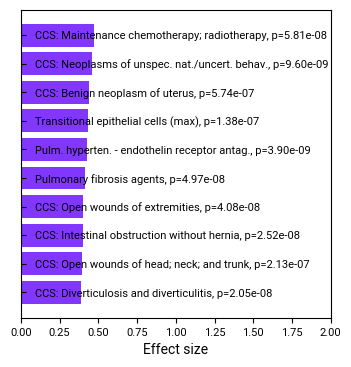


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


True    20
Name: Reject H0, dtype: int64
['BASE EXCESS, VENOUS_max', 'MEAN PLATELET VOLUME_mean', 'MEAN CORPUSCULAR VOLUME_min', 'OXYHEMOGLOBIN_mean', 'MEAN CORPUSCULAR HEMOGLOBIN_max', 'BASE EXCESS, ARTERIAL_mean', 'GFR ESTIMATE FOR NON-AFRICAN AMERICAN_std', 'dx_CCS_CODE_45', 'PHARM_SUBCLASS_DIABETIC OTHER', 'dx_CCS_CODE_137']


100%|██████████| 10/10 [00:00<00:00, 13353.40it/s]


True    19
Name: Reject H0, dtype: int64


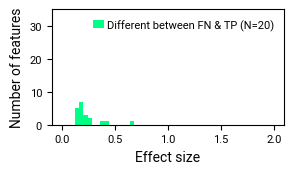

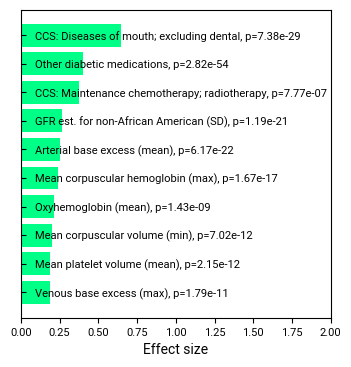

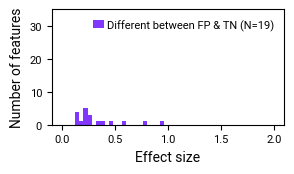

['MEAN PLATELET VOLUME_mean', 'BASE EXCESS, ARTERIAL_min', 'BASE EXCESS, ARTERIAL_mean', 'MEAN CORPUSCULAR HEMOGLOBIN_max', 'PHARM_SUBCLASS_DIABETIC OTHER', 'VANCOMYCIN,TROUGH_max', 'dx_CCS_CODE_44', 'OXYHEMOGLOBIN_mean', 'dx_CCS_CODE_137', 'ETHNICITY']


100%|██████████| 10/10 [00:00<00:00, 19337.50it/s]


['Mean platelet volume (mean), p=2.53e-16', 'Arterial base excess (min), p=5.17e-16', 'Arterial base excess (mean), p=5.50e-19', 'Mean corpuscular hemoglobin (max), p=1.19e-18', 'Other diabetic medications, p=5.80e-31', 'Vancomycin trough (max), p=3.23e-10', 'CCS: Neoplasms of unspec. nat./uncert. behav., p=7.37e-07', 'Oxyhemoglobin (mean), p=7.81e-07', 'CCS: Diseases of mouth; excluding dental, p=2.17e-22', 'Ethnicity, p=1.13e-15']


100%|██████████| 10/10 [00:00<00:00, 33770.56it/s]

['Mean platelet volume (mean), p=2.53e-16', 'Arterial base excess (min), p=5.17e-16', 'Arterial base excess (mean), p=5.50e-19', 'Mean corpuscular hemoglobin (max), p=1.19e-18', 'Other diabetic meds., p=5.80e-31', 'Vancomycin trough (max), p=3.23e-10', 'CCS: Neoplasms of unspec. nat./uncert. behav., p=7.37e-07', 'Oxyhemoglobin (mean), p=7.81e-07', 'CCS: Diseases of mouth; excluding dental, p=2.17e-22', 'Ethnicity, p=1.13e-15']


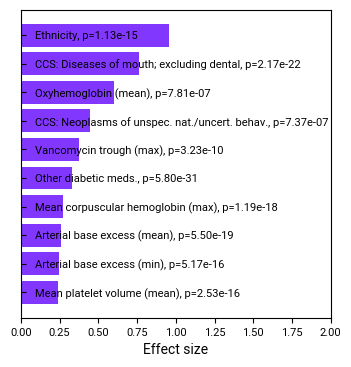


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


True    13
Name: Reject H0, dtype: int64
['PO2, ARTERIAL_mean', 'CALCIUM_mean', 'BLOOD LACTATE_max', 'BLOOD LACTATE_len', 'MCH CONCENTRATION_min', 'PHOSPHORUS_std', 'PO2, ARTERIAL_min', 'PLATELET COUNT, AUTO_min', 'liver_pt_indicator', 'dx_CCS_CODE_137']


100%|██████████| 10/10 [00:00<00:00, 25236.49it/s]


True    11
Name: Reject H0, dtype: int64


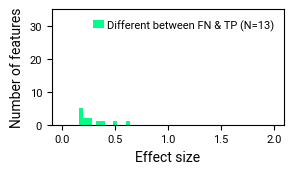

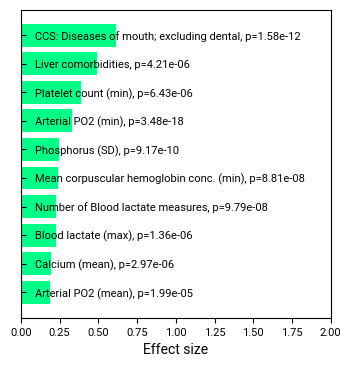

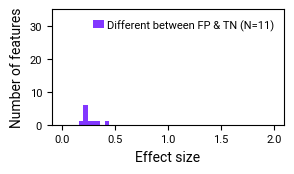

['O2 SATURATION-ARTERIAL_std', 'PHOSPHORUS_std', 'BLOOD LACTATE_len', 'PHARM_SUBCLASS_ANTIEMETICS - MISCELLANEOUS', 'MEAN PLATELET VOLUME_skew', 'BICARBONATE, ARTERIAL_mean', 'MCH CONCENTRATION_min', 'PO2, ARTERIAL_min', 'surgery_indicator', 'dx_CCS_CODE_137']


100%|██████████| 10/10 [00:00<00:00, 50594.74it/s]


['Arterial O2 saturation (SD), p=1.25e-05', 'Phosphorus (SD), p=1.04e-05', 'Number of Blood lactate measures, p=1.82e-05', 'Miscellaneous antiemetics, p=4.25e-06', 'Mean platelet volume (skew), p=2.30e-06', 'Arterial bicarbonate (mean), p=2.56e-07', 'Mean corpuscular hemoglobin conc. (min), p=1.69e-08', 'Arterial PO2 (min), p=2.41e-11', 'Surgery before CRRT, p=2.54e-08', 'CCS: Diseases of mouth; excluding dental, p=2.61e-07']


100%|██████████| 10/10 [00:00<00:00, 37482.61it/s]

['Arterial O2 saturation (SD), p=1.25e-05', 'Phosphorus (SD), p=1.04e-05', 'Number of Blood lactate measures, p=1.82e-05', 'Miscellaneous antiemetics, p=4.25e-06', 'Mean platelet volume (skew), p=2.30e-06', 'Arterial bicarbonate (mean), p=2.56e-07', 'Mean corpuscular hemoglobin conc. (min), p=1.69e-08', 'Arterial PO2 (min), p=2.41e-11', 'Surgery before CRRT, p=2.54e-08', 'CCS: Diseases of mouth; excluding dental, p=2.61e-07']


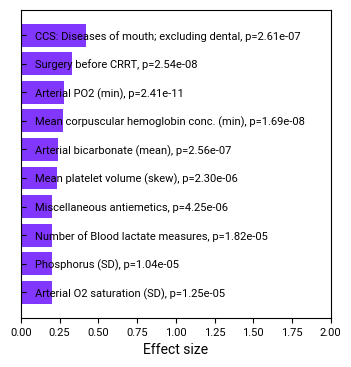


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


True    111
Name: Reject H0, dtype: int64
['pr_CCS_CODE_55', 'pr_CCS_CODE_153', 'dx_CCS_CODE_146', 'pr_CCS_CODE_11', 'CPT_SECTION_CPT1-C', 'pr_CCS_CODE_213', 'pr_CCS_CODE_50', 'pr_CCS_CODE_159', 'RACE_Unknown', 'RACE_White or Caucasian']


100%|██████████| 10/10 [00:00<00:00, 40252.44it/s]


True    94
Name: Reject H0, dtype: int64


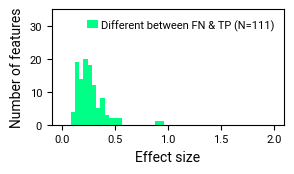

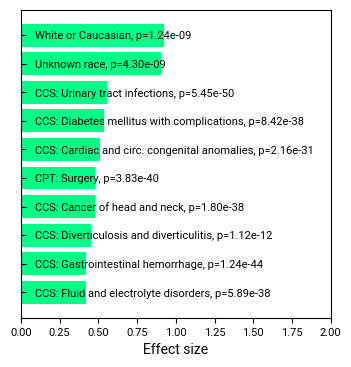

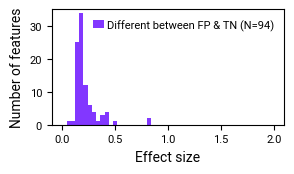

['dx_CCS_CODE_248', 'surgery_indicator', 'dx_CCS_CODE_45', 'PHARM_SUBCLASS_IRRITABLE BOWEL SYNDROME (IBS) AGENTS', 'dx_CCS_CODE_47', 'dx_CCS_CODE_145', 'dx_CCS_CODE_46', 'RACE_White or Caucasian', 'liver_pt_indicator', 'heart_pt_indicator']


100%|██████████| 10/10 [00:00<00:00, 47771.12it/s]


['CCS: Gangrene, p=6.68e-09', 'Surgery before CRRT, p=2.74e-07', 'CCS: Maintenance chemotherapy; radiotherapy, p=3.54e-11', 'Irritable bowel syndrome agents, p=1.30e-11', 'CCS: Other and unspecified benign neoplasm, p=4.03e-16', 'CCS: Intestinal obstruction without hernia, p=8.17e-13', 'CCS: Benign neoplasm of uterus, p=7.96e-16', 'White or Caucasian, p=1.56e-09', 'Liver comorbidities, p=3.26e-13', 'Heart comorbidities, p=1.61e-11']


100%|██████████| 10/10 [00:00<00:00, 58254.22it/s]

['CCS: Gangrene, p=6.68e-09', 'Surgery before CRRT, p=2.74e-07', 'CCS: Maintenance chemotherapy; radiotherapy, p=3.54e-11', 'Irritable bowel syndrome agents, p=1.30e-11', 'CCS: Other and unspecified benign neoplasm, p=4.03e-16', 'CCS: Intestinal obstruction without hernia, p=8.17e-13', 'CCS: Benign neoplasm of uterus, p=7.96e-16', 'White or Caucasian, p=1.56e-09', 'Liver comorbidities, p=3.26e-13', 'Heart comorbidities, p=1.61e-11']


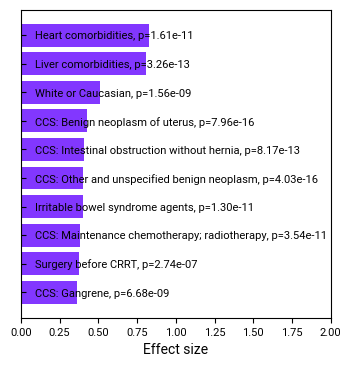


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


True    8
Name: Reject H0, dtype: int64
['dx_CCS_CODE_247', 'dx_CCS_CODE_246', 'dx_CCS_CODE_137', 'dx_CCS_CODE_240', 'dx_CCS_CODE_243', 'dx_CCS_CODE_24', 'dx_CCS_CODE_239', 'dx_CCS_CODE_128']


100%|██████████| 8/8 [00:00<00:00, 20648.88it/s]


True    28
Name: Reject H0, dtype: int64


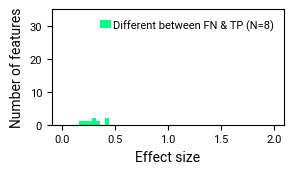

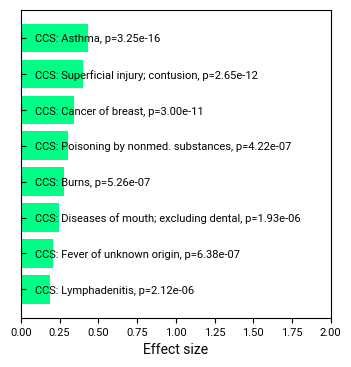

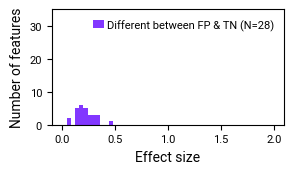

['dx_CCS_CODE_46', 'heart_pt_indicator', 'dx_CCS_CODE_212', 'dx_CCS_CODE_239', 'dx_CCS_CODE_137', 'dx_CCS_CODE_213', 'dx_CCS_CODE_135', 'ETHNICITY', 'dx_CCS_CODE_136', 'dx_CCS_CODE_128']


100%|██████████| 10/10 [00:00<00:00, 19728.62it/s]


['CCS: Benign neoplasm of uterus, p=2.01e-05', 'Heart comorbidities, p=4.14e-06', 'CCS: Other bone disease and MSK deform., p=9.97e-07', 'CCS: Superficial injury; contusion, p=7.50e-06', 'CCS: Diseases of mouth; excluding dental, p=3.81e-08', 'CCS: Cardiac and circ. congenital anomalies, p=1.62e-06', 'CCS: Intestinal infection, p=6.49e-09', 'Ethnicity, p=1.87e-06', 'CCS: Disorders of teeth and jaw, p=1.13e-10', 'CCS: Asthma, p=4.05e-18']


100%|██████████| 10/10 [00:00<00:00, 39089.51it/s]

['CCS: Benign neoplasm of uterus, p=2.01e-05', 'Heart comorbidities, p=4.14e-06', 'CCS: Other bone disease and MSK deform., p=9.97e-07', 'CCS: Superficial injury; contusion, p=7.50e-06', 'CCS: Diseases of mouth; excluding dental, p=3.81e-08', 'CCS: Cardiac and circ. congenital anomalies, p=1.62e-06', 'CCS: Intestinal infection, p=6.49e-09', 'Ethnicity, p=1.87e-06', 'CCS: Disorders of teeth and jaw, p=1.13e-10', 'CCS: Asthma, p=4.05e-18']


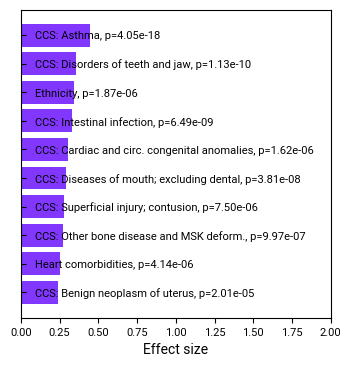

In [128]:
plot_randomness(ucla_train, 'ucla_crrt_200', correction=True)
plot_randomness(ucla_train, 'cedars_crrt_200', correction=True)
plot_randomness(cedars_train, 'cedars_crrt_200', correction=True)
plot_randomness(cedars_train, 'ucla_crrt_200', correction=True)
plot_randomness(uclapluscedars_preselectcrrt, 'ucla_crrt+cedars_crrt_200', correction=True)

### Plotting TP/FN, FN/TN together

In [17]:
from tqdm import tqdm

randomness_dir = os.path.join(output_dir,'randomness')
os.makedirs(randomness_dir, exist_ok=True)

def plot_randomness(run_name, filter, correction=False):
        
        if filter is None:
                run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // rolling window: 0'")
                filter = ""
        else:
                run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
        
        plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set2.colors)       
        colors = ['#00FF87', '#8237FF'] 
        df = pd.read_csv(join(exp_path, run.info.run_id, 'artifacts',f"{run.data.tags['modeln']}_test__dist_comparison_table.csv"))

        if correction:
                pthresh = 0.05/len(df)
        else:
                pthresh = 0.05
                
        df_fntp = df[df['Unnamed: 0']=='fn_vs_tp']
        df_fntp_true = df_fntp[(df_fntp['Reject H0']==True) & (df_fntp['p-value']<pthresh)]
        df_fntp_true_var = df_fntp_true['Unnamed: 1']
        print(df_fntp_true['Reject H0'].value_counts())

        df_fntn = df[df['Unnamed: 0']=='fn_vs_tn']
        df_fntn_shared = df_fntn[df_fntn['Unnamed: 1'].isin(df_fntp_true_var)]
        print(df_fntn_shared['Reject H0'].value_counts())
        df_fntn_shared_false = df_fntn_shared[df_fntn_shared['Reject H0']==False]['Unnamed: 1']
        df_fntn_shared_true = df_fntn_shared[(df_fntn_shared['Reject H0']==True)& (df_fntn_shared['p-value']<pthresh)]['Unnamed: 1']

        ### PLOT
        plt.figure(figsize=(3,2))
        plt.hist(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_false)]['Effect Size'], bins=50, range=(0,2), 
                label=f"Similar to TN (N={len(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_false)]['Effect Size'])})",
                 color=colors[0])
        plt.hist(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_true)]['Effect Size'], bins=50, range=(0,2),
                label=f"Different from TN (N={len(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_true)]['Effect Size'])})",
                 color=colors[1])
        plt.xlabel('Effect size')
        plt.ylabel('Number of features')
        plt.ylim([0,15])
        plt.legend(frameon=False, handlelength=1,handletextpad=0.25,)
        plt.savefig(os.path.join(randomness_dir,f'randomness_fn_{run_name}_{filter}.svg'), format='svg',  bbox_inches="tight")

        plt.figure(figsize=(3.6,3))
        relevant = df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_fntn_shared_false)].sort_values('Effect Size')
        x_axis = [f'{a}, p={b:.2e}' for a,b in zip(relevant['Unnamed: 1'][-10:],relevant['p-value'][-10:])]
        
        x_axis = convert_str(x_axis)
        
        p = plt.barh(x_axis, relevant['Effect Size'][-10:], alpha=0.4,  color=colors[0])
        plt.yticks(ha='left')
        plt.tick_params(axis="y",direction="in", pad=-10)
        plt.xlabel('Effect size')
        plt.xlim([0,2.0])
        plt.savefig(os.path.join(randomness_dir,f'randomness_fn_feat_{run_name}_{filter}.svg'), format='svg',  bbox_inches="tight")

        df_fptn = df[df['Unnamed: 0']=='fp_vs_tn']
        df_fptn_true = df_fptn[(df_fptn['Reject H0']==True)&(df_fptn['p-value']<pthresh)]
        df_fptn_true_var = df_fptn_true['Unnamed: 1']
        print(df_fptn_true['Reject H0'].value_counts())

        df_fptp = df[df['Unnamed: 0']=='fp_vs_tp']
        df_fptp_shared = df_fptp[df_fptp['Unnamed: 1'].isin(df_fptn_true_var)]
        print(df_fptp_shared['Reject H0'].value_counts())
        df_fptp_shared_false = df_fptp_shared[df_fptp_shared['Reject H0']==False]['Unnamed: 1']
        df_fptp_shared_true = df_fptp_shared[(df_fptp_shared['Reject H0']==True)&(df_fptp_shared['p-value']<pthresh)]['Unnamed: 1']
        
        ## PLOT
        plt.figure(figsize=(3,2))
        plt.hist(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_false)]['Effect Size'], bins=50, range=(0,2),
                label=f"Similar to TP (N={len(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_false)]['Effect Size'])})",
                color=colors[0])
        plt.hist(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_true)]['Effect Size'], bins=50, range=(0,2),
                label=f"Different from TP (N={len(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_true)]['Effect Size'])})",
                color=colors[1])
        plt.xlabel('Effect size')
        plt.ylabel('Number of features')
        plt.ylim([0,15])
        plt.legend(frameon=False, handlelength=1,handletextpad=0.25,)
        plt.savefig(os.path.join(randomness_dir,f'randomness_fp_{run_name}_{filter}.svg'), format='svg',  bbox_inches="tight")
        plt.show()
        plt.close()

        plt.figure(figsize=(3.6,3))
        relevant = df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_fptp_shared_false)].sort_values('Effect Size')
        x_axis = [f'{a}, p={b:.2e}' for a,b in zip(relevant['Unnamed: 1'][-10:],relevant['p-value'][-10:])]
        
        x_axis = convert_str(x_axis)
        print(x_axis)
        plt.barh(x_axis, relevant['Effect Size'][-10:], alpha=0.4, color=colors[0])
        plt.yticks(ha='left')
        plt.tick_params(axis="y",direction="in", pad=-10)
        plt.xlabel('Effect size')
        plt.xlim([0,2.0])
        plt.savefig(os.path.join(randomness_dir,f'randomness_fp_feat_{run_name}_{filter}.svg'), format='svg',  bbox_inches="tight")
        plt.show()
        plt.close()

### Plotting TP/FN, TP/TN together

In [22]:
from tqdm import tqdm

randomness_dir = os.path.join(output_dir,'randomness')
os.makedirs(randomness_dir, exist_ok=True)

def plot_randomness(run_name, filter, correction=False):
        
        if filter is None:
                run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // rolling window: 0'")
                filter = ""
        else:
                run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
        
        plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set2.colors)       
        colors = ['#00FF87', '#8237FF'] 
        df = pd.read_csv(join(exp_path, '0b9c95fb5559450088871c3a721174f4', 'artifacts',f"{run.data.tags['modeln']}_test__dist_comparison_table.csv"))

        if correction:
                pthresh = 0.05/len(df)
        else:
                pthresh = 0.05
                
        df_fntp = df[df['Unnamed: 0']=='fn_vs_tp']
        df_fntp_true = df_fntp[(df_fntp['Reject H0']==True) & (df_fntp['p-value']<pthresh)]
        df_fntp_true_var = df_fntp_true['Unnamed: 1']
        print(df_fntp_true['Reject H0'].value_counts())

        df_tntp = df[df['Unnamed: 0']=='tn_vs_tp']
        df_tntp_shared = df_tntp[df_tntp['Unnamed: 1'].isin(df_fntp_true_var)]
        print(df_tntp_shared['Reject H0'].value_counts())
        df_tntp_shared_false = df_tntp_shared[df_tntp_shared['Reject H0']==False]['Unnamed: 1']
        df_tntp_shared_true = df_tntp_shared[(df_tntp_shared['Reject H0']==True)& (df_tntp_shared['p-value']<pthresh)]['Unnamed: 1']

        ### PLOT
        plt.figure(figsize=(3,2))
        plt.hist(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_tntp_shared_true)]['Effect Size'], bins=50, range=(0,2), 
                label=f"Explained (N={len(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_tntp_shared_true)]['Effect Size'])})",
                 color=colors[0])
        plt.hist(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_tntp_shared_false)]['Effect Size'], bins=50, range=(0,2),
                label=f"Not explained (N={len(df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_tntp_shared_false)]['Effect Size'])})",
                 color=colors[1])
        plt.xlabel('Effect size')
        plt.ylabel('Number of features')
        plt.ylim([0,20])
        plt.legend(frameon=False, handlelength=1,handletextpad=0.25,)
        plt.savefig(os.path.join(randomness_dir,f'randomness_fn_{run_name}_{filter}.svg'), format='svg',  bbox_inches="tight")

        plt.figure(figsize=(3.5,3))
        relevant = df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_tntp_shared_true)].sort_values('Effect Size')
        x_axis = [f'{a}, p={b:.2e}' for a,b in zip(relevant['Unnamed: 1'][-10:],relevant['p-value'][-10:])]
        x_axis = convert_str(x_axis)
        
        p = plt.barh(x_axis, relevant['Effect Size'][-10:], alpha=0.4,  color=colors[0])
        plt.yticks(ha='left')
        plt.tick_params(axis="y",direction="in", pad=-10)
        plt.xlabel('Effect size')
        plt.xlim([0,2.0])
        plt.savefig(os.path.join(randomness_dir,f'randomness_fnexplained_feat_{run_name}_{filter}.svg'), format='svg',  bbox_inches="tight")
        
        plt.figure(figsize=(3.5,3))
        relevant = df_fntp_true[df_fntp_true['Unnamed: 1'].isin(df_tntp_shared_false)].sort_values('Effect Size')
        x_axis = [f'{a}, p={b:.2e}' for a,b in zip(relevant['Unnamed: 1'][-10:],relevant['p-value'][-10:])]
        
        x_axis = convert_str(x_axis)
        
        p = plt.barh(x_axis, relevant['Effect Size'][-10:], alpha=0.4,  color=colors[1])
        plt.yticks(ha='left')
        plt.tick_params(axis="y",direction="in", pad=-10)
        plt.xlabel('Effect size')
        plt.xlim([0,2.0])
        plt.savefig(os.path.join(randomness_dir,f'randomness_fnnotexplained_feat_{run_name}_{filter}.svg'), format='svg',  bbox_inches="tight")

        ######################### 
        df_fptn = df[df['Unnamed: 0']=='fp_vs_tn']
        df_fptn_true = df_fptn[(df_fptn['Reject H0']==True)&(df_fptn['p-value']<pthresh)]
        df_fptn_true_var = df_fptn_true['Unnamed: 1']
        print(df_fptn_true['Reject H0'].value_counts())

        df_tntp = df[df['Unnamed: 0']=='tn_vs_tp']
        df_tntp_shared = df_tntp[df_tntp['Unnamed: 1'].isin(df_fptn_true_var)]
        print(df_tntp_shared['Reject H0'].value_counts())
        df_tntp_shared_false = df_tntp_shared[df_tntp_shared['Reject H0']==False]['Unnamed: 1']
        df_tntp_shared_true = df_tntp_shared[(df_tntp_shared['Reject H0']==True)&(df_tntp_shared['p-value']<pthresh)]['Unnamed: 1']
        
        ## PLOT
        plt.figure(figsize=(3,2))
        plt.hist(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_tntp_shared_true)]['Effect Size'], bins=50, range=(0,2),
                label=f"Explained (N={len(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_tntp_shared_true)]['Effect Size'])})",
                color=colors[0])
        plt.hist(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_tntp_shared_false)]['Effect Size'], bins=50, range=(0,2),
                label=f"Not explained (N={len(df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_tntp_shared_false)]['Effect Size'])})",
                color=colors[1])
        plt.xlabel('Effect size')
        plt.ylabel('Number of features')
        plt.ylim([0,20])
        plt.legend(frameon=False, handlelength=1,handletextpad=0.25,)
        plt.savefig(os.path.join(randomness_dir,f'randomness_fp_{run_name}_{filter}.svg'), format='svg',  bbox_inches="tight")
        plt.show()
        plt.close()

        plt.figure(figsize=(3.5,3))
        relevant = df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_tntp_shared_true)].sort_values('Effect Size')
        x_axis = [f'{a}, p={b:.2e}' for a,b in zip(relevant['Unnamed: 1'][-10:],relevant['p-value'][-10:])]
        
        x_axis = convert_str(x_axis)
        plt.barh(x_axis, relevant['Effect Size'][-10:], alpha=0.4, color=colors[0])
        plt.yticks(ha='left')
        plt.tick_params(axis="y",direction="in", pad=-10)
        plt.xlabel('Effect size')
        plt.xlim([0,2.0])
        plt.savefig(os.path.join(randomness_dir,f'randomness_fpexplained_feat_{run_name}_{filter}.svg'), format='svg',  bbox_inches="tight")
        plt.show()
        plt.close()
        
        plt.figure(figsize=(3.5,3))
        relevant = df_fptn_true[df_fptn_true['Unnamed: 1'].isin(df_tntp_shared_false)].sort_values('Effect Size')
        x_axis = [f'{a}, p={b:.2e}' for a,b in zip(relevant['Unnamed: 1'][-10:],relevant['p-value'][-10:])]
        
        x_axis = convert_str(x_axis)
        plt.barh(x_axis, relevant['Effect Size'][-10:], alpha=0.4, color=colors[1])
        plt.yticks(ha='left')
        plt.tick_params(axis="y",direction="in", pad=-10)
        plt.xlabel('Effect size')
        plt.xlim([0,2.0])
        plt.savefig(os.path.join(randomness_dir,f'randomness_fpnotexplained_feat_{run_name}_{filter}.svg'), format='svg',  bbox_inches="tight")
        plt.show()
        plt.close()


# Error analysis

In [129]:
CONVERSION = {
    'MEAN CORPUSCULAR VOLUME': 'Mean corpuscular volume',
    'Num Prev CRRT Treatments': 'Number of previous CRRT treatments',
    'PHOSPHORUS': "Phosphorus",
    'PH, ARTERIAL': "Arterial pH",
    'CHOLESTEROL,LDL,CALCULATED': "LDL cholesterol",
    'surgery_indicator': "Surgery before CRRT",
    'TOBRAMYCIN,PEAK': 'Peak tobramycin',
    'EOSINOPHIL,FLUID': 'eosinophil',
    'VANCOMYCIN,RANDOM': "Vancomycin random level",
    'PCO2, ARTERIAL': 'Arterial PCO2',
    'PCO2,VENOUS': 'Venous PCO2',
    'PHARM_SUBCLASS_ANTIPSYCHOTICS - MISC.': "Antipsychotics",
    'PH,VENOUS': "Venous pH",
    'ADAMTS13 ACTIVITY': "ADAMTS13 activity",
    'TRIGLYCERIDES,FLUID': 'Triglycerides',
    'PHARM_SUBCLASS_CEPHALOSPORINS - 1ST GENERATION': "Cephalosporins - 1st generation",
    'PHENOBARBITAL': "Phenobarbital",
    'IRON BINDING CAPACITY(QST)': "Iron binding capacity",
    'FIBRINOGEN DEGRAD PROD':"Fibrinogen degradation products",
    'GLUCOSE': "Glucose",
    'TOTAL POLYUNSATURATED ACID': "Polyunsaturated acid",
    '5-HYDROXYHEXANOIC, URINE': "Urine 5-hydroxyhexanoic",
    'IONIZED CA++,CORRECTED,ANES': "Ionized calcium",
    'VARICELLA-ZOSTER VIRUS IGM AB': "Varicella-zoster IGM antibody",
    '3-HYDROXYGLUTARIC, URINE': "Urine 3-hydroxyglutaric",
    'VALPROIC ACID': "Valproic acid",
    '% SATURATION(QST)': "Percent iron saturation",
    'ABSOLUTE BASO COUNT': "Basophil count",
    'ALBUMIN/GLOBULIN RATIO(QST)': "Albumin to globulin ratio",
    'BASE EXCESS, ARTERIAL,POC': 'Arterial base excess',
    'URIC ACID(LDQ)': "Uric acid",
    'ETHNICITY': "Ethnicity",
    'APTT 1:1 NORMAL POOL MIX': "Activated partial thromboplastin time",
    'liver_pt_indicator': "Liver comorbidities",
    'WHITE BLOOD CELL COUNT': 'White blood cell count',
     'TACROLIMUS BLOOD': "Tacrolimus blood",
     'MICROALBUMIN/CREATININE RATIO': 'Microalbumin to creatinine ratio',
     'C-REACTIVE PROTEIN': 'C-reactive protein',
    'LEUKOCYTE ALKALINE PHOSPHATASE': "Leukocyte alkaline phosphatase",
        'MONOCLONAL PROTEIN': 'Monoclonal protein',
        'INTERPRETATION IN31 GALACTOAMMAN': 'galactoamman',
        'POTASSIUM,POC': "Potassium",
        '% OF CELLS COUNTED': "Percent of cells counted",
        'PHARM_SUBCLASS_ELECTROLYTE MIXTURES': "Electrolyte mixtures",
        'FERRITIN':"Ferritin",
        'PO2, ARTERIAL': "Arterial PO2",
        'ALT (SGPT)': 'Alanine aminotransferase',
        'ABSOLUTE LYMPHOCYTE COUNT': "Lymphocyte count",
        'GAMMA GLOBULINS': "Gamma globulins",
        'VITAMIN B12': 'Vitamin B12',
        'RED BLOOD CELL COUNT': "Red blood cell count",
        
        "UREA NITROGEN": "Urea nitrogen",
        "Systemic lupus erythematosus and": "Systemic lupus erthematosus and\n",
        "PROTHROMBIN TIME":"Prothrombin time",
        "Joint disorders": 'Joint disorders and\n',
        'PHARM_SUBCLASS_IRON': 'Iron',
        "PHARM_SUBCLASS_EMOLLIENTS": "Emollients",
        
        "PHARM_SUBCLASS_OPHTHALMIC STEROIDS": "Ophthalmic steroids",
        "HAPTOGLOBIN":'haptoglobin',
        'PHOSPHORUS': "Phosphorus",
        "PHARM_SUBCLASS_OTIC AGENTS - MISCELLANEOUS": "Miscellaneous otic agents",
        "PHARM_SUBCLASS_ANTIRHEUMATIC - ENZYME INHIBITORS": "Antirheumatic - enzyme inhibitors",
        'PHARM_SUBCLASS_DIBENZAPINES': "Dibenzapines",
        'PHARM_SUBCLASS_H-2 ANTAGONISTS': "H-2 antagonists",
        'OXYHEMOGLOBIN': 'Oxyhemoglobin',
        'PHARM_SUBCLASS_DIABETIC OTHER': 'Other diabetic medications',
        "IMMATURE GRANULOCYTES%": "Percent immature granulocytes",
        'WBC, URINE': "Urine white blood cells",
        "PHARM_SUBCLASS_HEMATAOLOGIC - TYROSINE KINASE INHIBITORS":"Hemataologic - tyrosine kinase inhibitors",
        "PHARM_SUBCLASS_GASTRIC ACID SECRETION REDUCERS - HISTAMINE H2-RECEPTOR ANTAGONISTS": "Gastric acid secretion reducers \n Histamine H2-receptor antagonists",
        'B-TYPE NATRIURETIC PEPTIDE': "B-type natriuretic peptide",
        "PHARM_SUBCLASS_AMINOPENICILLINS": "Aminopenicillins",
        "BLOOD LACTATE": "Blood lactate",
        "Insertion of catheter or spinal stimulator":"Insertion of catheter or spinal stimulator\n",
        'PLATELET COUNT, AUTO': "Platelet count",
        'BILIRUBIN UR': "Urine bilirubin",
        "PHARM_SUBCLASS_URINARY ANTISPASMODIC - ANTIMUSCARINICS (ANTICHOLINERGIC)": "Urinary antispasmodic\n Antimuscarinics (anticholinergic)",
        "PHARM_SUBCLASS_BARBITURATE HYPNOTICS": "Barbiturate hypnotics",
        "PHARM_SUBCLASS_NONDEPOLARIZING MUSCLE RELAXANTS": "Nondepolarizing muscle relaxants",
        'TROPONIN I': "troponin I",
        "PHARM_SUBCLASS_CEPHALOSPORINS - 4TH GENERATION": 'Cephalosporins - 4th generation'

}

def convert_str(x_axis):
        for i in tqdm(range(len(x_axis))):
                curr_name = x_axis[i]
                # if 'dx_' in curr_name:
                #         curr_name = curr_name.replace('dx_','')
                # if 'pr_' in curr_name:
                #         curr_name = curr_name.replace('pr_','')
                if 'RACE_' in curr_name:
                        curr_name = curr_name.replace('RACE_','')

                if curr_name.split('<')[0].strip() in CODE_MAPPINGS.keys():
                        curr_name =CODE_MAPPINGS[curr_name.split('<')[0].strip()]
                elif curr_name.split('>')[0].strip() in CODE_MAPPINGS.keys():
                        curr_name =CODE_MAPPINGS[curr_name.split('>')[0].strip()]
                # else:
                for key, val in CONVERSION.items():
                        if key in curr_name:
                                curr_name = curr_name.replace(key, val)
                
                if '_std' in curr_name:
                        curr_name = curr_name.replace('_std',' (SD)')
                if '_min' in curr_name:
                        curr_name = curr_name.replace('_min',' (min)')
                if '_mean' in curr_name:
                        curr_name = curr_name.replace('_mean',' (mean)')
                if '_max' in curr_name:
                        curr_name = curr_name.replace('_max',' (max)')
                if '_skew' in curr_name:
                        curr_name = curr_name.replace('_skew',' (skew)')
                if '_len' in curr_name:
                        curr_name = "Number of " + curr_name.replace('_len',' measures')
                
                curr_name = curr_name.replace('_', ' ')
                x_axis[i] = curr_name
        return x_axis

error_dir = os.path.join(output_dir, 'error')
os.makedirs(error_dir,exist_ok=True)

def plot_error(run_name, filter):
    if filter is None:
        run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // rolling window: 0'")
        filter = ''
    else:
        run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
                
    df = pd.read_csv(join(exp_path, run.info.run_id, 'artifacts','img_artifacts','error_viz', f"{run.data.tags['modeln']}_test__tree_summary_table.csv"))
    
    df = df[~df['nodes_to_leaf'].str.contains('UNITS ORDERED')]

    # df = pd.read_csv(join('/radraid/jeffreyfeng/CRRT_Project/mlflow/all_to_all_preselectall_tune50_v2/mlruns/383254084501025332/', '5dd07633573c46808fd1183b4172d835', 'artifacts','img_artifacts','error_viz', f"lgb_test__tree_summary_table.csv"))

    nodes_to_leaf = df['nodes_to_leaf']
    # print(nodes_to_leaf)
    
    print(nodes_to_leaf)
    nodes_to_leaf = convert_str(nodes_to_leaf)

    incorrect = df['incorrect']
    correct = df['correct']

    fig, ax = plt.subplots()
    left = np.zeros(len(nodes_to_leaf))
    ax.barh(
        nodes_to_leaf[::-1],
        incorrect[::-1],
        0.5,
        label="incorrect",
        left=left,
        color="#FF00A5",
    )
    left += incorrect[::-1]
    ax.barh(
        nodes_to_leaf[::-1],
        correct[::-1],
        0.5,
        label="correct",
        left=left,
        color="#DAEBFE",
    )
    ax.legend(frameon=False, columnspacing=0.5,handlelength=1,handletextpad=0.25,
              loc="lower right", bbox_to_anchor=(1.03, -0.01))
    ax.set_xlabel("Patient Counts")
    fig.set_size_inches(2,5)
    
    plt.savefig(os.path.join(error_dir,f'error_tree_summary_{run_name}_{filter}.svg'), format='svg',  bbox_inches="tight")
    plt.show()
    plt.close()
    


0                  dx_CCS_CODE_226 > 0.4
1              UREA NITROGEN_std <= 0.21
2                dx_CCS_CODE_210 <= 0.04
3           PROTHROMBIN TIME_max <= 0.06
4                dx_CCS_CODE_225 <= 0.36
5            PHARM_SUBCLASS_IRON <= 0.01
6                 dx_CCS_CODE_60 <= 0.23
7       PHARM_SUBCLASS_EMOLLIENTS > 0.12
8    WHITE BLOOD CELL COUNT_skew <= 0.43
9         RED BLOOD CELL COUNT_mean <= 0
Name: nodes_to_leaf, dtype: object


  0%|          | 0/10 [00:00<?, ?it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 10/10 [00:00<00:00, 2308.49it/s]


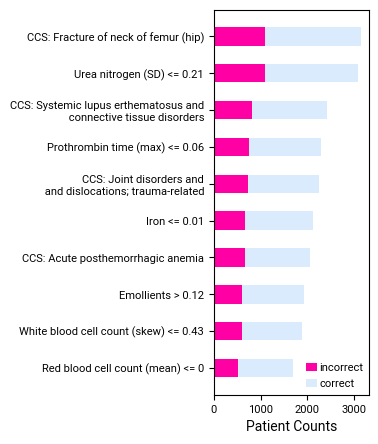

In [130]:
# plot_error(all_preselectall, None)
# plot_error(all_preselectall, 'ucla_crrt+cedars_crrt_8')
plot_error(all_preselectall, 'ucla_crrt+cedars_crrt+ucla_control_200')

0            PHARM_SUBCLASS_OPHTHALMIC STEROIDS > 0.23
1                              HAPTOGLOBIN_len <= 0.44
2                              dx_CCS_CODE_239 <= 0.22
3                              PHOSPHORUS_mean <= 0.06
4    PHARM_SUBCLASS_OTIC AGENTS - MISCELLANEOUS <= ...
5                              dx_CCS_CODE_168 <= 0.46
6    PHARM_SUBCLASS_ANTIRHEUMATIC - ENZYME INHIBITO...
7                   PHARM_SUBCLASS_DIBENZAPINES <= 0.7
8                                dx_CCS_CODE_51 > 0.01
9               PHARM_SUBCLASS_H-2 ANTAGONISTS <= 0.46
Name: nodes_to_leaf, dtype: object


  0%|          | 0/10 [00:00<?, ?it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 10/10 [00:00<00:00, 2212.54it/s]


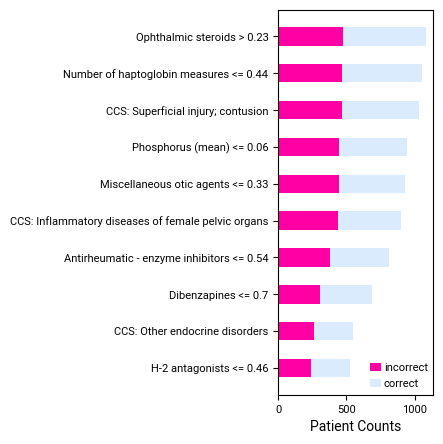

0               OXYHEMOGLOBIN_mean <= 0.21
1    PHARM_SUBCLASS_DIABETIC OTHER <= 0.06
2                  dx_CCS_CODE_137 <= 0.72
3       IMMATURE GRANULOCYTES%_max <= 0.04
4                   WBC, URINE_max <= 0.28
Name: nodes_to_leaf, dtype: object


  0%|          | 0/5 [00:00<?, ?it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 5/5 [00:00<00:00, 2326.29it/s]


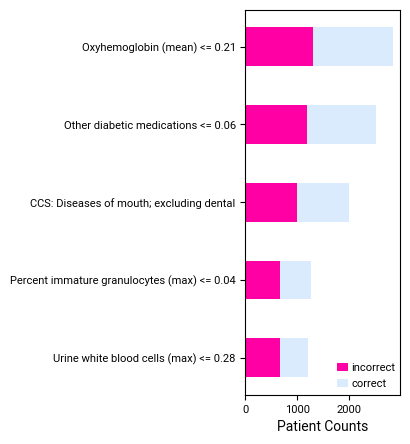

0                             surgery_indicator > 0.05
1    PHARM_SUBCLASS_HEMATAOLOGIC - TYROSINE KINASE ...
2    PHARM_SUBCLASS_GASTRIC ACID SECRETION REDUCERS...
3              B-TYPE NATRIURETIC PEPTIDE_mean <= 0.25
4              PHARM_SUBCLASS_AMINOPENICILLINS <= 0.63
5                  MEAN CORPUSCULAR VOLUME_min <= 0.62
6                               pr_CCS_CODE_662 <= 0.1
7                                   Weight_skew > 0.53
8                                     SpO2_mean > 0.06
Name: nodes_to_leaf, dtype: object


  0%|          | 0/9 [00:00<?, ?it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 9/9 [00:00<00:00, 1800.13it/s]


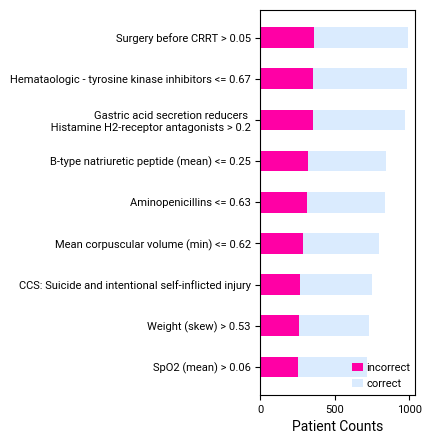

0                              dx_CCS_CODE_129 <= 0.09
1                  ABSOLUTE LYMPHOCYTE COUNT_mean <= 0
2                               dx_CCS_CODE_145 > 0.05
3                              dx_CCS_CODE_213 <= 0.46
4                              dx_CCS_CODE_137 <= 0.78
5                                 pr_CCS_CODE_5 <= 0.5
6                            BLOOD LACTATE_max <= 0.65
7                                     SpO2_std <= 0.14
8    PHARM_SUBCLASS_CEPHALOSPORINS - 1ST GENERATION...
9                                dx_CCS_CODE_36 > 0.38
Name: nodes_to_leaf, dtype: object


  0%|          | 0/10 [00:00<?, ?it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 10/10 [00:00<00:00, 2407.75it/s]


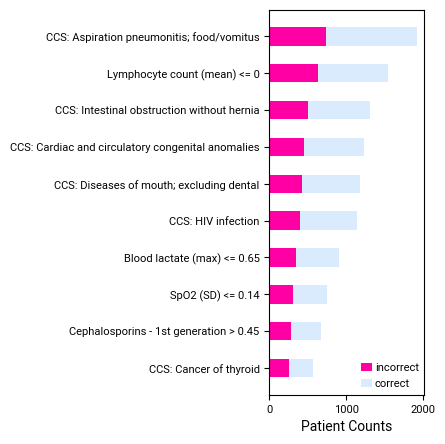

0                    PLATELET COUNT, AUTO_skew <= 0.01
1                               dx_CCS_CODE_251 > 0.17
2                            BILIRUBIN UR_mean <= 0.27
3    PHARM_SUBCLASS_URINARY ANTISPASMODIC - ANTIMUS...
4                              dx_CCS_CODE_168 <= 0.67
5         PHARM_SUBCLASS_BARBITURATE HYPNOTICS <= 0.14
6                            CPT_SECTION_CPT1-F > 0.02
7    PHARM_SUBCLASS_NONDEPOLARIZING MUSCLE RELAXANT...
8                               TROPONIN I_len <= 0.42
9    PHARM_SUBCLASS_CEPHALOSPORINS - 4TH GENERATION...
Name: nodes_to_leaf, dtype: object


  0%|          | 0/10 [00:00<?, ?it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 10/10 [00:00<00:00, 2686.07it/s]


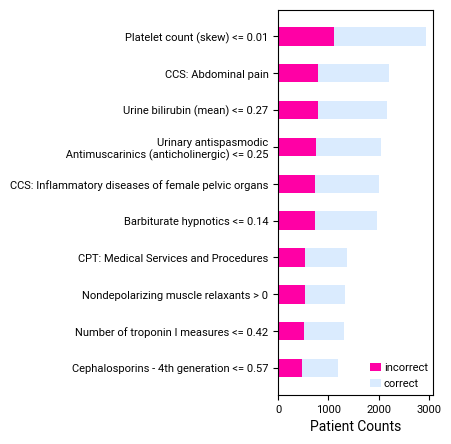

In [131]:
plot_error(ucla_train, 'ucla_crrt_200')
plot_error(ucla_train, 'cedars_crrt_200')
plot_error(cedars_train, 'cedars_crrt_200')
plot_error(cedars_train, 'ucla_crrt_200')
plot_error(uclapluscedars_preselectcrrt, 'ucla_crrt+cedars_crrt_200')

# Explanations

In [157]:
from collections import defaultdict
import seaborn as sns

CONVERSION = {
    'MEAN CORPUSCULAR VOLUME': 'Mean corpuscular volume',
    'Num Prev CRRT Treatments': 'Number of previous CRRT treatments',
    'PHOSPHORUS': "Phosphorus",
    'PH, ARTERIAL': "Arterial pH",
    'CHOLESTEROL,LDL,CALCULATED': "LDL cholesterol",
    'CODE': 'code',
    'surgery_indicator': "Surgery before CRRT",
    'TOBRAMYCIN,PEAK': 'Peak tobramycin',
    'EOSINOPHIL,FLUID': 'eosinophil',
    'VANCOMYCIN,RANDOM': "Vancomycin random level",

    'PCO2, ARTERIAL': 'Arterial PCO2',
    'PCO2,VENOUS': 'Venous PCO2',
    'PHARM_SUBCLASS_ANTIPSYCHOTICS - MISC.': "Antipsychotics",
    'PH,VENOUS': "Venous pH",
    'ADAMTS13 ACTIVITY': "ADAMTS13 activity",
    'TRIGLYCERIDES,FLUID': 'Triglycerides',
    'PHARM_SUBCLASS_CEPHALOSPORINS - 1ST GENERATION': "Cephalosporins - 1st generation",
    'PHENOBARBITAL': "Phenobarbital",
    'IRON BINDING CAPACITY(QST)': "Iron binding capacity",
    'FIBRINOGEN DEGRAD PROD':"Fibrinogen degradation products",
    'GLUCOSE': "Glucose",
    'TOTAL POLYUNSATURATED ACID': "Polyunsaturated acid",
    '5-HYDROXYHEXANOIC, URINE': "Urine 5-hydroxyhexanoic",
    'IONIZED CA++,CORRECTED,ANES': "Ionized calcium",
    'VARICELLA-ZOSTER VIRUS IGM AB': "Varicella-zoster IGM antibody",
    '3-HYDROXYGLUTARIC, URINE': "Urine 3-hydroxyglutaric",
    'VALPROIC ACID': "Valproic acid",
    '% SATURATION(QST)': "Percent iron saturation",
    'ABSOLUTE BASO COUNT': "Basophil count",
    'ALBUMIN/GLOBULIN RATIO(QST)': "Albumin to globulin ratio",
    'BASE EXCESS, ARTERIAL,POC': 'Arterial base excess',
    'URIC ACID(LDQ)': "Uric acid",
    'ETHNICITY': "Ethnicity",
    'APTT 1:1 NORMAL POOL MIX': "Activated partial thromboplastin time",
    'liver_pt_indicator': "Liver comorbidities",
    'WHITE BLOOD CELL COUNT': 'White blood cell count',
     'TACROLIMUS BLOOD': "Tacrolimus blood",
     'MICROALBUMIN/CREATININE RATIO': 'Microalbumin to creatinine ratio',
     'C-REACTIVE PROTEIN': 'C-reactive protein',
    'LEUKOCYTE ALKALINE PHOSPHATASE': "Leukocyte alkaline phosphatase",
        'MONOCLONAL PROTEIN': 'Monoclonal protein',
        'INTERPRETATION IN31 GALACTOAMMAN': 'galactoamman',
        'POTASSIUM,POC': "Potassium",
        '% OF CELLS COUNTED': "Percent of cells counted",
        'PHARM_SUBCLASS_ELECTROLYTE MIXTURES': "Electrolyte mixtures",
        'FERRITIN':"Ferritin",
        'PO2, ARTERIAL': "Arterial PO2",
        'ALT (SGPT)': 'Alanine aminotransferase',
        
        'GAMMA GLOBULINS': "Gamma globulins",
        'VITAMIN B12': 'Vitamin B12',
        'RED BLOOD CELL COUNT': "red blood cell count",
        'HISTOPLASMA ANTIGEN RESULT':"histoplasma antigen",
        'GLYCOLIC, URINE': "urine glycolic",
        'PHENYLACETIC, URINE': "Urine phenylacetic",
        'IONIZED CALCIUM(NON-PATIENT)': "Ionized calcium",
        '2-METHYL,3-HYDROXYBUTYRIC, URINE': 'Urine 2-methyl, 3-hydroxybutyric',
        'BASE EXCESS,ECMO PREMEMBRANE': "ECMO premembrane",
        'PHARM_SUBCLASS_OPHTHALMIC IMMUNOMODULATORS': "Ophthalmic immunomodulators",
        '3-HYDROXYBUTYRIC, URINE': "Urine 3-hydroxybutyric",
        'CPT_SECTION': "CPT section",
        'UREA NITROGEN, 24 HR UR': "Urea nitrogen",
        'Unknown': "Unknown race",
        'URINE CALCIUM-MG/DL': "Urine calcium",
        'T3,TOTAL': 'Triiodothyronine',
        'PHARM_SUBCLASS_PHENOTHIAZINES': "Phenothiazines",
    'PHARM_SUBCLASS_PERIPHERAL OPIOID RECEPTOR ANTAGONISTS': "Peripheral opioid receptor antagonists",
    'ALDOLASE-ALDL': "Alsolase",
    'ALPHA-1-ANTITRYPSIN': 'Alpha-1-antitrypsin',
    'PROTEIN S ANTIGEN,TOTAL': "Protein S antigen",
    'VANCOMYCIN,TROUGH': "Vancomycin trough level",
    'FREE T3': "Free triiodothyronine",
    
    'ABSOLUTE LYMPHOCYTE COUNT': "lymphocyte count",
    'LYMPHOCYTE':"lymphocyte",
    "BICARBONATE, ARTERIAL": "Arterial bicarbonate",
    "CREATININE": "Creatinine",
    "MAGNESIUM": "magnesium",
    "ALKALINE PHOSPHATASE": "Alkaline phosphatase",
    "Height":'height',
    'MEAN CORPUSCULAR HEMOGLOBIN':"Mean corpuscular hemoglobin",
    'MCH CONCENTRATION':"Mean corpuscular hemoglobin (conc.)",
    'VANCOMYCIN,TROUGH': "Vancomycin trough",
    'TOTAL PROTEIN': "Total protein",
    "unspecified nature or uncertain behavior": "unspec. nat./uncert. behav.",
    "PHARM_SUBCLASS_OTIC AGENTS - MISCELLANEOUS": "Miscellaneous otic agents",
    'ABSOLUTE EOS COUNT': 'Eosinophil count',
    'TRANSITIONAL EPITHELIAL CELLS': "Transitional epithelial cells",
    "OXYHEMOGLOBIN": "Oxyhemoglobin",
    "PHARM_SUBCLASS_DIABETIC OTHER": "Other diabetic medications",
    'MEAN CORPUSCULAR VOLUME': "Mean corpuscular volume",
    'MEAN PLATELET VOLUME': "Mean platelet volume",
    'PO2, ARTERIAL': 'Arterial PO2',
    'BICARBONATE, ARTERIAL': 'Arterial bicarbonate',
    'PHOSPHORUS': "Phosphorus",
    "CALCIUM":"Calcium",
    "Glucose,UR": "Urine glucose",
    "TROPONIN I": "troponin I",
    "RED BLOOD CELL COUNT": "Red blood cell count",
    "GLUCOSE": "Glucose",
    'BILIRUBIN UR': "Urine bilirubin",
}

def convert_str(x_axis):
    print(x_axis)
    for i in tqdm(range(len(x_axis))):
        curr_name = x_axis[i]
        # if 'dx_' in curr_name:
        #         curr_name = curr_name.replace('dx_','')
        # if 'pr_' in curr_name:
        #         curr_name = curr_name.replace('pr_','')
        if 'RACE_' in curr_name:
            curr_name = curr_name.replace('RACE_','')
                        
        if curr_name in CODE_MAPPINGS.keys():
                curr_name = CODE_MAPPINGS[curr_name]
        # else:
        for key, val in CONVERSION.items():
                if key in curr_name:
                        curr_name = curr_name.replace(key, val)
                
                
        if '_std' in curr_name:
                curr_name = curr_name.replace('_std',' (SD)')
        if '_min' in curr_name:
                curr_name = curr_name.replace('_min',' (min)')
        if '_mean' in curr_name:
                curr_name = curr_name.replace('_mean',' (mean)')
        if '_max' in curr_name:
                curr_name = curr_name.replace('_max',' (max)')
        if '_skew' in curr_name:
                curr_name = curr_name.replace('_skew',' (skew)')
        if '_len' in curr_name:
                curr_name = "Number of " + curr_name.replace('_len',' measures')
        
        curr_name = curr_name.replace('_', ' ')
        x_axis[i] = curr_name
    return x_axis
        
explanation_dir = os.path.join(output_dir, 'explanation')
os.makedirs(explanation_dir, exist_ok=True)

def reload_shap_values(array_file):
    
    with open(array_file, 'rb') as f:
        shap_arrays = pickle.load(f)
        
    shap_values = shap.Explanation(shap_arrays['values'], 
                                   base_values=shap_arrays['base_values'], 
                                   data=shap_arrays['data'], 
                                   feature_names=shap_arrays['feature_names'])
    
    shap_values.feature_names = convert_str(shap_values.feature_names[:])
            
    return shap_values, shap_arrays

def plot_swarm(shap_values, idxs=None, limit=None,tag=''):
    
    rankings = get_rankings(shap_values, idxs=idxs)[1]
    if limit is not None:
        rankings = rankings[:limit]
    
    if idxs is not None:
        try:
            shap.plots.beeswarm(shap_values[idxs, :, :][:, rankings, 1], show=False,)
        except:
            shap.plots.beeswarm(shap_values[idxs, :][:, rankings], show=False,)
    else:
        try:
            shap.plots.beeswarm(shap_values[:, rankings, 1], show=False,)
        except:
            shap.plots.beeswarm(shap_values[:, rankings], show=False,)
        
    figure = plt.gcf()
    figure.set_size_inches(5,5)
    
    plt.savefig(os.path.join(explanation_dir,f'{tag}_explanation.svg'), format='svg',  bbox_inches="tight")
    plt.show()
    plt.close()
    
    
def plot_waterfall(shap_values, idxs, label, limit=None, tag=''):
    
    # rankings = get_rankings(shap_values, idxs=idxs)[1]
    # if limit is not None:
    #     rankings = rankings[:limit]
    
    rankings = get_rankings(shap_values[[idxs[0]],:], idxs=[0])[1]
    if limit is not None:
        rankings = rankings[:limit]
        

    shap.plots.waterfall(shap_values[idxs[0]][rankings,label], show=False)
    figure = plt.gcf()
    figure.set_size_inches(5,5)
    
    plt.savefig(os.path.join(explanation_dir,f'{tag}_explanation_example.svg'), format='svg',  bbox_inches="tight")
    plt.show()
    plt.close()

def get_rankings(shap_values, idxs=None):
    
    print(shap_values.values.shape)

    if idxs is not None:
        try:
            ranking = np.mean(np.absolute(shap_values.values[idxs,:,:]),axis=0)[:,1].argsort()[::-1]
        except:
            ranking = np.mean(np.absolute(shap_values.values[idxs,:]),axis=0)[:].argsort()[::-1]
    else:
        try:
            ranking = np.mean(np.absolute(np.array(shap_values.values)), axis=0)[:,1].argsort()[::-1]
        except:
            ranking = np.mean(np.absolute(np.array(shap_values.values)), axis=0)[:].argsort()[::-1]
            
    final_rankings = []
    ranked_features = []
    for i in ranking:
        if 'ISSUE DATE' not in shap_values.feature_names[i]:
            final_rankings.append(i)
            ranked_features.append(shap_values.feature_names[i])
    return ranked_features, final_rankings

def collect_rankings(shap_values, idx_list, idx_labels):
    
    table = {'all': get_rankings(shap_values)[0]}
    
    for idx_label, idxs in zip(idx_labels, idx_list):
        table[idx_label] = get_rankings(shap_values, idxs=idxs)[0]
    
    return table 

def display_rankings(table, feature_list=None, limit=None, annot=False, tag=""):
    
    if feature_list is None:
        feature_list = table['all'][:limit]
        
    rankings = defaultdict(dict)
    
    for i in range(len(feature_list)):
        rankings['ALL'][feature_list[i]] = table['all'].index(feature_list[i])+1
    
    for subgroup in table.keys():
        if subgroup == 'all':
            continue
        
        for i in range(len(feature_list)):
            rankings[subgroup.upper()][feature_list[i]] = table[subgroup].index(feature_list[i])+1
        
    sns.heatmap(pd.DataFrame(rankings),cmap=sns.cubehelix_palette(as_cmap=True),
                cbar_kws={'label': 'Feature Importance Rank'},
                annot=annot
                )
    plt.ylabel('Feature')
    
    plt.savefig(os.path.join(explanation_dir,f'{tag}_feature_ranking.svg'), format='svg',  bbox_inches="tight")
    plt.show()
    plt.close()
    
def plot_explanations(run_name, filter, limit=None,conf_matrix_plot = False):
    if filter is None:
        run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // rolling window: 0'")
        filter = ""
    else:
        run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
    pth = join(exp_path, run.info.run_id, 'artifacts','img_artifacts','feature_importance', f"{run.data.tags['modeln']}_test__shap_values.pkl")

    # pth = join('/radraid/jeffreyfeng/CRRT_Project/mlflow/all_to_all_preselectall_tune50_v2/mlruns/383254084501025332/', '5dd07633573c46808fd1183b4172d835', 'artifacts','img_artifacts','feature_importance', f"lgb_test__shap_values.pkl")
    shap_values, shap_arrays = reload_shap_values(pth)
    
    top_features = get_rankings(shap_values)[0]
    
    for i in range(limit):
        for j in range(len(shap_values.feature_names)):
            if top_features[i] == shap_values.feature_names[j]:
                shap_values.feature_names[j] = shap_values.feature_names[j] + f' [{i+1}]'
                break
    
    plot_swarm(shap_values, limit=limit, tag=f'all_{run_name}_{filter}')
    if conf_matrix_plot:
        labels = [1,0,1,0]
        for filt, label in zip(['tp','tn','fp','fn'], labels):
            print(filt)
            plot_swarm(shap_values, shap_arrays[filt], limit=limit, tag=f'{filt}_{run_name}_{filter}')
            # plot_waterfall(shap_values, shap_arrays[filt], label, limit=limit, tag=f'{filt}_{run_name}_{filter}')
    
def plot_feature_rankings(run_name,filter,limit=None, feature_list=None, annot=False):
    if filter is None:
        run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // rolling window: 0'")
    else:
        run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
        
    pth = join(exp_path, run.info.run_id, 'artifacts','img_artifacts','feature_importance', f"{run.data.tags['modeln']}_test__shap_values.pkl")

    # pth = join('/radraid/jeffreyfeng/CRRT_Project/mlflow/all_to_all_preselectall_tune50_v2/mlruns/383254084501025332/', '5dd07633573c46808fd1183b4172d835', 'artifacts','img_artifacts','feature_importance', f"lgb_test__shap_values.pkl")
    shap_values, shap_arrays = reload_shap_values(pth)
    
    table = collect_rankings(shap_values, [shap_arrays[filt] for filt in ['tp','tn','fp','fn']], ['tp','tn','fp','fn'])
    display(pd.DataFrame(table).head(15))
    display_rankings(table, limit=limit, feature_list=feature_list, annot=annot, tag=f'{run_name}_{filter}')


['dx_CCS_CODE_102', 'dx_CCS_CODE_104', 'dx_CCS_CODE_107', 'dx_CCS_CODE_110', 'dx_CCS_CODE_117', 'dx_CCS_CODE_122', 'dx_CCS_CODE_127', 'dx_CCS_CODE_128', 'dx_CCS_CODE_13', 'dx_CCS_CODE_130', 'dx_CCS_CODE_132', 'dx_CCS_CODE_133', 'dx_CCS_CODE_137', 'dx_CCS_CODE_138', 'dx_CCS_CODE_139', 'dx_CCS_CODE_14', 'dx_CCS_CODE_140', 'dx_CCS_CODE_143', 'dx_CCS_CODE_144', 'dx_CCS_CODE_147', 'dx_CCS_CODE_15', 'dx_CCS_CODE_151', 'dx_CCS_CODE_152', 'dx_CCS_CODE_155', 'dx_CCS_CODE_156', 'dx_CCS_CODE_157', 'dx_CCS_CODE_16', 'dx_CCS_CODE_160', 'dx_CCS_CODE_168', 'dx_CCS_CODE_17', 'dx_CCS_CODE_170', 'dx_CCS_CODE_183', 'dx_CCS_CODE_186', 'dx_CCS_CODE_19', 'dx_CCS_CODE_196', 'dx_CCS_CODE_206', 'dx_CCS_CODE_210', 'dx_CCS_CODE_212', 'dx_CCS_CODE_213', 'dx_CCS_CODE_214', 'dx_CCS_CODE_216', 'dx_CCS_CODE_22', 'dx_CCS_CODE_225', 'dx_CCS_CODE_226', 'dx_CCS_CODE_229', 'dx_CCS_CODE_234', 'dx_CCS_CODE_237', 'dx_CCS_CODE_239', 'dx_CCS_CODE_24', 'dx_CCS_CODE_240', 'dx_CCS_CODE_242', 'dx_CCS_CODE_243', 'dx_CCS_CODE_245', 

100%|██████████| 377/377 [00:00<00:00, 598732.53it/s]

(3282, 377)
(3282, 377)
(3282, 377)
(3282, 377)
(3282, 377)


all  \
0                            Surgery before CRRT   
1       CCS: Lung disease due to external agents   
2                                     CCS: Burns   
3                         CCS: Cancer of bladder   
4                              CREATININE (skew)   
5                   BICARBONATE, ARTERIAL (skew)   
6                     ALKALINE PHOSPHATASE (max)   
7                      Number of Height measures   
8             MEAN CORPUSCULAR HEMOGLOBIN (mean)   
9                   Number of MAGNESIUM measures   
10                      MCH CONCENTRATION (mean)   
11  Number of ABSOLUTE LYMPHOCYTE COUNT measures   
12                        infection pt indicator   
13                 WHITE BLOOD CELL COUNT (skew)   
14                  IMMATURE GRANULOCYTES% (min)   

                                              tp  \
0       CCS: Lung disease due to external agents   
1                              CREATININE (skew)   
2                            Surgery before CRRT   
3                                     CCS: Burns   
4             MEAN CORPUSCULAR HEMOGLOBIN (mean)   
5                      Number of Height measures   
6                  WHITE BLOOD CELL COUNT (skew)   
7                         CCS: Cancer of bladder   
8                     ALKALINE PHOSPHATASE (max)   
9                   BICARBONATE, ARTERIAL (skew)   
10                  Number of MAGNESIUM measures   
11                      MCH CONCENTRATION (mean)   
12  Number of ABSOLUTE LYMPHOCYTE COUNT measures   
13                        infection pt indicator   
14                  IMMATURE GRANULOCYTES% (min)   

                                               tn  \
0                             Surgery before CRRT   
1                          CCS: Cancer of bladder   
2                                      CCS: Burns   
3        CCS: Lung disease due to external agents   
4                    BICARBONATE, ARTERIAL (skew)   
5                               CREATININE (skew)   
6                      ALKALINE PHOSPHATASE (max)   
7                       Number of Height measures   
8    Number of ABSOLUTE LYMPHOCYTE COUNT measures   
9                        MCH CONCENTRATION (mean)   
10             MEAN CORPUSCULAR HEMOGLOBIN (mean)   
11                   Number of MAGNESIUM measures   
12  CCS: Poisoning by other medications and drugs   
13                         infection pt indicator   
14                                   Unknown race   

                                              fp  \
0       CCS: Lung disease due to external agents   
1                              CREATININE (skew)   
2                            Surgery before CRRT   
3                                     CCS: Burns   
4                   BICARBONATE, ARTERIAL (skew)   
5                      Number of Height measures   
6                     ALKALINE PHOSPHATASE (max)   
7                         CCS: Cancer of bladder   
8                   Number of MAGNESIUM measures   
9             MEAN CORPUSCULAR HEMOGLOBIN (mean)   
10                      MCH CONCENTRATION (mean)   
11  Number of ABSOLUTE LYMPHOCYTE COUNT measures   
12                        infection pt indicator   
13                 WHITE BLOOD CELL COUNT (skew)   
14                  IMMATURE GRANULOCYTES% (min)   

                                               fn  
0                             Surgery before CRRT  
1        CCS: Lung disease due to external agents  
2                                      CCS: Burns  
3                          CCS: Cancer of bladder  
4                               CREATININE (skew)  
5                      ALKALINE PHOSPHATASE (max)  
6                    BICARBONATE, ARTERIAL (skew)  
7                       Number of Height measures  
8              MEAN CORPUSCULAR HEMOGLOBIN (mean)  
9    Number of ABSOLUTE LYMPHOCYTE COUNT measures  
10                       MCH CONCENTRATION (mean)  
11                   Number of MAGNESIUM measures  
12                   

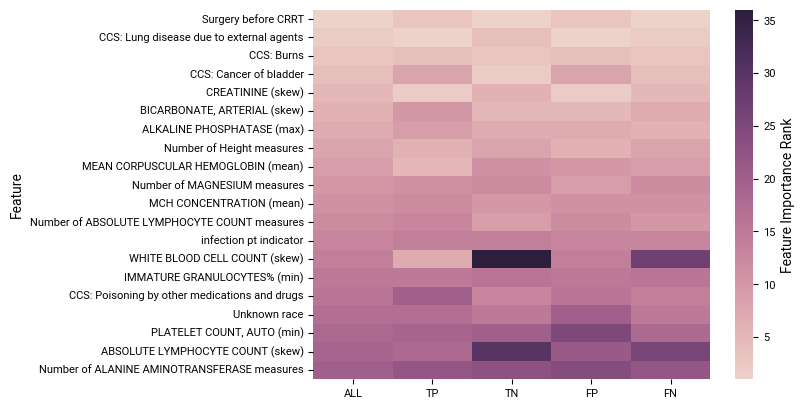

In [85]:
# plot_feature_rankings(all_preselectall, None, limit=50)
plot_feature_rankings(all_preselectall, 'ucla_crrt+cedars_crrt+ucla_control_200', limit=20)

['dx_CCS_CODE_1', 'dx_CCS_CODE_100', 'dx_CCS_CODE_101', 'dx_CCS_CODE_103', 'dx_CCS_CODE_105', 'dx_CCS_CODE_106', 'dx_CCS_CODE_107', 'dx_CCS_CODE_108', 'dx_CCS_CODE_109', 'dx_CCS_CODE_11', 'dx_CCS_CODE_110', 'dx_CCS_CODE_111', 'dx_CCS_CODE_112', 'dx_CCS_CODE_114', 'dx_CCS_CODE_115', 'dx_CCS_CODE_116', 'dx_CCS_CODE_118', 'dx_CCS_CODE_119', 'dx_CCS_CODE_120', 'dx_CCS_CODE_121', 'dx_CCS_CODE_123', 'dx_CCS_CODE_124', 'dx_CCS_CODE_125', 'dx_CCS_CODE_126', 'dx_CCS_CODE_129', 'dx_CCS_CODE_13', 'dx_CCS_CODE_130', 'dx_CCS_CODE_131', 'dx_CCS_CODE_132', 'dx_CCS_CODE_133', 'dx_CCS_CODE_135', 'dx_CCS_CODE_136', 'dx_CCS_CODE_137', 'dx_CCS_CODE_138', 'dx_CCS_CODE_139', 'dx_CCS_CODE_14', 'dx_CCS_CODE_140', 'dx_CCS_CODE_141', 'dx_CCS_CODE_143', 'dx_CCS_CODE_144', 'dx_CCS_CODE_145', 'dx_CCS_CODE_146', 'dx_CCS_CODE_147', 'dx_CCS_CODE_148', 'dx_CCS_CODE_149', 'dx_CCS_CODE_15', 'dx_CCS_CODE_151', 'dx_CCS_CODE_152', 'dx_CCS_CODE_153', 'dx_CCS_CODE_157', 'dx_CCS_CODE_159', 'dx_CCS_CODE_16', 'dx_CCS_CODE_160',

100%|██████████| 621/621 [00:00<00:00, 461328.87it/s]

(3366, 621, 2)
(3366, 621, 2)
(3366, 621, 2)
(3366, 621, 2)
(3366, 621, 2)


all  \
0                                 Surgery before CRRT   
1           CCS: Open wounds of head; neck; and trunk   
2          PHARM SUBCLASS POTASSIUM SPARING DIURETICS   
3   CCS: Peri-; endo-; and myocarditis; cardiomyop...   
4                  CCS: Acute and chronic tonsillitis   
5                  CCS: Superficial injury; contusion   
6              CCS: Diverticulosis and diverticulitis   
7               CCS: Adverse effects of medical drugs   
8                      CCS: Acquired foot deformities   
9                                     TROPONIN I (SD)   
10                                   ANION GAP (mean)   
11          Number of WHITE BLOOD CELL COUNT measures   
12                          RED BLOOD CELL COUNT (SD)   
13                                BILIRUBIN UR (mean)   
14                     EOSINOPHIL PERCENT, AUTO (max)   

                                                   tp  \
0                                 Surgery before CRRT   
1           CCS: Open wounds of head; neck; and trunk   
2          PHARM SUBCLASS POTASSIUM SPARING DIURETICS   
3   CCS: Peri-; endo-; and myocarditis; cardiomyop...   
4                  CCS: Acute and chronic tonsillitis   
5              CCS: Diverticulosis and diverticulitis   
6                                     TROPONIN I (SD)   
7                  CCS: Superficial injury; contusion   
8                                 BILIRUBIN UR (mean)   
9                                    ANION GAP (mean)   
10              CCS: Adverse effects of medical drugs   
11                          RED BLOOD CELL COUNT (SD)   
12                     CCS: Acquired foot deformities   
13                     EOSINOPHIL PERCENT, AUTO (max)   
14          Number of WHITE BLOOD CELL COUNT measures   

                                                   tn  \
0                                 Surgery before CRRT   
1           CCS: Open wounds of head; neck; and trunk   
2          PHARM SUBCLASS POTASSIUM SPARING DIURETICS   
3                  CCS: Superficial injury; contusion   
4               CCS: Adverse effects of medical drugs   
5                  CCS: Acute and chronic tonsillitis   
6   CCS: Peri-; endo-; and myocarditis; cardiomyop...   
7              CCS: Diverticulosis and diverticulitis   
8                      CCS: Acquired foot deformities   
9           Number of WHITE BLOOD CELL COUNT measures   
10                                   ANION GAP (mean)   
11           CCS: Other ear and sense organ disorders   
12      CCS: Complication of device; implant or graft   
13               CCS: Other lower respiratory disease   
14     CCS: Regional enteritis and ulcerative colitis   

                                                   fp  \
0                                 Surgery before CRRT   
1           CCS: Open wounds of head; neck; and trunk   
2          PHARM SUBCLASS POTASSIUM SPARING DIURETICS   
3   CCS: Peri-; endo-; and myocarditis; cardiomyop...   
4                           RED BLOOD CELL COUNT (SD)   
5              CCS: Diverticulosis and diverticulitis   
6                                     TROPONIN I (SD)   
7                  CCS: Acute and chronic tonsillitis   
8                  CCS: Superficial injury; contusion   
9                                    ANION GAP (mean)   
10                     CCS: Acquired foot deformities   
11              CCS: Adverse effects of medical drugs   
12                                BILIRUBIN UR (mean)   
13          Number of WHITE BLOOD CELL COUNT measures   
14                     EOSINOPHIL PERCENT, AUTO (max)   

                                                   fn  
0                                 Surgery before CRRT  
1           CCS: Open wounds of head; neck; and trunk  
2          PHARM SUBCLASS POTASSIUM SPARING DIURETICS  
3                  CCS: Acute and chronic tonsillitis  
4   CCS: Peri-; endo-; and myocarditis; cardiomyop...  
5                  CCS: Superficial injury; contusion  
6     

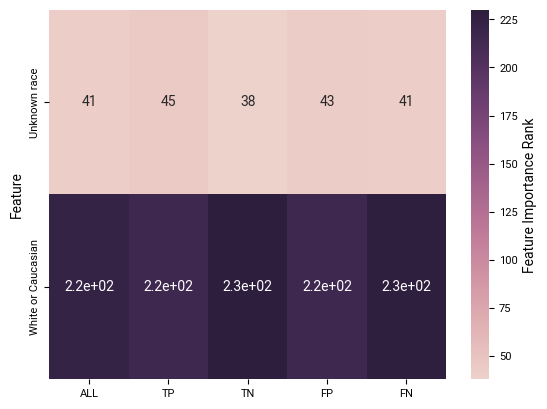

In [80]:
plot_feature_rankings(all_preselectall, 'ucla_crrt+cedars_crrt+ucla_control_200', limit=15, 
feature_list=[
    # 'Asian',
# 'Black or African American',
 'Unknown race',
 'White or Caucasian',
#  'ETHNICITY'
 ],annot=True)

['dx_CCS_CODE_102', 'dx_CCS_CODE_104', 'dx_CCS_CODE_107', 'dx_CCS_CODE_110', 'dx_CCS_CODE_117', 'dx_CCS_CODE_122', 'dx_CCS_CODE_127', 'dx_CCS_CODE_128', 'dx_CCS_CODE_13', 'dx_CCS_CODE_130', 'dx_CCS_CODE_132', 'dx_CCS_CODE_133', 'dx_CCS_CODE_137', 'dx_CCS_CODE_138', 'dx_CCS_CODE_139', 'dx_CCS_CODE_14', 'dx_CCS_CODE_140', 'dx_CCS_CODE_143', 'dx_CCS_CODE_144', 'dx_CCS_CODE_147', 'dx_CCS_CODE_15', 'dx_CCS_CODE_151', 'dx_CCS_CODE_152', 'dx_CCS_CODE_155', 'dx_CCS_CODE_156', 'dx_CCS_CODE_157', 'dx_CCS_CODE_16', 'dx_CCS_CODE_160', 'dx_CCS_CODE_168', 'dx_CCS_CODE_17', 'dx_CCS_CODE_170', 'dx_CCS_CODE_183', 'dx_CCS_CODE_186', 'dx_CCS_CODE_19', 'dx_CCS_CODE_196', 'dx_CCS_CODE_206', 'dx_CCS_CODE_210', 'dx_CCS_CODE_212', 'dx_CCS_CODE_213', 'dx_CCS_CODE_214', 'dx_CCS_CODE_216', 'dx_CCS_CODE_22', 'dx_CCS_CODE_225', 'dx_CCS_CODE_226', 'dx_CCS_CODE_229', 'dx_CCS_CODE_234', 'dx_CCS_CODE_237', 'dx_CCS_CODE_239', 'dx_CCS_CODE_24', 'dx_CCS_CODE_240', 'dx_CCS_CODE_242', 'dx_CCS_CODE_243', 'dx_CCS_CODE_245', 

100%|██████████| 377/377 [00:00<00:00, 115025.29it/s]

(3282, 377)
(3282, 377)


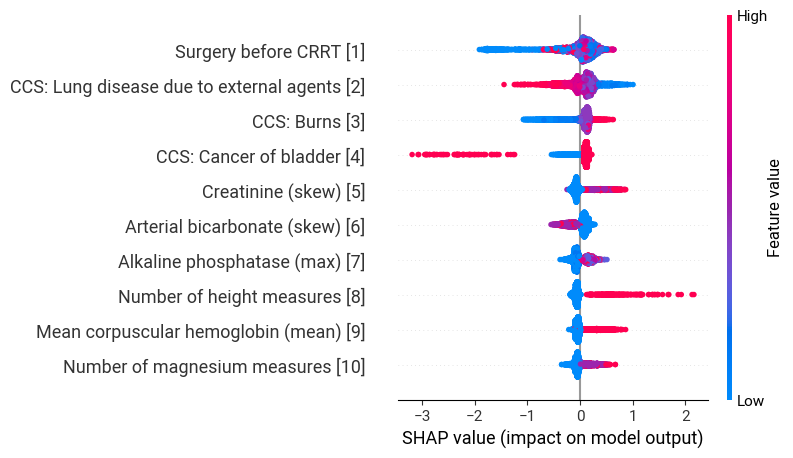

tp
(3282, 377)


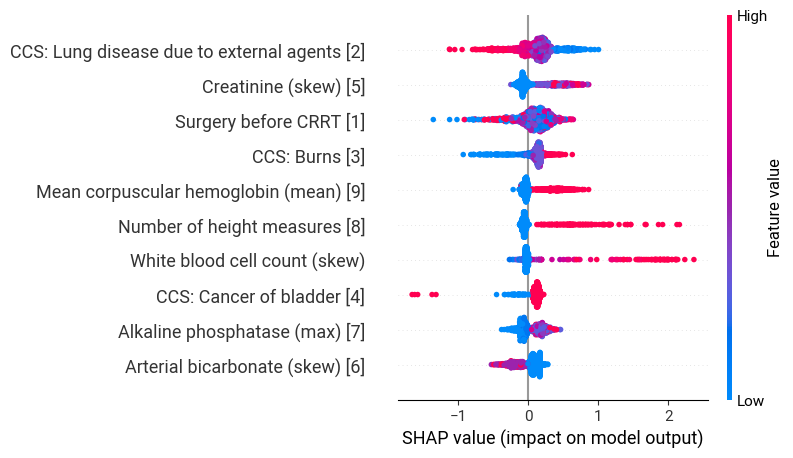

tn
(3282, 377)


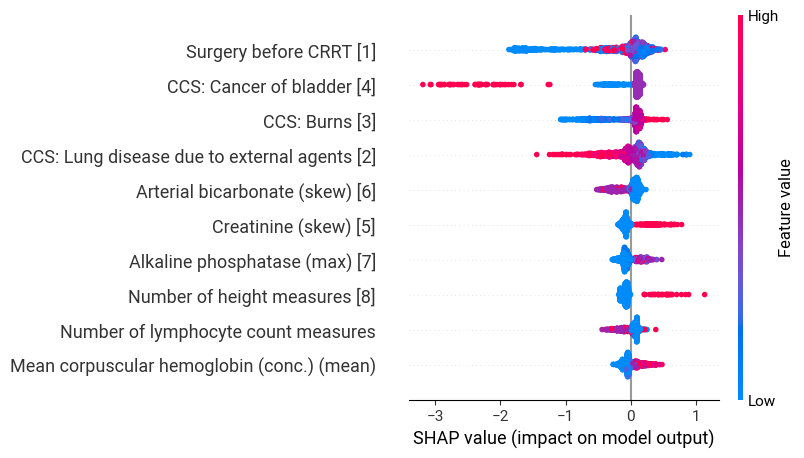

fp
(3282, 377)


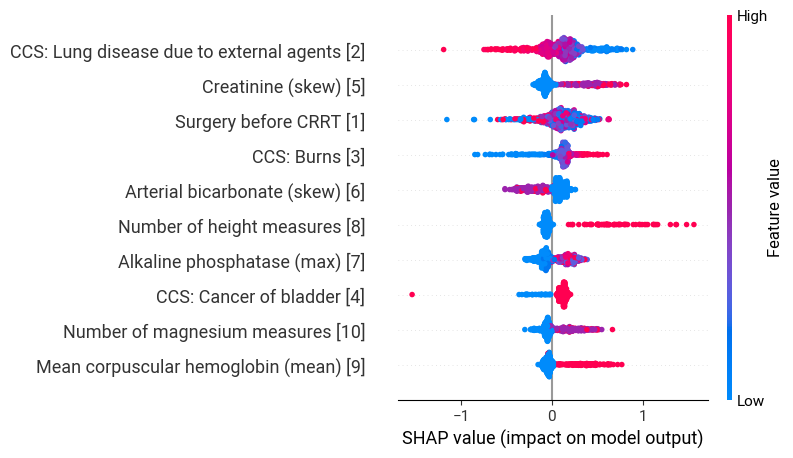

fn
(3282, 377)


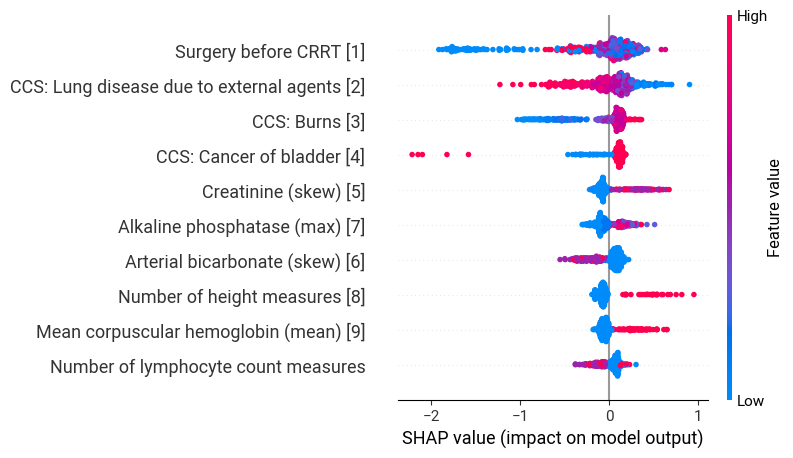

In [158]:
# plot_explanations(all_preselectall, None, limit=10)
# plot_explanations(all_preselectall, 'ucla_crrt+cedars_crrt_8', limit=10)
plot_explanations(all_preselectall, 'ucla_crrt+cedars_crrt+ucla_control_200', limit=10, conf_matrix_plot = True)

['dx_CCS_CODE_108', 'dx_CCS_CODE_110', 'dx_CCS_CODE_114', 'dx_CCS_CODE_115', 'dx_CCS_CODE_120', 'dx_CCS_CODE_126', 'dx_CCS_CODE_130', 'dx_CCS_CODE_132', 'dx_CCS_CODE_133', 'dx_CCS_CODE_134', 'dx_CCS_CODE_136', 'dx_CCS_CODE_137', 'dx_CCS_CODE_144', 'dx_CCS_CODE_145', 'dx_CCS_CODE_146', 'dx_CCS_CODE_15', 'dx_CCS_CODE_151', 'dx_CCS_CODE_152', 'dx_CCS_CODE_161', 'dx_CCS_CODE_162', 'dx_CCS_CODE_164', 'dx_CCS_CODE_165', 'dx_CCS_CODE_168', 'dx_CCS_CODE_17', 'dx_CCS_CODE_18', 'dx_CCS_CODE_181', 'dx_CCS_CODE_197', 'dx_CCS_CODE_198', 'dx_CCS_CODE_199', 'dx_CCS_CODE_2', 'dx_CCS_CODE_200', 'dx_CCS_CODE_204', 'dx_CCS_CODE_212', 'dx_CCS_CODE_214', 'dx_CCS_CODE_215', 'dx_CCS_CODE_217', 'dx_CCS_CODE_233', 'dx_CCS_CODE_234', 'dx_CCS_CODE_235', 'dx_CCS_CODE_236', 'dx_CCS_CODE_237', 'dx_CCS_CODE_238', 'dx_CCS_CODE_239', 'dx_CCS_CODE_25', 'dx_CCS_CODE_250', 'dx_CCS_CODE_251', 'dx_CCS_CODE_252', 'dx_CCS_CODE_43', 'dx_CCS_CODE_44', 'dx_CCS_CODE_45', 'dx_CCS_CODE_46', 'dx_CCS_CODE_48', 'dx_CCS_CODE_50', 'dx_

100%|██████████| 235/235 [00:00<00:00, 110092.87it/s]

(1746, 235, 2)
(1746, 235, 2)


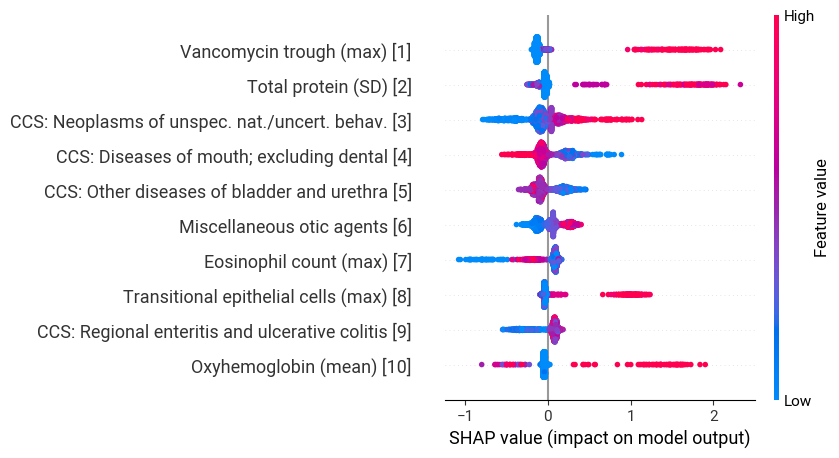

['dx_CCS_CODE_108', 'dx_CCS_CODE_110', 'dx_CCS_CODE_114', 'dx_CCS_CODE_115', 'dx_CCS_CODE_120', 'dx_CCS_CODE_126', 'dx_CCS_CODE_130', 'dx_CCS_CODE_132', 'dx_CCS_CODE_133', 'dx_CCS_CODE_134', 'dx_CCS_CODE_136', 'dx_CCS_CODE_137', 'dx_CCS_CODE_144', 'dx_CCS_CODE_145', 'dx_CCS_CODE_146', 'dx_CCS_CODE_15', 'dx_CCS_CODE_151', 'dx_CCS_CODE_152', 'dx_CCS_CODE_161', 'dx_CCS_CODE_162', 'dx_CCS_CODE_164', 'dx_CCS_CODE_165', 'dx_CCS_CODE_168', 'dx_CCS_CODE_17', 'dx_CCS_CODE_18', 'dx_CCS_CODE_181', 'dx_CCS_CODE_197', 'dx_CCS_CODE_198', 'dx_CCS_CODE_199', 'dx_CCS_CODE_2', 'dx_CCS_CODE_200', 'dx_CCS_CODE_204', 'dx_CCS_CODE_212', 'dx_CCS_CODE_214', 'dx_CCS_CODE_215', 'dx_CCS_CODE_217', 'dx_CCS_CODE_233', 'dx_CCS_CODE_234', 'dx_CCS_CODE_235', 'dx_CCS_CODE_236', 'dx_CCS_CODE_237', 'dx_CCS_CODE_238', 'dx_CCS_CODE_239', 'dx_CCS_CODE_25', 'dx_CCS_CODE_250', 'dx_CCS_CODE_251', 'dx_CCS_CODE_252', 'dx_CCS_CODE_43', 'dx_CCS_CODE_44', 'dx_CCS_CODE_45', 'dx_CCS_CODE_46', 'dx_CCS_CODE_48', 'dx_CCS_CODE_50', 'dx_

100%|██████████| 235/235 [00:00<00:00, 110698.72it/s]

(2867, 235, 2)
(2867, 235, 2)


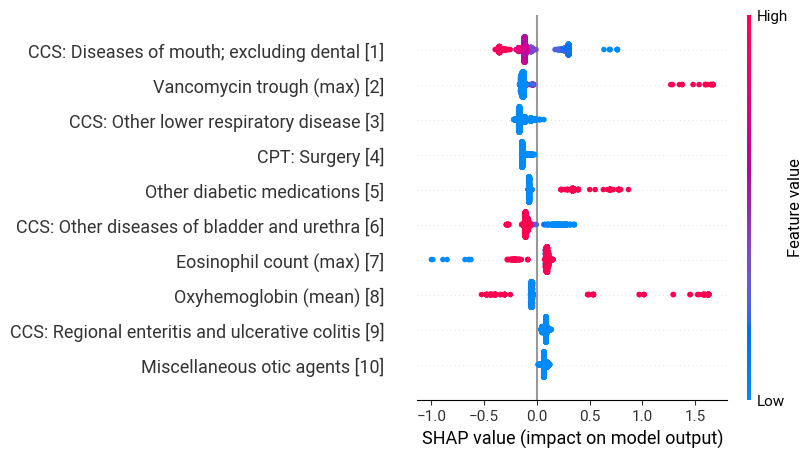

['dx_CCS_CODE_1', 'dx_CCS_CODE_100', 'dx_CCS_CODE_103', 'dx_CCS_CODE_109', 'dx_CCS_CODE_11', 'dx_CCS_CODE_116', 'dx_CCS_CODE_118', 'dx_CCS_CODE_129', 'dx_CCS_CODE_131', 'dx_CCS_CODE_133', 'dx_CCS_CODE_134', 'dx_CCS_CODE_137', 'dx_CCS_CODE_144', 'dx_CCS_CODE_145', 'dx_CCS_CODE_146', 'dx_CCS_CODE_147', 'dx_CCS_CODE_15', 'dx_CCS_CODE_151', 'dx_CCS_CODE_152', 'dx_CCS_CODE_158', 'dx_CCS_CODE_16', 'dx_CCS_CODE_165', 'dx_CCS_CODE_171', 'dx_CCS_CODE_172', 'dx_CCS_CODE_175', 'dx_CCS_CODE_2', 'dx_CCS_CODE_201', 'dx_CCS_CODE_202', 'dx_CCS_CODE_203', 'dx_CCS_CODE_204', 'dx_CCS_CODE_205', 'dx_CCS_CODE_210', 'dx_CCS_CODE_213', 'dx_CCS_CODE_214', 'dx_CCS_CODE_215', 'dx_CCS_CODE_216', 'dx_CCS_CODE_217', 'dx_CCS_CODE_239', 'dx_CCS_CODE_243', 'dx_CCS_CODE_244', 'dx_CCS_CODE_245', 'dx_CCS_CODE_246', 'dx_CCS_CODE_247', 'dx_CCS_CODE_248', 'dx_CCS_CODE_25', 'dx_CCS_CODE_250', 'dx_CCS_CODE_251', 'dx_CCS_CODE_252', 'dx_CCS_CODE_256', 'dx_CCS_CODE_257', 'dx_CCS_CODE_258', 'dx_CCS_CODE_2609', 'dx_CCS_CODE_2617'

100%|██████████| 391/391 [00:00<00:00, 65168.80it/s]

(1316, 391, 2)
(1316, 391, 2)


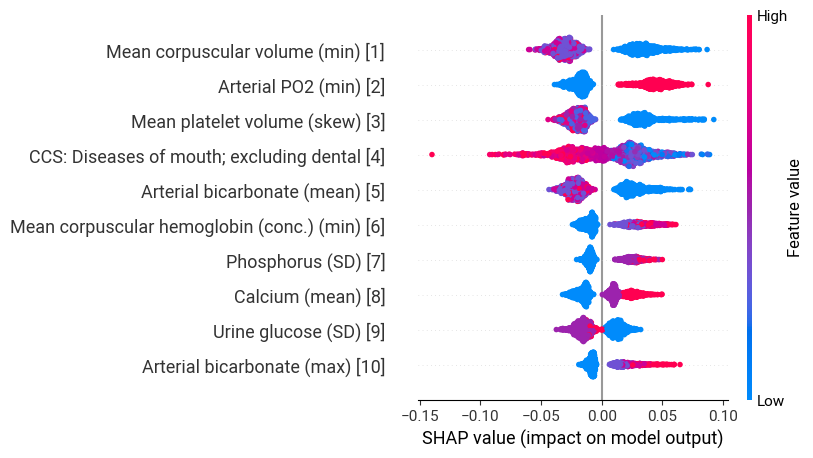

['dx_CCS_CODE_1', 'dx_CCS_CODE_100', 'dx_CCS_CODE_103', 'dx_CCS_CODE_109', 'dx_CCS_CODE_11', 'dx_CCS_CODE_116', 'dx_CCS_CODE_118', 'dx_CCS_CODE_129', 'dx_CCS_CODE_131', 'dx_CCS_CODE_133', 'dx_CCS_CODE_134', 'dx_CCS_CODE_137', 'dx_CCS_CODE_144', 'dx_CCS_CODE_145', 'dx_CCS_CODE_146', 'dx_CCS_CODE_147', 'dx_CCS_CODE_15', 'dx_CCS_CODE_151', 'dx_CCS_CODE_152', 'dx_CCS_CODE_158', 'dx_CCS_CODE_16', 'dx_CCS_CODE_165', 'dx_CCS_CODE_171', 'dx_CCS_CODE_172', 'dx_CCS_CODE_175', 'dx_CCS_CODE_2', 'dx_CCS_CODE_201', 'dx_CCS_CODE_202', 'dx_CCS_CODE_203', 'dx_CCS_CODE_204', 'dx_CCS_CODE_205', 'dx_CCS_CODE_210', 'dx_CCS_CODE_213', 'dx_CCS_CODE_214', 'dx_CCS_CODE_215', 'dx_CCS_CODE_216', 'dx_CCS_CODE_217', 'dx_CCS_CODE_239', 'dx_CCS_CODE_243', 'dx_CCS_CODE_244', 'dx_CCS_CODE_245', 'dx_CCS_CODE_246', 'dx_CCS_CODE_247', 'dx_CCS_CODE_248', 'dx_CCS_CODE_25', 'dx_CCS_CODE_250', 'dx_CCS_CODE_251', 'dx_CCS_CODE_252', 'dx_CCS_CODE_256', 'dx_CCS_CODE_257', 'dx_CCS_CODE_258', 'dx_CCS_CODE_2609', 'dx_CCS_CODE_2617'

100%|██████████| 391/391 [00:00<00:00, 128989.53it/s]

(3698, 391, 2)
(3698, 391, 2)


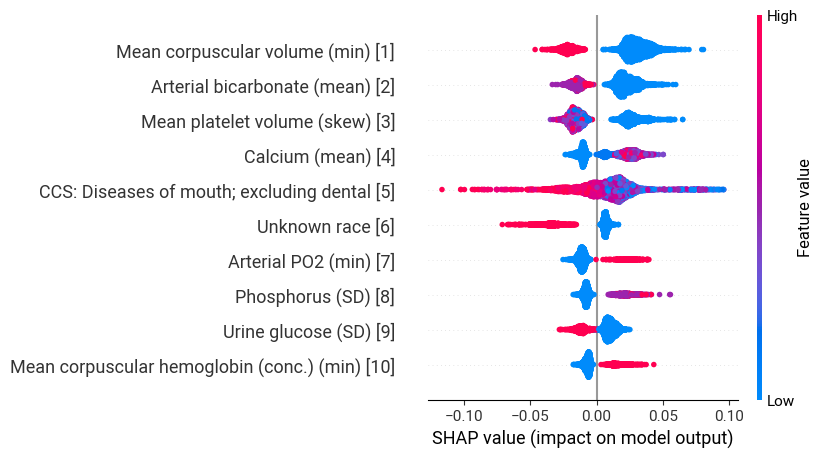

['dx_CCS_CODE_1', 'dx_CCS_CODE_103', 'dx_CCS_CODE_108', 'dx_CCS_CODE_109', 'dx_CCS_CODE_11', 'dx_CCS_CODE_110', 'dx_CCS_CODE_112', 'dx_CCS_CODE_116', 'dx_CCS_CODE_118', 'dx_CCS_CODE_124', 'dx_CCS_CODE_125', 'dx_CCS_CODE_126', 'dx_CCS_CODE_127', 'dx_CCS_CODE_128', 'dx_CCS_CODE_132', 'dx_CCS_CODE_135', 'dx_CCS_CODE_136', 'dx_CCS_CODE_137', 'dx_CCS_CODE_141', 'dx_CCS_CODE_142', 'dx_CCS_CODE_146', 'dx_CCS_CODE_147', 'dx_CCS_CODE_148', 'dx_CCS_CODE_149', 'dx_CCS_CODE_15', 'dx_CCS_CODE_153', 'dx_CCS_CODE_154', 'dx_CCS_CODE_161', 'dx_CCS_CODE_168', 'dx_CCS_CODE_17', 'dx_CCS_CODE_171', 'dx_CCS_CODE_183', 'dx_CCS_CODE_19', 'dx_CCS_CODE_210', 'dx_CCS_CODE_211', 'dx_CCS_CODE_212', 'dx_CCS_CODE_213', 'dx_CCS_CODE_214', 'dx_CCS_CODE_216', 'dx_CCS_CODE_228', 'dx_CCS_CODE_229', 'dx_CCS_CODE_23', 'dx_CCS_CODE_239', 'dx_CCS_CODE_24', 'dx_CCS_CODE_240', 'dx_CCS_CODE_243', 'dx_CCS_CODE_244', 'dx_CCS_CODE_246', 'dx_CCS_CODE_247', 'dx_CCS_CODE_251', 'dx_CCS_CODE_256', 'dx_CCS_CODE_257', 'dx_CCS_CODE_258', 

100%|██████████| 248/248 [00:00<00:00, 111632.04it/s]

(3092, 248, 2)
(3092, 248, 2)


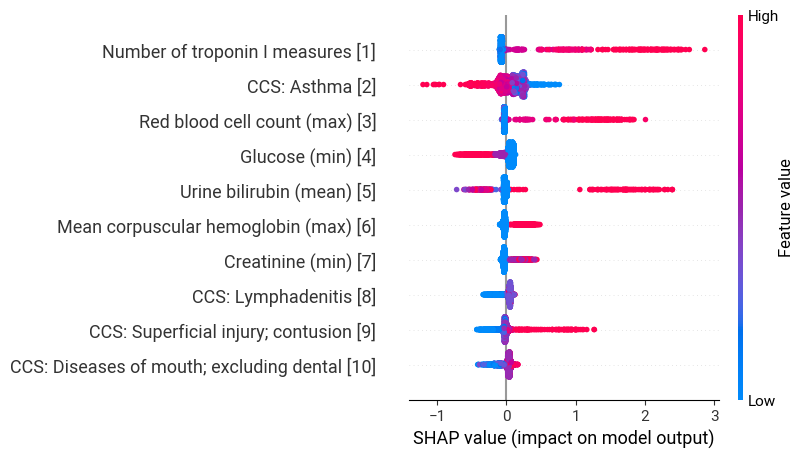

In [159]:
plot_explanations(ucla_train, 'ucla_crrt_200', limit=10)
plot_explanations(ucla_train, 'cedars_crrt_200', limit=10)
plot_explanations(cedars_train, 'cedars_crrt_200', limit=10)
plot_explanations(cedars_train, 'ucla_crrt_200', limit=10)
plot_explanations(uclapluscedars_preselectcrrt, 'ucla_crrt+cedars_crrt_200', limit=10)

# Split counts

In [67]:
def get_split_count(
              run_names, filters,):
    
    table = {'train': {},
             'val': {},
             'test': {},
             'percent': {}}
    
    for run_name, filter in zip(run_names, filters):
        print(run_name, filter)
        if len(filter) > 0:
            run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
        else:
            run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // eval best'")

        prefix = f"{run.data.tags['modeln']}_test"
        labels_path = join(exp_path, run.info.run_id, "artifacts", run_name, "labels", f"{prefix}__{run_name}","labels.pkl")
        labels = pickle.load(open(labels_path, 'rb'))
        # test_size = len(labels.index.get_level_values('IP_PATIENT_ID').unique())
        test_size = len(labels)

        try:
            best_run = run.data.tags['best_run_id']
        except:
            best_run = run.data.tags['best_model_path'].split('/artifacts')[0].split('/')[-1]
        client_path = join(mlflow_path, run_name, 'mlruns')
        client =  mlflow.tracking.MlflowClient(f"file://{client_path}")
        best_run = client.get_run(best_run)
        
        #####################
        from data.subpopulation_utils import generate_filters
        from data.sklearn_loaders import SklearnCRRTDataModule, LOCAL_DATA_DIR

        best_model_path = join(mlflow_path,main.get_mlflow_model_uri(best_run).split('mlflow/')[-1])
        modeln = run.data.tags["modeln"]

        # split the best params into the ones that should be in model_kwargs and not
        top_level_params = {}
        model_kwargs = {}
        for param_name, param_val in best_run.data.tags.items():
            if param_name.startswith(modeln):
                # exclude the rf_ if modeln is rf
                raw_name = param_name[len(f"{args.modeln}") :]
                model_kwargs[raw_name] = param_val
            elif param_name.startswith('mlflow'):
                pass
            else:
                top_level_params[param_name] = reinit_param_from_string(args, param_name, param_val)
        model_kwargs.update(best_run.data.params)
        
        top_level_params['ucla_control_data_dir'] = '/radraid/jeffreyfeng/CRRT_Project/Data/Controls_v6'
        top_level_params['ucla_crrt_data_dir'] = '/radraid/jeffreyfeng/CRRT_Project/Data/UCLA_v6'
        top_level_params['cedars_crrt_data_dir'] = '/radraid/jeffreyfeng/CRRT_Project/Data/Cedars_v6'
        top_level_params['local_log_path']= join(mlflow_path,top_level_params['local_log_path'].split('mlflow/')[-1])
        
        dargs = vars(args)
        dargs.update(
            {
                **top_level_params,
                # modeln is selected outside of optuna so it wont be in params
                "modeln": modeln,
                # model_kwargs in best_trial.params but flattened out
                # "model_kwargs": model_kwargs,
                # "best_run_id": run.info.run_id,
                "best_model_path": best_model_path,
                "stage": "eval",
                "rolling_evaluation": True,
                "reference_window": True,
                "slide_window_by": 0,
                "tune_n_trials": 0,
                
                # "pre_start_delta": {'YEARS': 0, 'MONTHS': 0, 'DAYS': 7},
                # 'time_interval': '1D',
                # "new_eval_cohort": True,
                # "max_days_on_crrt": 200,
                # "min_days_on_crrt": 8,
                # "eval_cohort": 'ucla_crrt' if filter == '' else 'cedars_crrt',
                # "train_val_cohort": 'ucla_crrt' if 'ucla_control' in args.train_val_cohort else args.train_val_cohort, # doesn't matter, so just use cedars which is fastest

                # use for explanation run
                # "plot_names": ["shap_explain", "randomness", "error_viz"],
            }
        )
        filters = generate_filters()
        filters = {
            k: v for groupname, d in filters.items() for k, v in d.items()
        }  # flatten
        data = SklearnCRRTDataModule.from_argparse_args(args, filters=generate_filters())
        (
            reference_ids,
            original_columns,
            data_transform,
        ) = data.load_data_params(join(args.best_model_path, "static_data"))

        data.setup(
            args,
            reference_ids=reference_ids,
            reference_cols=None,
            data_transform=data_transform,
        )
        print(data.train[0].shape)
        print(np.unique(data.train[1],return_counts=True))
        print(data.val[0].shape)
        print(np.unique(data.val[1],return_counts=True))
        print(data.test[0].shape)
        print(np.unique(data.test[1],return_counts=True))
        with open('./index_debug.pkl', "wb") as f:
            pickle.dump(data.split_pt_ids,f)
        ##########################
        
        split_path = join(exp_path, best_run.info.run_id, "artifacts", 'static_data', "split_ids.pkl")
        splits = pickle.load(open(split_path, 'rb'))
        
        # assert test_size == len(splits['test'])
        table['train'][f'{run_name} {filter}']=len(splits['train'])
        table['val'][f'{run_name} {filter}']=len(splits['val'])
        table['test'][f'{run_name} {filter}']=test_size
        table['percent'][f'{run_name} {filter}']=(test_size-labels.value_counts()[0])/test_size*100
        print('')

    display(pd.DataFrame(table))

In [73]:
runs = [
        # ucla_train,
        # ucla_train,
        # ucla_train,
        # cedars_train,
        # cedars_train,
        # cedars_train,
        # uclapluscedars_train,
        # uclapluscedars_train,
        # all_train,
        # uclapluscedars_preselectcrrt,
        all_preselectall
        ]
filters = [
        '',
        'cedars_crrt',
        'ucla_control',
        '',
        'ucla_crrt',
        'ucla_control',
        '',
        'ucla_control',
        '',
        '',
        ''
        ]
get_split_count(runs,filters)

all_to_all_preselectall_tune100_v21 
Keeping 2055 columns from 10233
Keeping 1123 raw features from 2645
All original: 10233, 2645
Keeping 1130 columns from 4103
Keeping 726 raw features from 1287
All original: 4103, 1287
Keeping 1516 columns from 5736
Keeping 859 raw features from 1664
All original: 5736, 1664
861 columns across all cohorts
2054 in ucla_crrt cohort. Removed 1193 columns
1129 in cedars_crrt cohort. Removed 268 columns
1515 in ucla_control cohort. Removed 654 columns
Original raw features 556
Keeping 2055 columns from 10233
Keeping 1123 raw features from 2645
Keeping 1130 columns from 4103
Keeping 726 raw features from 1287
Keeping 1516 columns from 5736
Keeping 859 raw features from 1664
All original: 12966, 3220
(2999, 377)
(array([0, 1]), array([1769, 1230]))
(1015, 377)
(array([0, 1]), array([591, 424]))
(991, 377)
(array([0, 1]), array([607, 384]))



train  val  test    percent
all_to_all_preselectall_tune100_v21    2828  943   991  38.748739

In [75]:
runs = [
        ucla_train,
        ucla_train,
        ucla_train,
        cedars_train,
        cedars_train,
        cedars_train,
        uclapluscedars_train,
        uclapluscedars_train,
        all_train,
        ucla_preselectall,
        ucla_preselectcrrt,
        cedars_preselectall,
        cedars_preselectcrrt,
        uclapluscedars_preselectall,
        uclapluscedars_preselectcrrt,
        all_preselectall
        ]
filters = [
        '',
        'cedars_crrt',
        'ucla_control',
        '',
        'ucla_crrt',
        'ucla_control',
        '',
        'ucla_control',
        '',
        '',
        '',
        '',
        '',
        '',
        '',
        '',
        ''
        ]
get_split_count(runs,filters)

ucla_to_ucla_tune100_v21 
Keeping 1487 columns from 8529
Keeping 973 raw features from 2302
All original: 8529, 2302
(1268, 235)
(array([0, 1]), array([613, 655]))
(417, 235)
(array([0, 1]), array([202, 215]))
(425, 235)
(array([0, 1]), array([203, 222]))

ucla_to_ucla_tune100_v21 cedars_crrt
Keeping 1487 columns from 8529
Keeping 973 raw features from 2302
All original: 8529, 2302
(1268, 235)
(array([0, 1]), array([613, 655]))
(417, 235)
(array([0, 1]), array([202, 215]))
(425, 235)
(array([0, 1]), array([203, 222]))

ucla_to_ucla_tune100_v21 ucla_control
Keeping 1487 columns from 8529
Keeping 973 raw features from 2302
All original: 8529, 2302
(1268, 235)
(array([0, 1]), array([613, 655]))
(417, 235)
(array([0, 1]), array([202, 215]))
(425, 235)
(array([0, 1]), array([203, 222]))

cedars_to_cedars_tune100_v21 
Keeping 1130 columns from 4103
Keeping 726 raw features from 1287
All original: 4103, 1287
(1073, 239)
(array([0, 1]), array([525, 548]))
(353, 239)
(array([0, 1]), array([176,

train  val  test  \
ucla_to_ucla_tune100_v21                             1160  387   425   
ucla_to_ucla_tune100_v21 cedars_crrt                 1160  387  1788   
ucla_to_ucla_tune100_v21 ucla_control                1160  387   774   
cedars_to_cedars_tune100_v21                         1011  338   366   
cedars_to_cedars_tune100_v21 ucla_crrt               1011  338  2149   
cedars_to_cedars_tune100_v21 ucla_control            1011  338  1064   
uclapluscedars_to_uclapluscedars_tune100_v21         2181  727   785   
uclapluscedars_to_uclapluscedars_tune100_v21 uc...   2181  727   926   
all_to_all_tune100_v21                               2828  943   991   
ucla_to_ucla_preselectall_tune100_v21                1161  388   430   
ucla_to_ucla_preselectcrrt_tune100_v21               1160  387   425   
cedars_to_cedars_preselectall_tune100_v21            1011  338   366   
cedars_to_cedars_preselectcrrt_tune100_v21           1011  338   366   
uclapluscedars_to_uclapluscedars_preselectall_t...   2177  726   781   
uclapluscedars_to_uclapluscedars_preselectcrrt_...   2181  727   785   
all_to_all_preselectall_tune100_v21                  2828  943   991   

                                                      percent  
ucla_to_ucla_tune100_v21                            52.235294  
ucla_to_ucla_tune100_v21 cedars_crrt                51.621924  
ucla_to_ucla_tune100_v21 ucla_control                0.000000  
cedars_to_cedars_tune100_v21                        54.644809  
cedars_to_cedars_tune100_v21 ucla_crrt              51.791531  
cedars_to_cedars_tune100_v21 ucla_control            0.000000  
uclapluscedars_to_uclapluscedars_tune100_v21        52.738854  
uclapluscedars_to_uclapluscedars_tune100_v21 uc...   0.000000  
all_to_all_tune100_v21                              38.748739  
ucla_to_ucla_preselectall_tune100_v21               52.558140  
ucla_to_ucla_preselectcrrt_tune100_v21              52.235294  
cedars_to_cedars_preselectall_tune100_v21           54.644809  
cedars_to_cedars_preselectcrrt_tune100_v21          54.644809  
uclapluscedars_to_uclapluscedars_preselectall_t...  51.728553  
uclapluscedars_to_uclapluscedars_preselectcrrt_...  52.738854  
all_to_all_preselectall_tune100_v21                 38.748739

# Run Params

In [11]:
from tqdm import tqdm
import cloudpickle

def get_feature_counts(
              run_names, filters,):
    
    table = {
            'model': {},
            'window': {},
            'impute': {},
            'feature_selection': {},
            'thresh': {},
            'raw_features': {},
             'engineered_features': {},
             'model_used_raw_features': {},
             'model_used_engineered_features': {}}
       
    for run_name, filter in tqdm(zip(run_names, filters)):
        
        if len(filter) > 0:
            run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // post_eval_{filter} best'")
        else:
            run, exp_path = get_run_from_name(mlflow_path, run_name, filter=f"tags.mlflow.runName='{run_name} // eval best'")

        prefix = f"{run.data.tags['modeln']}_test"
        labels_path = join(exp_path, run.info.run_id, "artifacts", run_name, "labels", f"{prefix}__{run_name}","labels.pkl")
        labels = pickle.load(open(labels_path, 'rb'))
        # test_size = len(labels.index.get_level_values('IP_PATIENT_ID').unique())
        test_size = len(labels)

        try:
            best_run = run.data.tags['best_run_id']
        except:
            best_run = run.data.tags['best_model_path'].split('/artifacts')[0].split('/')[-1]
        client_path = join(mlflow_path, run_name, 'mlruns')
        client =  mlflow.tracking.MlflowClient(f"file://{client_path}")
        best_run = client.get_run(best_run)
        
        tform_path = join(exp_path, best_run.info.run_id, "artifacts", 'static_data', "data_transform.pkl")
        tform = cloudpickle.load(open(tform_path, 'rb'))
        
        col_path = join(exp_path, best_run.info.run_id, "artifacts", 'static_data', "columns.pkl")
        cols = pickle.load(open(col_path, 'rb'))
        
        selected_columns_mask = tform.__self__.named_steps[
            "feature-selection"
        ].get_support()
        selected_columns = cols[selected_columns_mask]
                
        unique_features = (
        cols.str.replace(".*_indicator", "indicator", regex=True)
        .str.replace("RACE.*", "RACE", regex=True)
        # tobacco/smoking/allergen aren't currenly in the intersection of features for all 3 cohorts, i've included it here just in case
        .str.replace(".*TOBACCO_USER.*", "TOBACCO_USER", regex=True)
        .str.replace(".*SMOKING_TOB_STATUS.*", "SMOKING_TOB_STATUS", regex=True)
        .str.replace(".*ALLERGEN_ID.*", "ALLERGEN_ID", regex=True)
        .str.replace("_(mean|min|max|std|skew|len)", "", regex=True)
        .unique()
        )
        
        unique_features_model = (
        selected_columns.str.replace(".*_indicator", "indicator", regex=True)
        .str.replace("RACE.*", "RACE", regex=True)
        # tobacco/smoking/allergen aren't currenly in the intersection of features for all 3 cohorts, i've included it here just in case
        .str.replace(".*TOBACCO_USER.*", "TOBACCO_USER", regex=True)
        .str.replace(".*SMOKING_TOB_STATUS.*", "SMOKING_TOB_STATUS", regex=True)
        .str.replace(".*ALLERGEN_ID.*", "ALLERGEN_ID", regex=True)
        .str.replace("_(mean|min|max|std|skew|len)", "", regex=True)
        .unique()
        )
                
        table['model'][f'{run_name} {filter}'] = best_run.data.tags['modeln']
        table['window'][f'{run_name} {filter}'] = best_run.data.tags['pre_start_delta']
        table['impute'][f'{run_name} {filter}'] = best_run.data.tags['impute_method']
        if best_run.data.tags['corr_thresh'] is not None:
            table['feature_selection'][f'{run_name} {filter}'] = 'corr_thresh'
            table['thresh'][f'{run_name} {filter}'] = best_run.data.tags['corr_thresh']
        else:
            table['feature_selection'][f'{run_name} {filter}'] = 'kbest'
            table['thresh'][f'{run_name} {filter}'] = best_run.data.tags['kbest']
        
        if 'drop_percent' in best_run.data.tags:
            table['missingness threshold'] = best_run.data.tags['drop_percent']
        
        table['raw_features'][f'{run_name} {filter}']=len(unique_features)
        table['engineered_features'][f'{run_name} {filter}']=len(cols)
        table['model_used_raw_features'][f'{run_name} {filter}']=len(unique_features_model)
        table['model_used_engineered_features'][f'{run_name} {filter}']=len(selected_columns)
    
    display(pd.DataFrame(table))

In [62]:
runs = [
        ucla_train,
        # ucla_train,
        # ucla_train,
        cedars_train,
        # cedars_train,
        # cedars_train,
        uclapluscedars_train,
        # uclapluscedars_train,
        all_train,
        ucla_preselectall,
        # ucla_preselectall,
        # ucla_preselectall,
        ucla_preselectcrrt,
        # ucla_preselectcrrt,
        cedars_preselectall,
        # cedars_preselectall,
        # cedars_preselectall,
        cedars_preselectcrrt,
        # cedars_preselectcrrt,
        uclapluscedars_preselectall,
        # uclapluscedars_preselectall,
        uclapluscedars_preselectcrrt,
        all_preselectall
        ]
filters = [
        '',
        # 'cedars_crrt',
        # 'ucla_control',
        '',
        # 'ucla_crrt',
        # 'ucla_control',
        '',
        # 'ucla_control',
        '',
        "",
        # "cedars_crrt",
        # "ucla_control",
        "",
        # "cedars_crrt",
        '',
        # 'ucla_crrt',
        # 'ucla_control',
        '',
        # 'ucla_crrt',
        '',
        # 'ucla_control',
        '',
        ''
        ]
get_feature_counts(runs,filters)

11it [01:00,  5.46s/it]


model  \
ucla_to_ucla_tune100_v21                             lgb   
cedars_to_cedars_tune100_v21                          rf   
uclapluscedars_to_uclapluscedars_tune100_v21         lgb   
all_to_all_tune100_v21                               xgb   
ucla_to_ucla_preselectall_tune100_v21                xgb   
ucla_to_ucla_preselectcrrt_tune100_v21               xgb   
cedars_to_cedars_preselectall_tune100_v21             rf   
cedars_to_cedars_preselectcrrt_tune100_v21            rf   
uclapluscedars_to_uclapluscedars_preselectall_t...   lgb   
uclapluscedars_to_uclapluscedars_preselectcrrt_...   lgb   
all_to_all_preselectall_tune100_v21                  xgb   

                                                                                   window  \
ucla_to_ucla_tune100_v21                             {'YEARS': 0, 'MONTHS': 0, 'DAYS': 4}   
cedars_to_cedars_tune100_v21                        {'YEARS': 0, 'MONTHS': 0, 'DAYS': 14}   
uclapluscedars_to_uclapluscedars_tune100_v21         {'YEARS': 0, 'MONTHS': 0, 'DAYS': 7}   
all_to_all_tune100_v21                              {'YEARS': 0, 'MONTHS': 0, 'DAYS': 14}   
ucla_to_ucla_preselectall_tune100_v21                {'YEARS': 0, 'MONTHS': 0, 'DAYS': 5}   
ucla_to_ucla_preselectcrrt_tune100_v21               {'YEARS': 0, 'MONTHS': 0, 'DAYS': 4}   
cedars_to_cedars_preselectall_tune100_v21           {'YEARS': 0, 'MONTHS': 0, 'DAYS': 14}   
cedars_to_cedars_preselectcrrt_tune100_v21          {'YEARS': 0, 'MONTHS': 0, 'DAYS': 14}   
uclapluscedars_to_uclapluscedars_preselectall_t...   {'YEARS': 0, 'MONTHS': 0, 'DAYS': 6}   
uclapluscedars_to_uclapluscedars_preselectcrrt_...   {'YEARS': 0, 'MONTHS': 0, 'DAYS': 7}   
all_to_all_preselectall_tune100_v21                 {'YEARS': 0, 'MONTHS': 0, 'DAYS': 14}   

                                                    impute feature_selection  \
ucla_to_ucla_tune100_v21                            simple       corr_thresh   
cedars_to_cedars_tune100_v21                        simple       corr_thresh   
uclapluscedars_to_uclapluscedars_tune100_v21        simple       corr_thresh   
all_to_all_tune100_v21                              simple       corr_thresh   
ucla_to_ucla_preselectall_tune100_v21               simple       corr_thresh   
ucla_to_ucla_preselectcrrt_tune100_v21              simple       corr_thresh   
cedars_to_cedars_preselectall_tune100_v21           simple       corr_thresh   
cedars_to_cedars_preselectcrrt_tune100_v21          simple       corr_thresh   
uclapluscedars_to_uclapluscedars_preselectall_t...  simple       corr_thresh   
uclapluscedars_to_uclapluscedars_preselectcrrt_...  simple       corr_thresh   
all_to_all_preselectall_tune100_v21                 simple       corr_thresh   

                                                                  thresh  \
ucla_to_ucla_tune100_v21                                           0.065   
cedars_to_cedars_tune100_v21                        0.045000000000000005   
uclapluscedars_to_uclapluscedars_tune100_v21        0.045000000000000005   
all_to_all_tune100_v21                                             0.015   
ucla_to_ucla_preselectall_tune100_v21                              0.055   
ucla_to_ucla_preselectcrrt_tune100_v21                              0.04   
cedars_to_cedars_preselectall_tune100_v21                          0.035   
cedars_to_cedars_preselectcrrt_tune100_v21                         0.015   
uclapluscedars_to_uclapluscedars_preselectall_t...                  0.01   
uclapluscedars_to_uclapluscedars_preselectcrrt_...                 0.035   
all_to_all_preselectall_tune100_v21                                 0.03   

                                                    raw_features  \
ucla_to_ucla_tune100_v21                                     972   
cedars_to_cedars_tune100_v21                                 725   
uclapluscedars_to_uclapluscedars_tune100_v21                1128   
all_to_all_tune100_v21                                      1107   